In [1]:
import numpy as np
import pandas as pd
import polars as pl
import sys
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px
pd.set_option('display.max_columns',None)
import psycopg2
#to scale the data using z-score 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
#Algorithms to use
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
#Metrics to evaluate the model
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve
import warnings
warnings.filterwarnings("ignore")
#importing PCA and TSNE
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [89]:
def read_bed_file(bed_file):
    bed_positions = set()
    with open(bed_file, 'r') as f:
        for line in f:
            if line.startswith('#'):  # Skip header lines if present
                continue
            fields = line.strip().split('\t')
            if len(fields) >= 3:
                chrom = fields[0]
                try:
                    start = int(fields[1])
                    end = int(fields[2])
                except ValueError:
                    continue  # Skip this line if start or end position is not an integer
                for pos in range(start, end + 1):
                    bed_positions.add((chrom, pos))
    return bed_positions

def normalize_chrom_name(chrom):
    return chrom.split('_')[0]

def filter_vcf_file(vcf_file, bed_positions):
    filtered_vcf_records = []
    with open(vcf_file, 'r') as f:
        for line in f:
            if line.startswith('#'):  # Preserve header lines in the output
                filtered_vcf_records.append(line)
                continue
            fields = line.strip().split('\t')
            if len(fields) >= 2:
                raw_chrom = fields[0]
                chrom = normalize_chrom_name(raw_chrom)
                try:
                    pos = int(fields[1])
                except ValueError:
                    continue  # Skip this line if 'POS' is not an integer
                if (chrom, pos) in bed_positions:
                    filtered_vcf_records.append(line)
    return filtered_vcf_records

def write_filtered_vcf(filtered_vcf_records, output_file):
    with open(output_file, 'w') as f:
        for record in filtered_vcf_records:
            f.write(record)

def main():
    bed_file = r'C:/Users/GenepoweRx_Madhu/Downloads/BED_files/srinivas_sir_covered.bed'
    vcf_file = r'C:/Users/GenepoweRx_Madhu/Downloads/vcf_files_all/KHCDPRGPTTL125_final.vcf'
    output_file = r'C:/Users/GenepoweRx_Madhu/Downloads/COVERED_VCF_FILES_BED/KHCDPRGPTTL125_final.vcf'

    bed_positions = read_bed_file(bed_file)
    filtered_vcf_records = filter_vcf_file(vcf_file, bed_positions)
    write_filtered_vcf(filtered_vcf_records, output_file)

if __name__ == "__main__":
    main()

In [90]:
vcf = pd.read_csv(r'C:/Users/GenepoweRx_Madhu/Downloads/COVERED_VCF_FILES_BED/KHCDPRGPTTL125_final.vcf', comment= '#', sep = '\t', header=None, low_memory=False)
vcf.columns = ['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'SAMPLE']

sample_cols = vcf['SAMPLE'].str.split(':', expand=True)
sample_cols.columns = ['GT', 'GQ', 'SDP', 'DP', 'RD', 'AD', 'FREQ', 'PVAL', 'RBQ', 'ABQ', 'RDF', 'RDR', 'ADF', 'ADR']

# Assign the values to the newly created columns
vcf = pd.concat([vcf, sample_cols], axis=1)
vcf = vcf[['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'GT', 'GQ', 'SDP', 'DP', 'RD', 'AD', 'FREQ', 'PVAL','RDF', 'RDR', 'ADF', 'ADR']]
vcf

,CHROM,POS,rsID,REF,ALT,QUAL,FILTER,INFO,GT,GQ,SDP,DP,RD,AD,FREQ,PVAL,RDF,RDR,ADF,ADR
0,chr1,65529,rs1473003496,C,T,.,PASS,ADP=43;WT=0;HET=1;HOM=0;NC=0;ASP;RS=1473003496...,0/1,32,43,43,33,10,23.26%,5.4148E-4,26,7,9,1
1,chr1,942335,rs6605066,C,G,.,PASS,"ADP=39;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.112,0.8...",1/1,224,39,39,0,39,100%,3.6742E-23,0,0,30,9
2,chr1,942451,rs6672356,T,C,.,PASS,"ADP=50;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0,1;COMMO...",1/1,255,50,50,0,50,100%,9.9117E-30,0,0,34,16
3,chr1,943996,rs374426973,G,A,.,PASS,"ADP=45;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.9996,0....",0/1,95,45,45,20,25,55.56%,2.7295E-10,15,5,20,5
4,chr1,944858,rs3748592,A,G,.,PASS,"ADP=29;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.07907,0...",1/1,164,29,29,0,29,100%,3.3259E-17,0,0,17,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37638,chrY,5100327,rs2524543,G,T,.,PASS,ADP=32;WT=0;HET=0;HOM=1;NC=0;ASP;G5;G5A;GENEIN...,1/1,182,32,32,0,32,100%,5.4567E-19,0,0,17,15
37639,chrY,5100614,rs2563389,T,G,.,PASS,ADP=44;WT=0;HET=0;HOM=1;NC=0;ASP;G5;G5A;GENEIN...,1/1,254,44,44,0,44,100%,3.8097E-26,0,0,24,20
37640,chrY,12816280,.,C,T,.,PASS,ADP=48;WT=0;HET=0;HOM=1;NC=0;CSQ=T|missense_va...,1/1,255,48,48,0,48,100%,1.554E-28,0,0,23,25
37641,chrY,13297744,.,T,C,.,PASS,ADP=31;WT=0;HET=0;HOM=1;NC=0;CSQ=C|missense_va...,1/1,161,31,31,1,30,96.77%,6.8754E-17,1,0,25,5


In [91]:
vcf['HET'] = vcf['INFO'].str.extract(r'HET=(\d)')
vcf['HOM'] = vcf['INFO'].str.extract(r'HOM=(\d)')

# Create a new column 'Zygosity' based on conditions
vcf['Zygosity'] = ''

vcf.loc[vcf['HOM'] == '1', 'Zygosity'] = 'Homozygous'
vcf.loc[vcf['HET'] == '1', 'Zygosity'] = 'Heterozygous'
vcf['GT'] = vcf['GT'].astype(str)
vcf

,CHROM,POS,rsID,REF,ALT,QUAL,FILTER,INFO,GT,GQ,SDP,DP,RD,AD,FREQ,PVAL,RDF,RDR,ADF,ADR,HET,HOM,Zygosity
0,chr1,65529,rs1473003496,C,T,.,PASS,ADP=43;WT=0;HET=1;HOM=0;NC=0;ASP;RS=1473003496...,0/1,32,43,43,33,10,23.26%,5.4148E-4,26,7,9,1,1,0,Heterozygous
1,chr1,942335,rs6605066,C,G,.,PASS,"ADP=39;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.112,0.8...",1/1,224,39,39,0,39,100%,3.6742E-23,0,0,30,9,0,1,Homozygous
2,chr1,942451,rs6672356,T,C,.,PASS,"ADP=50;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0,1;COMMO...",1/1,255,50,50,0,50,100%,9.9117E-30,0,0,34,16,0,1,Homozygous
3,chr1,943996,rs374426973,G,A,.,PASS,"ADP=45;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.9996,0....",0/1,95,45,45,20,25,55.56%,2.7295E-10,15,5,20,5,1,0,Heterozygous
4,chr1,944858,rs3748592,A,G,.,PASS,"ADP=29;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.07907,0...",1/1,164,29,29,0,29,100%,3.3259E-17,0,0,17,12,0,1,Homozygous
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37638,chrY,5100327,rs2524543,G,T,.,PASS,ADP=32;WT=0;HET=0;HOM=1;NC=0;ASP;G5;G5A;GENEIN...,1/1,182,32,32,0,32,100%,5.4567E-19,0,0,17,15,0,1,Homozygous
37639,chrY,5100614,rs2563389,T,G,.,PASS,ADP=44;WT=0;HET=0;HOM=1;NC=0;ASP;G5;G5A;GENEIN...,1/1,254,44,44,0,44,100%,3.8097E-26,0,0,24,20,0,1,Homozygous
37640,chrY,12816280,.,C,T,.,PASS,ADP=48;WT=0;HET=0;HOM=1;NC=0;CSQ=T|missense_va...,1/1,255,48,48,0,48,100%,1.554E-28,0,0,23,25,0,1,Homozygous
37641,chrY,13297744,.,T,C,.,PASS,ADP=31;WT=0;HET=0;HOM=1;NC=0;CSQ=C|missense_va...,1/1,161,31,31,1,30,96.77%,6.8754E-17,1,0,25,5,0,1,Homozygous


In [92]:
vcf["Gene Name"] = vcf["INFO"].str.extract('GENEINFO=(?P<GENEINFO>.+?);')
vcf['Gene Name'] = vcf['Gene Name'].apply(lambda x: ','.join(set([segment.split(':')[0] for segment in x.split('|')])) if pd.notnull(x) else '')
vcf

,CHROM,POS,rsID,REF,ALT,QUAL,FILTER,INFO,GT,GQ,SDP,DP,RD,AD,FREQ,PVAL,RDF,RDR,ADF,ADR,HET,HOM,Zygosity,Gene Name
0,chr1,65529,rs1473003496,C,T,.,PASS,ADP=43;WT=0;HET=1;HOM=0;NC=0;ASP;RS=1473003496...,0/1,32,43,43,33,10,23.26%,5.4148E-4,26,7,9,1,1,0,Heterozygous,
1,chr1,942335,rs6605066,C,G,.,PASS,"ADP=39;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.112,0.8...",1/1,224,39,39,0,39,100%,3.6742E-23,0,0,30,9,0,1,Homozygous,SAMD11
2,chr1,942451,rs6672356,T,C,.,PASS,"ADP=50;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0,1;COMMO...",1/1,255,50,50,0,50,100%,9.9117E-30,0,0,34,16,0,1,Homozygous,SAMD11
3,chr1,943996,rs374426973,G,A,.,PASS,"ADP=45;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.9996,0....",0/1,95,45,45,20,25,55.56%,2.7295E-10,15,5,20,5,1,0,Heterozygous,"NOC2L,SAMD11"
4,chr1,944858,rs3748592,A,G,.,PASS,"ADP=29;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.07907,0...",1/1,164,29,29,0,29,100%,3.3259E-17,0,0,17,12,0,1,Homozygous,"NOC2L,SAMD11"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37638,chrY,5100327,rs2524543,G,T,.,PASS,ADP=32;WT=0;HET=0;HOM=1;NC=0;ASP;G5;G5A;GENEIN...,1/1,182,32,32,0,32,100%,5.4567E-19,0,0,17,15,0,1,Homozygous,PCDH11Y
37639,chrY,5100614,rs2563389,T,G,.,PASS,ADP=44;WT=0;HET=0;HOM=1;NC=0;ASP;G5;G5A;GENEIN...,1/1,254,44,44,0,44,100%,3.8097E-26,0,0,24,20,0,1,Homozygous,PCDH11Y
37640,chrY,12816280,.,C,T,.,PASS,ADP=48;WT=0;HET=0;HOM=1;NC=0;CSQ=T|missense_va...,1/1,255,48,48,0,48,100%,1.554E-28,0,0,23,25,0,1,Homozygous,
37641,chrY,13297744,.,T,C,.,PASS,ADP=31;WT=0;HET=0;HOM=1;NC=0;CSQ=C|missense_va...,1/1,161,31,31,1,30,96.77%,6.8754E-17,1,0,25,5,0,1,Homozygous,


In [93]:
vcf['CSQ'] = vcf['INFO'].str.extract(r'CSQ=(.*)')
vcf['csq'] = vcf['CSQ'].str.split(',')
vcf = vcf.explode('csq')
vcf

,CHROM,POS,rsID,REF,ALT,QUAL,FILTER,INFO,GT,GQ,SDP,DP,RD,AD,FREQ,PVAL,RDF,RDR,ADF,ADR,HET,HOM,Zygosity,Gene Name,CSQ,csq
0,chr1,65529,rs1473003496,C,T,.,PASS,ADP=43;WT=0;HET=1;HOM=0;NC=0;ASP;RS=1473003496...,0/1,32,43,43,33,10,23.26%,5.4148E-4,26,7,9,1,1,0,Heterozygous,,T|downstream_gene_variant|MODIFIER|OR4G11P|ENS...,T|downstream_gene_variant|MODIFIER|OR4G11P|ENS...
0,chr1,65529,rs1473003496,C,T,.,PASS,ADP=43;WT=0;HET=1;HOM=0;NC=0;ASP;RS=1473003496...,0/1,32,43,43,33,10,23.26%,5.4148E-4,26,7,9,1,1,0,Heterozygous,,T|downstream_gene_variant|MODIFIER|OR4G11P|ENS...,T|5_prime_UTR_variant|MODIFIER|OR4F5|ENSG00000...
0,chr1,65529,rs1473003496,C,T,.,PASS,ADP=43;WT=0;HET=1;HOM=0;NC=0;ASP;RS=1473003496...,0/1,32,43,43,33,10,23.26%,5.4148E-4,26,7,9,1,1,0,Heterozygous,,T|downstream_gene_variant|MODIFIER|OR4G11P|ENS...,T|downstream_gene_variant|MODIFIER||ENSG000002...
1,chr1,942335,rs6605066,C,G,.,PASS,"ADP=39;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.112,0.8...",1/1,224,39,39,0,39,100%,3.6742E-23,0,0,30,9,0,1,Homozygous,SAMD11,G|downstream_gene_variant|MODIFIER|NOC2L|ENSG0...,G|downstream_gene_variant|MODIFIER|NOC2L|ENSG0...
1,chr1,942335,rs6605066,C,G,.,PASS,"ADP=39;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.112,0.8...",1/1,224,39,39,0,39,100%,3.6742E-23,0,0,30,9,0,1,Homozygous,SAMD11,G|downstream_gene_variant|MODIFIER|NOC2L|ENSG0...,G|intron_variant|MODIFIER|SAMD11|ENSG000001876...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37641,chrY,13297744,.,T,C,.,PASS,ADP=31;WT=0;HET=0;HOM=1;NC=0;CSQ=C|missense_va...,1/1,161,31,31,1,30,96.77%,6.8754E-17,1,0,25,5,0,1,Homozygous,,C|missense_variant|MODERATE|UTY|ENSG0000018387...,C|missense_variant|MODERATE|UTY|ENSG0000018387...
37641,chrY,13297744,.,T,C,.,PASS,ADP=31;WT=0;HET=0;HOM=1;NC=0;CSQ=C|missense_va...,1/1,161,31,31,1,30,96.77%,6.8754E-17,1,0,25,5,0,1,Homozygous,,C|missense_variant|MODERATE|UTY|ENSG0000018387...,C|missense_variant|MODERATE|UTY|ENSG0000018387...
37641,chrY,13297744,.,T,C,.,PASS,ADP=31;WT=0;HET=0;HOM=1;NC=0;CSQ=C|missense_va...,1/1,161,31,31,1,30,96.77%,6.8754E-17,1,0,25,5,0,1,Homozygous,,C|missense_variant|MODERATE|UTY|ENSG0000018387...,C|missense_variant|MODERATE|UTY|ENSG0000018387...
37641,chrY,13297744,.,T,C,.,PASS,ADP=31;WT=0;HET=0;HOM=1;NC=0;CSQ=C|missense_va...,1/1,161,31,31,1,30,96.77%,6.8754E-17,1,0,25,5,0,1,Homozygous,,C|missense_variant|MODERATE|UTY|ENSG0000018387...,C|missense_variant|MODERATE|UTY|ENSG0000018387...


In [94]:
########################################################### Required columns extraction from the CSQ column ####################
vcf['ClinVar_CLNDN'] = vcf['csq'].str.split('|').str[82]
vcf['CLIN_SIG'] = vcf['csq'].str.split('|').str[70]
vcf['ClinVar_CLNREVSTAT'] = vcf['csq'].str.split('|').str[81]
vcf['ClinVar'] = vcf['csq'].str.split('|').str[79]
vcf['HGVSC'] = vcf['csq'].str.split('|').str[10]
vcf['HGVSP'] = vcf['csq'].str.split('|').str[11]
vcf['PolyPhen'] = vcf['csq'].str.split('|').str[38]
vcf['BIOTYPE'] = vcf['csq'].str.split('|').str[7]
vcf['EXON'] = vcf['csq'].str.split('|').str[8]
vcf['INTRON'] = vcf['csq'].str.split('|').str[9]
vcf['Protein_position'] = vcf['csq'].str.split('|').str[14]
vcf['Amino_acids'] = vcf['csq'].str.split('|').str[15]
vcf['Codons'] = vcf['csq'].str.split('|').str[16]
vcf['STRAND'] = vcf['csq'].str.split('|').str[19]
vcf['PUBMED'] = vcf['csq'].str.split('|').str[73]
vcf['Consequence'] = vcf['csq'].str.split('|').str[1]
vcf['IMPACT'] = vcf['csq'].str.split('|').str[2]
vcf['SIFT'] = vcf['csq'].str.split('|').str[37]
################################################## Frequency columns extraction ################################################
vcf['AF'] = vcf['csq'].str.split('|').str[42]
vcf['AFR_AF'] = vcf['csq'].str.split('|').str[43]
vcf['AMR_AF'] = vcf['csq'].str.split('|').str[44]
vcf['EAS_AF'] = vcf['csq'].str.split('|').str[45]
vcf['EUR_AF'] = vcf['csq'].str.split('|').str[46]
vcf['SAS_AF'] = vcf['csq'].str.split('|').str[47]
vcf['gnomADe_AF'] = vcf['csq'].str.split('|').str[48]
vcf['gnomADe_AFR_AF'] = vcf['csq'].str.split('|').str[49]
vcf['gnomADe_AMR_AF'] = vcf['csq'].str.split('|').str[50]
vcf['gnomADe_ASJ_AF'] = vcf['csq'].str.split('|').str[51]
vcf['gnomADe_EAS_AF'] = vcf['csq'].str.split('|').str[52]
vcf['gnomADe_FIN_AF'] = vcf['csq'].str.split('|').str[53]
vcf['gnomADe_NFE_AF'] = vcf['csq'].str.split('|').str[54]
vcf['gnomADe_OTH_AF'] = vcf['csq'].str.split('|').str[55]
vcf['gnomADe_SAS_AF'] = vcf['csq'].str.split('|').str[56]
vcf['gnomADg_AF'] = vcf['csq'].str.split('|').str[57]
vcf['gnomADg_AFR_AF'] = vcf['csq'].str.split('|').str[58]
vcf['gnomADg_AMI_AF'] = vcf['csq'].str.split('|').str[59]
vcf['gnomADg_AMR_AF'] = vcf['csq'].str.split('|').str[60]
vcf['gnomADg_ASJ_AF'] = vcf['csq'].str.split('|').str[61]
vcf['gnomADg_EAS_AF'] = vcf['csq'].str.split('|').str[62]
vcf['gnomADg_FIN_AF'] = vcf['csq'].str.split('|').str[63]
vcf['gnomADg_MID_AF'] = vcf['csq'].str.split('|').str[64]
vcf['gnomADg_NFE_AF'] = vcf['csq'].str.split('|').str[65]
vcf['gnomADg_OTH_AF'] = vcf['csq'].str.split('|').str[66]
vcf['gnomADg_SAS_AF'] = vcf['csq'].str.split('|').str[67]
vcf['MAX_AF'] = vcf['csq'].str.split('|').str[68]
vcf['MAX_AF_POPS'] = vcf['csq'].str.split('|').str[69]
vcf

,CHROM,POS,rsID,REF,ALT,QUAL,FILTER,INFO,GT,GQ,SDP,DP,RD,AD,FREQ,PVAL,RDF,RDR,ADF,ADR,HET,HOM,Zygosity,Gene Name,CSQ,csq,ClinVar_CLNDN,CLIN_SIG,ClinVar_CLNREVSTAT,ClinVar,HGVSC,HGVSP,PolyPhen,BIOTYPE,EXON,INTRON,Protein_position,Amino_acids,Codons,STRAND,PUBMED,Consequence,IMPACT,SIFT,AF,AFR_AF,AMR_AF,EAS_AF,EUR_AF,SAS_AF,gnomADe_AF,gnomADe_AFR_AF,gnomADe_AMR_AF,gnomADe_ASJ_AF,gnomADe_EAS_AF,gnomADe_FIN_AF,gnomADe_NFE_AF,gnomADe_OTH_AF,gnomADe_SAS_AF,gnomADg_AF,gnomADg_AFR_AF,gnomADg_AMI_AF,gnomADg_AMR_AF,gnomADg_ASJ_AF,gnomADg_EAS_AF,gnomADg_FIN_AF,gnomADg_MID_AF,gnomADg_NFE_AF,gnomADg_OTH_AF,gnomADg_SAS_AF,MAX_AF,MAX_AF_POPS
0,chr1,65529,rs1473003496,C,T,.,PASS,ADP=43;WT=0;HET=1;HOM=0;NC=0;ASP;RS=1473003496...,0/1,32,43,43,33,10,23.26%,5.4148E-4,26,7,9,1,1,0,Heterozygous,,T|downstream_gene_variant|MODIFIER|OR4G11P|ENS...,T|downstream_gene_variant|MODIFIER|OR4G11P|ENS...,,,,,,,,transcribed_unprocessed_pseudogene,,,,,,1,,downstream_gene_variant,MODIFIER,,,,,,,,,,,,,,,,,0.03299,0.02406,0,0.01429,0.5,0,0,0,0.1071,0,0,0.5,gnomADg_ASJ
0,chr1,65529,rs1473003496,C,T,.,PASS,ADP=43;WT=0;HET=1;HOM=0;NC=0;ASP;RS=1473003496...,0/1,32,43,43,33,10,23.26%,5.4148E-4,26,7,9,1,1,0,Heterozygous,,T|downstream_gene_variant|MODIFIER|OR4G11P|ENS...,T|5_prime_UTR_variant|MODIFIER|OR4F5|ENSG00000...,,,,,ENST00000641515.2:c.-36C>T,,,protein_coding,2/3,,,,,1,,5_prime_UTR_variant,MODIFIER,,,,,,,,,,,,,,,,,0.03299,0.02406,0,0.01429,0.5,0,0,0,0.1071,0,0,0.5,gnomADg_ASJ
0,chr1,65529,rs1473003496,C,T,.,PASS,ADP=43;WT=0;HET=1;HOM=0;NC=0;ASP;RS=1473003496...,0/1,32,43,43,33,10,23.26%,5.4148E-4,26,7,9,1,1,0,Heterozygous,,T|downstream_gene_variant|MODIFIER|OR4G11P|ENS...,T|downstream_gene_variant|MODIFIER||ENSG000002...,,,,,,,,lncRNA,,,,,,1,,downstream_gene_variant,MODIFIER,,,,,,,,,,,,,,,,,0.03299,0.02406,0,0.01429,0.5,0,0,0,0.1071,0,0,0.5,gnomADg_ASJ
1,chr1,942335,rs6605066,C,G,.,PASS,"ADP=39;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.112,0.8...",1/1,224,39,39,0,39,100%,3.6742E-23,0,0,30,9,0,1,Homozygous,SAMD11,G|downstream_gene_variant|MODIFIER|NOC2L|ENSG0...,G|downstream_gene_variant|MODIFIER|NOC2L|ENSG0...,,,,,,,,protein_coding,,,,,,-1,,downstream_gene_variant,MODIFIER,,0.8880,0.7935,0.9092,0.9256,0.9443,0.9039,,,,,,,,,,0.8921,0.7967,0.8813,0.913,0.9116,0.9261,0.9422,0.9114,0.933,0.902,0.9047,0.9443,EUR
1,chr1,942335,rs6605066,C,G,.,PASS,"ADP=39;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.112,0.8...",1/1,224,39,39,0,39,100%,3.6742E-23,0,0,30,9,0,1,Homozygous,SAMD11,G|downstream_gene_variant|MODIFIER|NOC2L|ENSG0...,G|intron_variant|MODIFIER|SAMD11|ENSG000001876...,,,,,ENST00000341065.8:c.709-75C>G,,,protein_coding,,7/11,,,,1,,intron_variant,MODIFIER,,0.8880,0.7935,0.9092,0.9256,0.9443,0.9039,,,,,,,,,,0.8921,0.7967,0.8813,0.913,0.9116,0.9261,0.9422,0.9114,0.933,0.902,0.9047,0.9443,EUR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37641,chrY,13297744,.,T,C,.,PASS,ADP=31;WT=0;HET=0;HOM=1;NC=0;CSQ=C|missense_va...,1/1,161,31,31,1,30,96.77%,6.8754E-17,1,0,25,5,0,1,Homozygous,,C|missense_variant|MODERATE|UTY|ENSG0000018387...,C|missense_variant|MODERATE|UTY|ENSG0000018387...,,,,,ENST00000682216.1:c.3682A>G,ENSP00000507656.1:p.Ile1228Val,benign(0.067),non_stop_decay,25/28,,1228,I/V,Atc/Gtc,-1,,missense_variant,MODERATE,deleterious_low_confidence(0),,,,,,,,,,,,,,,,,,,,,,,,,,,,
37641,chrY,13297744,.,T,C,.,PASS,ADP=31;WT=0;HET=0;HOM=1;NC=0;CSQ=C|missense_va...,1/1,161,31,31,1,30,96.77%,6.8754E-17,1,0,25,5,0,1,Homozygous,,C|missense_variant|MODERATE|UTY|ENSG0000018387...,C|missense_variant|MODERATE|UTY|ENSG0000018387...,,,,,ENST00000682761.1:c.1708A>G,ENSP00000506900.1:p.Ile570Val,benign(0.044),non_stop_decay,10/12,,570,I/V,Atc/Gtc,-1,,missense_variant,MODERATE,deleterious_low_confidence(0),,,,,,,,,,,,,,,,,,,,,,,,,,,,
37641,chrY,13297744,.,T,C,.,PASS,

In [95]:
vcf['Protein Position and Amino Acid'] = vcf['Amino_acids'].str[0] + vcf['Protein_position'] + np.where(vcf['Amino_acids'].str[-1] == vcf['Amino_acids'].str[0], '', vcf['Amino_acids'].str[-1])
vcf

,CHROM,POS,rsID,REF,ALT,QUAL,FILTER,INFO,GT,GQ,SDP,DP,RD,AD,FREQ,PVAL,RDF,RDR,ADF,ADR,HET,HOM,Zygosity,Gene Name,CSQ,csq,ClinVar_CLNDN,CLIN_SIG,ClinVar_CLNREVSTAT,ClinVar,HGVSC,HGVSP,PolyPhen,BIOTYPE,EXON,INTRON,Protein_position,Amino_acids,Codons,STRAND,PUBMED,Consequence,IMPACT,SIFT,AF,AFR_AF,AMR_AF,EAS_AF,EUR_AF,SAS_AF,gnomADe_AF,gnomADe_AFR_AF,gnomADe_AMR_AF,gnomADe_ASJ_AF,gnomADe_EAS_AF,gnomADe_FIN_AF,gnomADe_NFE_AF,gnomADe_OTH_AF,gnomADe_SAS_AF,gnomADg_AF,gnomADg_AFR_AF,gnomADg_AMI_AF,gnomADg_AMR_AF,gnomADg_ASJ_AF,gnomADg_EAS_AF,gnomADg_FIN_AF,gnomADg_MID_AF,gnomADg_NFE_AF,gnomADg_OTH_AF,gnomADg_SAS_AF,MAX_AF,MAX_AF_POPS,Protein Position and Amino Acid
0,chr1,65529,rs1473003496,C,T,.,PASS,ADP=43;WT=0;HET=1;HOM=0;NC=0;ASP;RS=1473003496...,0/1,32,43,43,33,10,23.26%,5.4148E-4,26,7,9,1,1,0,Heterozygous,,T|downstream_gene_variant|MODIFIER|OR4G11P|ENS...,T|downstream_gene_variant|MODIFIER|OR4G11P|ENS...,,,,,,,,transcribed_unprocessed_pseudogene,,,,,,1,,downstream_gene_variant,MODIFIER,,,,,,,,,,,,,,,,,0.03299,0.02406,0,0.01429,0.5,0,0,0,0.1071,0,0,0.5,gnomADg_ASJ,NaN
0,chr1,65529,rs1473003496,C,T,.,PASS,ADP=43;WT=0;HET=1;HOM=0;NC=0;ASP;RS=1473003496...,0/1,32,43,43,33,10,23.26%,5.4148E-4,26,7,9,1,1,0,Heterozygous,,T|downstream_gene_variant|MODIFIER|OR4G11P|ENS...,T|5_prime_UTR_variant|MODIFIER|OR4F5|ENSG00000...,,,,,ENST00000641515.2:c.-36C>T,,,protein_coding,2/3,,,,,1,,5_prime_UTR_variant,MODIFIER,,,,,,,,,,,,,,,,,0.03299,0.02406,0,0.01429,0.5,0,0,0,0.1071,0,0,0.5,gnomADg_ASJ,NaN
0,chr1,65529,rs1473003496,C,T,.,PASS,ADP=43;WT=0;HET=1;HOM=0;NC=0;ASP;RS=1473003496...,0/1,32,43,43,33,10,23.26%,5.4148E-4,26,7,9,1,1,0,Heterozygous,,T|downstream_gene_variant|MODIFIER|OR4G11P|ENS...,T|downstream_gene_variant|MODIFIER||ENSG000002...,,,,,,,,lncRNA,,,,,,1,,downstream_gene_variant,MODIFIER,,,,,,,,,,,,,,,,,0.03299,0.02406,0,0.01429,0.5,0,0,0,0.1071,0,0,0.5,gnomADg_ASJ,NaN
1,chr1,942335,rs6605066,C,G,.,PASS,"ADP=39;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.112,0.8...",1/1,224,39,39,0,39,100%,3.6742E-23,0,0,30,9,0,1,Homozygous,SAMD11,G|downstream_gene_variant|MODIFIER|NOC2L|ENSG0...,G|downstream_gene_variant|MODIFIER|NOC2L|ENSG0...,,,,,,,,protein_coding,,,,,,-1,,downstream_gene_variant,MODIFIER,,0.8880,0.7935,0.9092,0.9256,0.9443,0.9039,,,,,,,,,,0.8921,0.7967,0.8813,0.913,0.9116,0.9261,0.9422,0.9114,0.933,0.902,0.9047,0.9443,EUR,NaN
1,chr1,942335,rs6605066,C,G,.,PASS,"ADP=39;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.112,0.8...",1/1,224,39,39,0,39,100%,3.6742E-23,0,0,30,9,0,1,Homozygous,SAMD11,G|downstream_gene_variant|MODIFIER|NOC2L|ENSG0...,G|intron_variant|MODIFIER|SAMD11|ENSG000001876...,,,,,ENST00000341065.8:c.709-75C>G,,,protein_coding,,7/11,,,,1,,intron_variant,MODIFIER,,0.8880,0.7935,0.9092,0.9256,0.9443,0.9039,,,,,,,,,,0.8921,0.7967,0.8813,0.913,0.9116,0.9261,0.9422,0.9114,0.933,0.902,0.9047,0.9443,EUR,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37641,chrY,13297744,.,T,C,.,PASS,ADP=31;WT=0;HET=0;HOM=1;NC=0;CSQ=C|missense_va...,1/1,161,31,31,1,30,96.77%,6.8754E-17,1,0,25,5,0,1,Homozygous,,C|missense_variant|MODERATE|UTY|ENSG0000018387...,C|missense_variant|MODERATE|UTY|ENSG0000018387...,,,,,ENST00000682216.1:c.3682A>G,ENSP00000507656.1:p.Ile1228Val,benign(0.067),non_stop_decay,25/28,,1228,I/V,Atc/Gtc,-1,,missense_variant,MODERATE,deleterious_low_confidence(0),,,,,,,,,,,,,,,,,,,,,,,,,,,,,I1228V
37641,chrY,13297744,.,T,C,.,PASS,ADP=31;WT=0;HET=0;HOM=1;NC=0;CSQ=C|missense_va...,1/1,161,31,31,1,30,96.77%,6.8754E-17,1,0,25,5,0,1,Homozygous,,C|missense_variant|MODERATE|UTY|ENSG0000018387...,C|missense_variant|MODERATE|UTY|ENSG0000018387...,,,,,ENST00000682761.1:c.1708A>G,ENSP00000506900.1:p.Ile570Val,benign(0.044),non_stop_decay,10/12,,570,I/V,Atc/Gtc,-1,,missense_variant,MODERATE,deleterious_low_confidence(0

In [96]:
vcf[['HGVSc', 'HGVSc (Transcript)']] = vcf['HGVSC'].str.split(':', 1, expand=True)
vcf[['HGVSp', 'HGVSp (Transcript)']] = vcf['HGVSP'].str.split(':', 1, expand=True)
vcf

,CHROM,POS,rsID,REF,ALT,QUAL,FILTER,INFO,GT,GQ,SDP,DP,RD,AD,FREQ,PVAL,RDF,RDR,ADF,ADR,HET,HOM,Zygosity,Gene Name,CSQ,csq,ClinVar_CLNDN,CLIN_SIG,ClinVar_CLNREVSTAT,ClinVar,HGVSC,HGVSP,PolyPhen,BIOTYPE,EXON,INTRON,Protein_position,Amino_acids,Codons,STRAND,PUBMED,Consequence,IMPACT,SIFT,AF,AFR_AF,AMR_AF,EAS_AF,EUR_AF,SAS_AF,gnomADe_AF,gnomADe_AFR_AF,gnomADe_AMR_AF,gnomADe_ASJ_AF,gnomADe_EAS_AF,gnomADe_FIN_AF,gnomADe_NFE_AF,gnomADe_OTH_AF,gnomADe_SAS_AF,gnomADg_AF,gnomADg_AFR_AF,gnomADg_AMI_AF,gnomADg_AMR_AF,gnomADg_ASJ_AF,gnomADg_EAS_AF,gnomADg_FIN_AF,gnomADg_MID_AF,gnomADg_NFE_AF,gnomADg_OTH_AF,gnomADg_SAS_AF,MAX_AF,MAX_AF_POPS,Protein Position and Amino Acid,HGVSc,HGVSc (Transcript),HGVSp,HGVSp (Transcript)
0,chr1,65529,rs1473003496,C,T,.,PASS,ADP=43;WT=0;HET=1;HOM=0;NC=0;ASP;RS=1473003496...,0/1,32,43,43,33,10,23.26%,5.4148E-4,26,7,9,1,1,0,Heterozygous,,T|downstream_gene_variant|MODIFIER|OR4G11P|ENS...,T|downstream_gene_variant|MODIFIER|OR4G11P|ENS...,,,,,,,,transcribed_unprocessed_pseudogene,,,,,,1,,downstream_gene_variant,MODIFIER,,,,,,,,,,,,,,,,,0.03299,0.02406,0,0.01429,0.5,0,0,0,0.1071,0,0,0.5,gnomADg_ASJ,NaN,,None,,None
0,chr1,65529,rs1473003496,C,T,.,PASS,ADP=43;WT=0;HET=1;HOM=0;NC=0;ASP;RS=1473003496...,0/1,32,43,43,33,10,23.26%,5.4148E-4,26,7,9,1,1,0,Heterozygous,,T|downstream_gene_variant|MODIFIER|OR4G11P|ENS...,T|5_prime_UTR_variant|MODIFIER|OR4F5|ENSG00000...,,,,,ENST00000641515.2:c.-36C>T,,,protein_coding,2/3,,,,,1,,5_prime_UTR_variant,MODIFIER,,,,,,,,,,,,,,,,,0.03299,0.02406,0,0.01429,0.5,0,0,0,0.1071,0,0,0.5,gnomADg_ASJ,NaN,ENST00000641515.2,c.-36C>T,,None
0,chr1,65529,rs1473003496,C,T,.,PASS,ADP=43;WT=0;HET=1;HOM=0;NC=0;ASP;RS=1473003496...,0/1,32,43,43,33,10,23.26%,5.4148E-4,26,7,9,1,1,0,Heterozygous,,T|downstream_gene_variant|MODIFIER|OR4G11P|ENS...,T|downstream_gene_variant|MODIFIER||ENSG000002...,,,,,,,,lncRNA,,,,,,1,,downstream_gene_variant,MODIFIER,,,,,,,,,,,,,,,,,0.03299,0.02406,0,0.01429,0.5,0,0,0,0.1071,0,0,0.5,gnomADg_ASJ,NaN,,None,,None
1,chr1,942335,rs6605066,C,G,.,PASS,"ADP=39;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.112,0.8...",1/1,224,39,39,0,39,100%,3.6742E-23,0,0,30,9,0,1,Homozygous,SAMD11,G|downstream_gene_variant|MODIFIER|NOC2L|ENSG0...,G|downstream_gene_variant|MODIFIER|NOC2L|ENSG0...,,,,,,,,protein_coding,,,,,,-1,,downstream_gene_variant,MODIFIER,,0.8880,0.7935,0.9092,0.9256,0.9443,0.9039,,,,,,,,,,0.8921,0.7967,0.8813,0.913,0.9116,0.9261,0.9422,0.9114,0.933,0.902,0.9047,0.9443,EUR,NaN,,None,,None
1,chr1,942335,rs6605066,C,G,.,PASS,"ADP=39;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.112,0.8...",1/1,224,39,39,0,39,100%,3.6742E-23,0,0,30,9,0,1,Homozygous,SAMD11,G|downstream_gene_variant|MODIFIER|NOC2L|ENSG0...,G|intron_variant|MODIFIER|SAMD11|ENSG000001876...,,,,,ENST00000341065.8:c.709-75C>G,,,protein_coding,,7/11,,,,1,,intron_variant,MODIFIER,,0.8880,0.7935,0.9092,0.9256,0.9443,0.9039,,,,,,,,,,0.8921,0.7967,0.8813,0.913,0.9116,0.9261,0.9422,0.9114,0.933,0.902,0.9047,0.9443,EUR,NaN,ENST00000341065.8,c.709-75C>G,,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37641,chrY,13297744,.,T,C,.,PASS,ADP=31;WT=0;HET=0;HOM=1;NC=0;CSQ=C|missense_va...,1/1,161,31,31,1,30,96.77%,6.8754E-17,1,0,25,5,0,1,Homozygous,,C|missense_variant|MODERATE|UTY|ENSG0000018387...,C|missense_variant|MODERATE|UTY|ENSG0000018387...,,,,,ENST00000682216.1:c.3682A>G,ENSP00000507656.1:p.Ile1228Val,benign(0.067),non_stop_decay,25/28,,1228,I/V,Atc/Gtc,-1,,missense_variant,MODERATE,deleterious_low_confidence(0),,,,,,,,,,,,,,,,,,,,,,,,,,,,,I1228V,ENST00000682216.1,c.3682A>G,ENSP00000507656.1,p.Ile1228Val
37641,chrY,13297744,.,T,C,.,PASS,ADP=31;WT=0;HET=0;HOM=1;NC=0;CSQ=C|missense_va...,1/1,161,31,31,1,30,96.77%,6.8754E-17,1,0,25,5,0,1,Homozygous,,C|missense_variant|MODERATE|UTY|ENSG000001

In [97]:
vcf.columns

Index(['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'GT',
       'GQ', 'SDP', 'DP', 'RD', 'AD', 'FREQ', 'PVAL', 'RDF', 'RDR', 'ADF',
       'ADR', 'HET', 'HOM', 'Zygosity', 'Gene Name', 'CSQ', 'csq',
       'ClinVar_CLNDN', 'CLIN_SIG', 'ClinVar_CLNREVSTAT', 'ClinVar', 'HGVSC',
       'HGVSP', 'PolyPhen', 'BIOTYPE', 'EXON', 'INTRON', 'Protein_position',
       'Amino_acids', 'Codons', 'STRAND', 'PUBMED', 'Consequence', 'IMPACT',
       'SIFT', 'AF', 'AFR_AF', 'AMR_AF', 'EAS_AF', 'EUR_AF', 'SAS_AF',
       'gnomADe_AF', 'gnomADe_AFR_AF', 'gnomADe_AMR_AF', 'gnomADe_ASJ_AF',
       'gnomADe_EAS_AF', 'gnomADe_FIN_AF', 'gnomADe_NFE_AF', 'gnomADe_OTH_AF',
       'gnomADe_SAS_AF', 'gnomADg_AF', 'gnomADg_AFR_AF', 'gnomADg_AMI_AF',
       'gnomADg_AMR_AF', 'gnomADg_ASJ_AF', 'gnomADg_EAS_AF', 'gnomADg_FIN_AF',
       'gnomADg_MID_AF', 'gnomADg_NFE_AF', 'gnomADg_OTH_AF', 'gnomADg_SAS_AF',
       'MAX_AF', 'MAX_AF_POPS', 'Protein Position and Amino Acid', 'HGVSc',
       'HGVSc (

In [98]:
vcf_final = vcf[['Gene Name', 'rsID','CHROM', 'POS', 'REF', 'ALT', 'Zygosity', 'Consequence', 'IMPACT',
          'ClinVar_CLNDN', 'CLIN_SIG', 'ClinVar_CLNREVSTAT',
          'ClinVar', 'HGVSc', 'HGVSc (Transcript)', 'HGVSp', 'HGVSp (Transcript)', 'GT', 'GQ', 'SDP', 'DP', 'RD', 'AD', 'FREQ', 'PVAL', 'RDF', 'RDR', 'ADF',
       'ADR', 'SIFT', 'PolyPhen', 'AF', 'AFR_AF', 'AMR_AF', 'EAS_AF', 'EUR_AF', 'SAS_AF',
       'gnomADe_AF', 'gnomADe_AFR_AF', 'gnomADe_AMR_AF', 'gnomADe_ASJ_AF',
       'gnomADe_EAS_AF', 'gnomADe_FIN_AF', 'gnomADe_NFE_AF', 'gnomADe_OTH_AF',
       'gnomADe_SAS_AF', 'gnomADg_AF', 'gnomADg_AFR_AF', 'gnomADg_AMI_AF',
       'gnomADg_AMR_AF', 'gnomADg_ASJ_AF', 'gnomADg_EAS_AF', 'gnomADg_FIN_AF',
       'gnomADg_MID_AF', 'gnomADg_NFE_AF', 'gnomADg_OTH_AF', 'gnomADg_SAS_AF',
       'MAX_AF', 'MAX_AF_POPS', 'BIOTYPE', 'EXON', 'INTRON',
          'Protein Position and Amino Acid', 'Codons', 'STRAND', 'PUBMED']]
vcf_final

,Gene Name,rsID,CHROM,POS,REF,ALT,Zygosity,Consequence,IMPACT,ClinVar_CLNDN,CLIN_SIG,ClinVar_CLNREVSTAT,ClinVar,HGVSc,HGVSc (Transcript),HGVSp,HGVSp (Transcript),GT,GQ,SDP,DP,RD,AD,FREQ,PVAL,RDF,RDR,ADF,ADR,SIFT,PolyPhen,AF,AFR_AF,AMR_AF,EAS_AF,EUR_AF,SAS_AF,gnomADe_AF,gnomADe_AFR_AF,gnomADe_AMR_AF,gnomADe_ASJ_AF,gnomADe_EAS_AF,gnomADe_FIN_AF,gnomADe_NFE_AF,gnomADe_OTH_AF,gnomADe_SAS_AF,gnomADg_AF,gnomADg_AFR_AF,gnomADg_AMI_AF,gnomADg_AMR_AF,gnomADg_ASJ_AF,gnomADg_EAS_AF,gnomADg_FIN_AF,gnomADg_MID_AF,gnomADg_NFE_AF,gnomADg_OTH_AF,gnomADg_SAS_AF,MAX_AF,MAX_AF_POPS,BIOTYPE,EXON,INTRON,Protein Position and Amino Acid,Codons,STRAND,PUBMED
0,,rs1473003496,chr1,65529,C,T,Heterozygous,downstream_gene_variant,MODIFIER,,,,,,None,,None,0/1,32,43,43,33,10,23.26%,5.4148E-4,26,7,9,1,,,,,,,,,,,,,,,,,,0.03299,0.02406,0,0.01429,0.5,0,0,0,0.1071,0,0,0.5,gnomADg_ASJ,transcribed_unprocessed_pseudogene,,,NaN,,1,
0,,rs1473003496,chr1,65529,C,T,Heterozygous,5_prime_UTR_variant,MODIFIER,,,,,ENST00000641515.2,c.-36C>T,,None,0/1,32,43,43,33,10,23.26%,5.4148E-4,26,7,9,1,,,,,,,,,,,,,,,,,,0.03299,0.02406,0,0.01429,0.5,0,0,0,0.1071,0,0,0.5,gnomADg_ASJ,protein_coding,2/3,,NaN,,1,
0,,rs1473003496,chr1,65529,C,T,Heterozygous,downstream_gene_variant,MODIFIER,,,,,,None,,None,0/1,32,43,43,33,10,23.26%,5.4148E-4,26,7,9,1,,,,,,,,,,,,,,,,,,0.03299,0.02406,0,0.01429,0.5,0,0,0,0.1071,0,0,0.5,gnomADg_ASJ,lncRNA,,,NaN,,1,
1,SAMD11,rs6605066,chr1,942335,C,G,Homozygous,downstream_gene_variant,MODIFIER,,,,,,None,,None,1/1,224,39,39,0,39,100%,3.6742E-23,0,0,30,9,,,0.8880,0.7935,0.9092,0.9256,0.9443,0.9039,,,,,,,,,,0.8921,0.7967,0.8813,0.913,0.9116,0.9261,0.9422,0.9114,0.933,0.902,0.9047,0.9443,EUR,protein_coding,,,NaN,,-1,
1,SAMD11,rs6605066,chr1,942335,C,G,Homozygous,intron_variant,MODIFIER,,,,,ENST00000341065.8,c.709-75C>G,,None,1/1,224,39,39,0,39,100%,3.6742E-23,0,0,30,9,,,0.8880,0.7935,0.9092,0.9256,0.9443,0.9039,,,,,,,,,,0.8921,0.7967,0.8813,0.913,0.9116,0.9261,0.9422,0.9114,0.933,0.902,0.9047,0.9443,EUR,protein_coding,,7/11,NaN,,1,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37641,,.,chrY,13297744,T,C,Homozygous,missense_variant,MODERATE,,,,,ENST00000682216.1,c.3682A>G,ENSP00000507656.1,p.Ile1228Val,1/1,161,31,31,1,30,96.77%,6.8754E-17,1,0,25,5,deleterious_low_confidence(0),benign(0.067),,,,,,,,,,,,,,,,,,,,,,,,,,,,,non_stop_decay,25/28,,I1228V,Atc/Gtc,-1,
37641,,.,chrY,13297744,T,C,Homozygous,missense_variant,MODERATE,,,,,ENST00000682761.1,c.1708A>G,ENSP00000506900.1,p.Ile570Val,1/1,161,31,31,1,30,96.77%,6.8754E-17,1,0,25,5,deleterious_low_confidence(0),benign(0.044),,,,,,,,,,,,,,,,,,,,,,,,,,,,,non_stop_decay,10/12,,I570V,Atc/Gtc,-1,
37641,,.,chrY,13297744,T,C,Homozygous,missense_variant,MODERATE,,,,,ENST00000682913.1,c.3817A>G,ENSP00000507736.1,p.Ile1273Val,1/1,161,31,31,1,30,96.77%,6.8754E-17,1,0,25,5,deleterious_low_confidence(0.02),benign(0.124),,,,,,,,,,,,,,,,,,,,,,,,,,,,,protein_coding,26/29,,I1273V,Atc/Gtc,-1,
37641,,.,chrY,13297744,T,C,Homozygous,missense_variant,MODERATE,,,,,ENST00000684226.1,c.2809A>G,ENSP00000507919.1,p.Ile937Val,1/1,161,31,31,1,30,96.77%,6.8754E-17,1,0,25,5,deleterious_low_confidence(0),benign(0.031),,,,,,,,,,,,,,,,,,,,,,,,,,,,,non_stop_decay,16/19,,I937V,Atc/Gtc,-1,


In [99]:
# Define the terms to remove
remove_terms = set(["not_specified", "not_provided"])

# Apply the filtering operation to 'Column1' only
vcf_final['ClinVar_CLNDN'] = vcf_final['ClinVar_CLNDN'].apply(lambda row: "&".join(
    [term for term in row.split("&") if term not in remove_terms]
    ) if isinstance(row, str) and not all(term in remove_terms for term in row.split("&")) else row)


vcf_final['CLIN_SIG'] = vcf_final['CLIN_SIG'].apply(lambda row: "&".join(
    [term for term in row.split("&") if term not in remove_terms]
    ) if isinstance(row, str) and not all(term in remove_terms for term in row.split("&")) else row)


vcf_final['ClinVar_CLNREVSTAT'] = vcf_final['ClinVar_CLNREVSTAT'].apply(lambda row: "&".join(
    [term for term in row.split("&") if term not in remove_terms]
    ) if isinstance(row, str) and not all(term in remove_terms for term in row.split("&")) else row)

# Print the modified DataFrame
vcf_final

,Gene Name,rsID,CHROM,POS,REF,ALT,Zygosity,Consequence,IMPACT,ClinVar_CLNDN,CLIN_SIG,ClinVar_CLNREVSTAT,ClinVar,HGVSc,HGVSc (Transcript),HGVSp,HGVSp (Transcript),GT,GQ,SDP,DP,RD,AD,FREQ,PVAL,RDF,RDR,ADF,ADR,SIFT,PolyPhen,AF,AFR_AF,AMR_AF,EAS_AF,EUR_AF,SAS_AF,gnomADe_AF,gnomADe_AFR_AF,gnomADe_AMR_AF,gnomADe_ASJ_AF,gnomADe_EAS_AF,gnomADe_FIN_AF,gnomADe_NFE_AF,gnomADe_OTH_AF,gnomADe_SAS_AF,gnomADg_AF,gnomADg_AFR_AF,gnomADg_AMI_AF,gnomADg_AMR_AF,gnomADg_ASJ_AF,gnomADg_EAS_AF,gnomADg_FIN_AF,gnomADg_MID_AF,gnomADg_NFE_AF,gnomADg_OTH_AF,gnomADg_SAS_AF,MAX_AF,MAX_AF_POPS,BIOTYPE,EXON,INTRON,Protein Position and Amino Acid,Codons,STRAND,PUBMED
0,,rs1473003496,chr1,65529,C,T,Heterozygous,downstream_gene_variant,MODIFIER,,,,,,None,,None,0/1,32,43,43,33,10,23.26%,5.4148E-4,26,7,9,1,,,,,,,,,,,,,,,,,,0.03299,0.02406,0,0.01429,0.5,0,0,0,0.1071,0,0,0.5,gnomADg_ASJ,transcribed_unprocessed_pseudogene,,,NaN,,1,
0,,rs1473003496,chr1,65529,C,T,Heterozygous,5_prime_UTR_variant,MODIFIER,,,,,ENST00000641515.2,c.-36C>T,,None,0/1,32,43,43,33,10,23.26%,5.4148E-4,26,7,9,1,,,,,,,,,,,,,,,,,,0.03299,0.02406,0,0.01429,0.5,0,0,0,0.1071,0,0,0.5,gnomADg_ASJ,protein_coding,2/3,,NaN,,1,
0,,rs1473003496,chr1,65529,C,T,Heterozygous,downstream_gene_variant,MODIFIER,,,,,,None,,None,0/1,32,43,43,33,10,23.26%,5.4148E-4,26,7,9,1,,,,,,,,,,,,,,,,,,0.03299,0.02406,0,0.01429,0.5,0,0,0,0.1071,0,0,0.5,gnomADg_ASJ,lncRNA,,,NaN,,1,
1,SAMD11,rs6605066,chr1,942335,C,G,Homozygous,downstream_gene_variant,MODIFIER,,,,,,None,,None,1/1,224,39,39,0,39,100%,3.6742E-23,0,0,30,9,,,0.8880,0.7935,0.9092,0.9256,0.9443,0.9039,,,,,,,,,,0.8921,0.7967,0.8813,0.913,0.9116,0.9261,0.9422,0.9114,0.933,0.902,0.9047,0.9443,EUR,protein_coding,,,NaN,,-1,
1,SAMD11,rs6605066,chr1,942335,C,G,Homozygous,intron_variant,MODIFIER,,,,,ENST00000341065.8,c.709-75C>G,,None,1/1,224,39,39,0,39,100%,3.6742E-23,0,0,30,9,,,0.8880,0.7935,0.9092,0.9256,0.9443,0.9039,,,,,,,,,,0.8921,0.7967,0.8813,0.913,0.9116,0.9261,0.9422,0.9114,0.933,0.902,0.9047,0.9443,EUR,protein_coding,,7/11,NaN,,1,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37641,,.,chrY,13297744,T,C,Homozygous,missense_variant,MODERATE,,,,,ENST00000682216.1,c.3682A>G,ENSP00000507656.1,p.Ile1228Val,1/1,161,31,31,1,30,96.77%,6.8754E-17,1,0,25,5,deleterious_low_confidence(0),benign(0.067),,,,,,,,,,,,,,,,,,,,,,,,,,,,,non_stop_decay,25/28,,I1228V,Atc/Gtc,-1,
37641,,.,chrY,13297744,T,C,Homozygous,missense_variant,MODERATE,,,,,ENST00000682761.1,c.1708A>G,ENSP00000506900.1,p.Ile570Val,1/1,161,31,31,1,30,96.77%,6.8754E-17,1,0,25,5,deleterious_low_confidence(0),benign(0.044),,,,,,,,,,,,,,,,,,,,,,,,,,,,,non_stop_decay,10/12,,I570V,Atc/Gtc,-1,
37641,,.,chrY,13297744,T,C,Homozygous,missense_variant,MODERATE,,,,,ENST00000682913.1,c.3817A>G,ENSP00000507736.1,p.Ile1273Val,1/1,161,31,31,1,30,96.77%,6.8754E-17,1,0,25,5,deleterious_low_confidence(0.02),benign(0.124),,,,,,,,,,,,,,,,,,,,,,,,,,,,,protein_coding,26/29,,I1273V,Atc/Gtc,-1,
37641,,.,chrY,13297744,T,C,Homozygous,missense_variant,MODERATE,,,,,ENST00000684226.1,c.2809A>G,ENSP00000507919.1,p.Ile937Val,1/1,161,31,31,1,30,96.77%,6.8754E-17,1,0,25,5,deleterious_low_confidence(0),benign(0.031),,,,,,,,,,,,,,,,,,,,,,,,,,,,,non_stop_decay,16/19,,I937V,Atc/Gtc,-1,


In [100]:
vcf_final = vcf_final.astype(str).applymap(lambda x: x.replace('&', ',').replace('_', ' '))
vcf_final

,Gene Name,rsID,CHROM,POS,REF,ALT,Zygosity,Consequence,IMPACT,ClinVar_CLNDN,CLIN_SIG,ClinVar_CLNREVSTAT,ClinVar,HGVSc,HGVSc (Transcript),HGVSp,HGVSp (Transcript),GT,GQ,SDP,DP,RD,AD,FREQ,PVAL,RDF,RDR,ADF,ADR,SIFT,PolyPhen,AF,AFR_AF,AMR_AF,EAS_AF,EUR_AF,SAS_AF,gnomADe_AF,gnomADe_AFR_AF,gnomADe_AMR_AF,gnomADe_ASJ_AF,gnomADe_EAS_AF,gnomADe_FIN_AF,gnomADe_NFE_AF,gnomADe_OTH_AF,gnomADe_SAS_AF,gnomADg_AF,gnomADg_AFR_AF,gnomADg_AMI_AF,gnomADg_AMR_AF,gnomADg_ASJ_AF,gnomADg_EAS_AF,gnomADg_FIN_AF,gnomADg_MID_AF,gnomADg_NFE_AF,gnomADg_OTH_AF,gnomADg_SAS_AF,MAX_AF,MAX_AF_POPS,BIOTYPE,EXON,INTRON,Protein Position and Amino Acid,Codons,STRAND,PUBMED
0,,rs1473003496,chr1,65529,C,T,Heterozygous,downstream gene variant,MODIFIER,,,,,,None,,None,0/1,32,43,43,33,10,23.26%,5.4148E-4,26,7,9,1,,,,,,,,,,,,,,,,,,0.03299,0.02406,0,0.01429,0.5,0,0,0,0.1071,0,0,0.5,gnomADg ASJ,transcribed unprocessed pseudogene,,,nan,,1,
0,,rs1473003496,chr1,65529,C,T,Heterozygous,5 prime UTR variant,MODIFIER,,,,,ENST00000641515.2,c.-36C>T,,None,0/1,32,43,43,33,10,23.26%,5.4148E-4,26,7,9,1,,,,,,,,,,,,,,,,,,0.03299,0.02406,0,0.01429,0.5,0,0,0,0.1071,0,0,0.5,gnomADg ASJ,protein coding,2/3,,nan,,1,
0,,rs1473003496,chr1,65529,C,T,Heterozygous,downstream gene variant,MODIFIER,,,,,,None,,None,0/1,32,43,43,33,10,23.26%,5.4148E-4,26,7,9,1,,,,,,,,,,,,,,,,,,0.03299,0.02406,0,0.01429,0.5,0,0,0,0.1071,0,0,0.5,gnomADg ASJ,lncRNA,,,nan,,1,
1,SAMD11,rs6605066,chr1,942335,C,G,Homozygous,downstream gene variant,MODIFIER,,,,,,None,,None,1/1,224,39,39,0,39,100%,3.6742E-23,0,0,30,9,,,0.8880,0.7935,0.9092,0.9256,0.9443,0.9039,,,,,,,,,,0.8921,0.7967,0.8813,0.913,0.9116,0.9261,0.9422,0.9114,0.933,0.902,0.9047,0.9443,EUR,protein coding,,,nan,,-1,
1,SAMD11,rs6605066,chr1,942335,C,G,Homozygous,intron variant,MODIFIER,,,,,ENST00000341065.8,c.709-75C>G,,None,1/1,224,39,39,0,39,100%,3.6742E-23,0,0,30,9,,,0.8880,0.7935,0.9092,0.9256,0.9443,0.9039,,,,,,,,,,0.8921,0.7967,0.8813,0.913,0.9116,0.9261,0.9422,0.9114,0.933,0.902,0.9047,0.9443,EUR,protein coding,,7/11,nan,,1,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37641,,.,chrY,13297744,T,C,Homozygous,missense variant,MODERATE,,,,,ENST00000682216.1,c.3682A>G,ENSP00000507656.1,p.Ile1228Val,1/1,161,31,31,1,30,96.77%,6.8754E-17,1,0,25,5,deleterious low confidence(0),benign(0.067),,,,,,,,,,,,,,,,,,,,,,,,,,,,,non stop decay,25/28,,I1228V,Atc/Gtc,-1,
37641,,.,chrY,13297744,T,C,Homozygous,missense variant,MODERATE,,,,,ENST00000682761.1,c.1708A>G,ENSP00000506900.1,p.Ile570Val,1/1,161,31,31,1,30,96.77%,6.8754E-17,1,0,25,5,deleterious low confidence(0),benign(0.044),,,,,,,,,,,,,,,,,,,,,,,,,,,,,non stop decay,10/12,,I570V,Atc/Gtc,-1,
37641,,.,chrY,13297744,T,C,Homozygous,missense variant,MODERATE,,,,,ENST00000682913.1,c.3817A>G,ENSP00000507736.1,p.Ile1273Val,1/1,161,31,31,1,30,96.77%,6.8754E-17,1,0,25,5,deleterious low confidence(0.02),benign(0.124),,,,,,,,,,,,,,,,,,,,,,,,,,,,,protein coding,26/29,,I1273V,Atc/Gtc,-1,
37641,,.,chrY,13297744,T,C,Homozygous,missense variant,MODERATE,,,,,ENST00000684226.1,c.2809A>G,ENSP00000507919.1,p.Ile937Val,1/1,161,31,31,1,30,96.77%,6.8754E-17,1,0,25,5,deleterious low confidence(0),benign(0.031),,,,,,,,,,,,,,,,,,,,,,,,,,,,,non stop decay,16/19,,I937V,Atc/Gtc,-1,


In [101]:
vcf_final['consequence'] = vcf_final['Consequence'].str.split(',').str[0]
vcf_final

,Gene Name,rsID,CHROM,POS,REF,ALT,Zygosity,Consequence,IMPACT,ClinVar_CLNDN,CLIN_SIG,ClinVar_CLNREVSTAT,ClinVar,HGVSc,HGVSc (Transcript),HGVSp,HGVSp (Transcript),GT,GQ,SDP,DP,RD,AD,FREQ,PVAL,RDF,RDR,ADF,ADR,SIFT,PolyPhen,AF,AFR_AF,AMR_AF,EAS_AF,EUR_AF,SAS_AF,gnomADe_AF,gnomADe_AFR_AF,gnomADe_AMR_AF,gnomADe_ASJ_AF,gnomADe_EAS_AF,gnomADe_FIN_AF,gnomADe_NFE_AF,gnomADe_OTH_AF,gnomADe_SAS_AF,gnomADg_AF,gnomADg_AFR_AF,gnomADg_AMI_AF,gnomADg_AMR_AF,gnomADg_ASJ_AF,gnomADg_EAS_AF,gnomADg_FIN_AF,gnomADg_MID_AF,gnomADg_NFE_AF,gnomADg_OTH_AF,gnomADg_SAS_AF,MAX_AF,MAX_AF_POPS,BIOTYPE,EXON,INTRON,Protein Position and Amino Acid,Codons,STRAND,PUBMED,consequence
0,,rs1473003496,chr1,65529,C,T,Heterozygous,downstream gene variant,MODIFIER,,,,,,None,,None,0/1,32,43,43,33,10,23.26%,5.4148E-4,26,7,9,1,,,,,,,,,,,,,,,,,,0.03299,0.02406,0,0.01429,0.5,0,0,0,0.1071,0,0,0.5,gnomADg ASJ,transcribed unprocessed pseudogene,,,nan,,1,,downstream gene variant
0,,rs1473003496,chr1,65529,C,T,Heterozygous,5 prime UTR variant,MODIFIER,,,,,ENST00000641515.2,c.-36C>T,,None,0/1,32,43,43,33,10,23.26%,5.4148E-4,26,7,9,1,,,,,,,,,,,,,,,,,,0.03299,0.02406,0,0.01429,0.5,0,0,0,0.1071,0,0,0.5,gnomADg ASJ,protein coding,2/3,,nan,,1,,5 prime UTR variant
0,,rs1473003496,chr1,65529,C,T,Heterozygous,downstream gene variant,MODIFIER,,,,,,None,,None,0/1,32,43,43,33,10,23.26%,5.4148E-4,26,7,9,1,,,,,,,,,,,,,,,,,,0.03299,0.02406,0,0.01429,0.5,0,0,0,0.1071,0,0,0.5,gnomADg ASJ,lncRNA,,,nan,,1,,downstream gene variant
1,SAMD11,rs6605066,chr1,942335,C,G,Homozygous,downstream gene variant,MODIFIER,,,,,,None,,None,1/1,224,39,39,0,39,100%,3.6742E-23,0,0,30,9,,,0.8880,0.7935,0.9092,0.9256,0.9443,0.9039,,,,,,,,,,0.8921,0.7967,0.8813,0.913,0.9116,0.9261,0.9422,0.9114,0.933,0.902,0.9047,0.9443,EUR,protein coding,,,nan,,-1,,downstream gene variant
1,SAMD11,rs6605066,chr1,942335,C,G,Homozygous,intron variant,MODIFIER,,,,,ENST00000341065.8,c.709-75C>G,,None,1/1,224,39,39,0,39,100%,3.6742E-23,0,0,30,9,,,0.8880,0.7935,0.9092,0.9256,0.9443,0.9039,,,,,,,,,,0.8921,0.7967,0.8813,0.913,0.9116,0.9261,0.9422,0.9114,0.933,0.902,0.9047,0.9443,EUR,protein coding,,7/11,nan,,1,,intron variant
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37641,,.,chrY,13297744,T,C,Homozygous,missense variant,MODERATE,,,,,ENST00000682216.1,c.3682A>G,ENSP00000507656.1,p.Ile1228Val,1/1,161,31,31,1,30,96.77%,6.8754E-17,1,0,25,5,deleterious low confidence(0),benign(0.067),,,,,,,,,,,,,,,,,,,,,,,,,,,,,non stop decay,25/28,,I1228V,Atc/Gtc,-1,,missense variant
37641,,.,chrY,13297744,T,C,Homozygous,missense variant,MODERATE,,,,,ENST00000682761.1,c.1708A>G,ENSP00000506900.1,p.Ile570Val,1/1,161,31,31,1,30,96.77%,6.8754E-17,1,0,25,5,deleterious low confidence(0),benign(0.044),,,,,,,,,,,,,,,,,,,,,,,,,,,,,non stop decay,10/12,,I570V,Atc/Gtc,-1,,missense variant
37641,,.,chrY,13297744,T,C,Homozygous,missense variant,MODERATE,,,,,ENST00000682913.1,c.3817A>G,ENSP00000507736.1,p.Ile1273Val,1/1,161,31,31,1,30,96.77%,6.8754E-17,1,0,25,5,deleterious low confidence(0.02),benign(0.124),,,,,,,,,,,,,,,,,,,,,,,,,,,,,protein coding,26/29,,I1273V,Atc/Gtc,-1,,missense variant
37641,,.,chrY,13297744,T,C,Homozygous,missense variant,MODERATE,,,,,ENST00000684226.1,c.2809A>G,ENSP00000507919.1,p.Ile937Val,1/1,161,31,31,1,30,96.77%,6.8754E-17,1,0,25,5,deleterious low confidence(0),benign(0.031),,,,,,,,,,,,,,,,,,,,,,,,,,,,,non stop decay,16/19,,I937V,Atc/Gtc,-1,,missense variant


In [102]:
df_1 = pd.read_excel(r'C:/Users/GenepoweRx_Madhu/Downloads/Madhu_folder_04_07_2023/kidney_health_final.vcf/consequence.xlsx')
df_1

,consequence,Consequence_score
0,transcript ablation,10/10
1,splice acceptor variant,8/10
2,splice donor variant,8/10
3,stop gained,10/10
4,frameshift variant,10/10
5,stop lost,9/10
6,start lost,9/10
7,transcript amplification,8/10
8,inframe insertion,6/10
9,inframe deletion,6/10


In [103]:
merged_1 = pd.merge(vcf_final, df_1, on='consequence', how='left', sort=False)
merged_1

,Gene Name,rsID,CHROM,POS,REF,ALT,Zygosity,Consequence,IMPACT,ClinVar_CLNDN,CLIN_SIG,ClinVar_CLNREVSTAT,ClinVar,HGVSc,HGVSc (Transcript),HGVSp,HGVSp (Transcript),GT,GQ,SDP,DP,RD,AD,FREQ,PVAL,RDF,RDR,ADF,ADR,SIFT,PolyPhen,AF,AFR_AF,AMR_AF,EAS_AF,EUR_AF,SAS_AF,gnomADe_AF,gnomADe_AFR_AF,gnomADe_AMR_AF,gnomADe_ASJ_AF,gnomADe_EAS_AF,gnomADe_FIN_AF,gnomADe_NFE_AF,gnomADe_OTH_AF,gnomADe_SAS_AF,gnomADg_AF,gnomADg_AFR_AF,gnomADg_AMI_AF,gnomADg_AMR_AF,gnomADg_ASJ_AF,gnomADg_EAS_AF,gnomADg_FIN_AF,gnomADg_MID_AF,gnomADg_NFE_AF,gnomADg_OTH_AF,gnomADg_SAS_AF,MAX_AF,MAX_AF_POPS,BIOTYPE,EXON,INTRON,Protein Position and Amino Acid,Codons,STRAND,PUBMED,consequence,Consequence_score
0,,rs1473003496,chr1,65529,C,T,Heterozygous,downstream gene variant,MODIFIER,,,,,,None,,None,0/1,32,43,43,33,10,23.26%,5.4148E-4,26,7,9,1,,,,,,,,,,,,,,,,,,0.03299,0.02406,0,0.01429,0.5,0,0,0,0.1071,0,0,0.5,gnomADg ASJ,transcribed unprocessed pseudogene,,,nan,,1,,downstream gene variant,2/10
1,,rs1473003496,chr1,65529,C,T,Heterozygous,5 prime UTR variant,MODIFIER,,,,,ENST00000641515.2,c.-36C>T,,None,0/1,32,43,43,33,10,23.26%,5.4148E-4,26,7,9,1,,,,,,,,,,,,,,,,,,0.03299,0.02406,0,0.01429,0.5,0,0,0,0.1071,0,0,0.5,gnomADg ASJ,protein coding,2/3,,nan,,1,,5 prime UTR variant,3/10
2,,rs1473003496,chr1,65529,C,T,Heterozygous,downstream gene variant,MODIFIER,,,,,,None,,None,0/1,32,43,43,33,10,23.26%,5.4148E-4,26,7,9,1,,,,,,,,,,,,,,,,,,0.03299,0.02406,0,0.01429,0.5,0,0,0,0.1071,0,0,0.5,gnomADg ASJ,lncRNA,,,nan,,1,,downstream gene variant,2/10
3,SAMD11,rs6605066,chr1,942335,C,G,Homozygous,downstream gene variant,MODIFIER,,,,,,None,,None,1/1,224,39,39,0,39,100%,3.6742E-23,0,0,30,9,,,0.8880,0.7935,0.9092,0.9256,0.9443,0.9039,,,,,,,,,,0.8921,0.7967,0.8813,0.913,0.9116,0.9261,0.9422,0.9114,0.933,0.902,0.9047,0.9443,EUR,protein coding,,,nan,,-1,,downstream gene variant,2/10
4,SAMD11,rs6605066,chr1,942335,C,G,Homozygous,intron variant,MODIFIER,,,,,ENST00000341065.8,c.709-75C>G,,None,1/1,224,39,39,0,39,100%,3.6742E-23,0,0,30,9,,,0.8880,0.7935,0.9092,0.9256,0.9443,0.9039,,,,,,,,,,0.8921,0.7967,0.8813,0.913,0.9116,0.9261,0.9422,0.9114,0.933,0.902,0.9047,0.9443,EUR,protein coding,,7/11,nan,,1,,intron variant,2/10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
333680,,.,chrY,13297744,T,C,Homozygous,missense variant,MODERATE,,,,,ENST00000682216.1,c.3682A>G,ENSP00000507656.1,p.Ile1228Val,1/1,161,31,31,1,30,96.77%,6.8754E-17,1,0,25,5,deleterious low confidence(0),benign(0.067),,,,,,,,,,,,,,,,,,,,,,,,,,,,,non stop decay,25/28,,I1228V,Atc/Gtc,-1,,missense variant,7/10
333681,,.,chrY,13297744,T,C,Homozygous,missense variant,MODERATE,,,,,ENST00000682761.1,c.1708A>G,ENSP00000506900.1,p.Ile570Val,1/1,161,31,31,1,30,96.77%,6.8754E-17,1,0,25,5,deleterious low confidence(0),benign(0.044),,,,,,,,,,,,,,,,,,,,,,,,,,,,,non stop decay,10/12,,I570V,Atc/Gtc,-1,,missense variant,7/10
333682,,.,chrY,13297744,T,C,Homozygous,missense variant,MODERATE,,,,,ENST00000682913.1,c.3817A>G,ENSP00000507736.1,p.Ile1273Val,1/1,161,31,31,1,30,96.77%,6.8754E-17,1,0,25,5,deleterious low confidence(0.02),benign(0.124),,,,,,,,,,,,,,,,,,,,,,,,,,,,,protein coding,26/29,,I1273V,Atc/Gtc,-1,,missense variant,7/10
333683,,.,chrY,13297744,T,C,Homozygous,missense variant,MODERATE,,,,,ENST00000684226.1,c.2809A>G,ENSP00000507919.1,p.Ile937Val,1/1,161,31,31,1,30,96.77%,6.8754E-17,1,0,25,5,deleterious low confidence(0),benign(0.031),,,,,,,,,,,,,,,,,,,,,,,,,,,,,non stop decay,16/19,,I937V,Atc/Gtc,-1,,missense variant,7/10


In [104]:
df_2 = pd.read_excel(r'C:/Users/GenepoweRx_Madhu/Downloads/Madhu_folder_04_07_2023/kidney_health_final.vcf/IMPACT.xlsx')
df_2

,IMPACT,IMPACT_score
0,HIGH,10.0
1,MODERATE,5.0
2,LOW,2.5
3,MODIFIER,1.5


In [105]:
merged_2 = pd.merge(merged_1, df_2, on = 'IMPACT', how='left', sort=False)
merged_2

,Gene Name,rsID,CHROM,POS,REF,ALT,Zygosity,Consequence,IMPACT,ClinVar_CLNDN,CLIN_SIG,ClinVar_CLNREVSTAT,ClinVar,HGVSc,HGVSc (Transcript),HGVSp,HGVSp (Transcript),GT,GQ,SDP,DP,RD,AD,FREQ,PVAL,RDF,RDR,ADF,ADR,SIFT,PolyPhen,AF,AFR_AF,AMR_AF,EAS_AF,EUR_AF,SAS_AF,gnomADe_AF,gnomADe_AFR_AF,gnomADe_AMR_AF,gnomADe_ASJ_AF,gnomADe_EAS_AF,gnomADe_FIN_AF,gnomADe_NFE_AF,gnomADe_OTH_AF,gnomADe_SAS_AF,gnomADg_AF,gnomADg_AFR_AF,gnomADg_AMI_AF,gnomADg_AMR_AF,gnomADg_ASJ_AF,gnomADg_EAS_AF,gnomADg_FIN_AF,gnomADg_MID_AF,gnomADg_NFE_AF,gnomADg_OTH_AF,gnomADg_SAS_AF,MAX_AF,MAX_AF_POPS,BIOTYPE,EXON,INTRON,Protein Position and Amino Acid,Codons,STRAND,PUBMED,consequence,Consequence_score,IMPACT_score
0,,rs1473003496,chr1,65529,C,T,Heterozygous,downstream gene variant,MODIFIER,,,,,,None,,None,0/1,32,43,43,33,10,23.26%,5.4148E-4,26,7,9,1,,,,,,,,,,,,,,,,,,0.03299,0.02406,0,0.01429,0.5,0,0,0,0.1071,0,0,0.5,gnomADg ASJ,transcribed unprocessed pseudogene,,,nan,,1,,downstream gene variant,2/10,1.5
1,,rs1473003496,chr1,65529,C,T,Heterozygous,5 prime UTR variant,MODIFIER,,,,,ENST00000641515.2,c.-36C>T,,None,0/1,32,43,43,33,10,23.26%,5.4148E-4,26,7,9,1,,,,,,,,,,,,,,,,,,0.03299,0.02406,0,0.01429,0.5,0,0,0,0.1071,0,0,0.5,gnomADg ASJ,protein coding,2/3,,nan,,1,,5 prime UTR variant,3/10,1.5
2,,rs1473003496,chr1,65529,C,T,Heterozygous,downstream gene variant,MODIFIER,,,,,,None,,None,0/1,32,43,43,33,10,23.26%,5.4148E-4,26,7,9,1,,,,,,,,,,,,,,,,,,0.03299,0.02406,0,0.01429,0.5,0,0,0,0.1071,0,0,0.5,gnomADg ASJ,lncRNA,,,nan,,1,,downstream gene variant,2/10,1.5
3,SAMD11,rs6605066,chr1,942335,C,G,Homozygous,downstream gene variant,MODIFIER,,,,,,None,,None,1/1,224,39,39,0,39,100%,3.6742E-23,0,0,30,9,,,0.8880,0.7935,0.9092,0.9256,0.9443,0.9039,,,,,,,,,,0.8921,0.7967,0.8813,0.913,0.9116,0.9261,0.9422,0.9114,0.933,0.902,0.9047,0.9443,EUR,protein coding,,,nan,,-1,,downstream gene variant,2/10,1.5
4,SAMD11,rs6605066,chr1,942335,C,G,Homozygous,intron variant,MODIFIER,,,,,ENST00000341065.8,c.709-75C>G,,None,1/1,224,39,39,0,39,100%,3.6742E-23,0,0,30,9,,,0.8880,0.7935,0.9092,0.9256,0.9443,0.9039,,,,,,,,,,0.8921,0.7967,0.8813,0.913,0.9116,0.9261,0.9422,0.9114,0.933,0.902,0.9047,0.9443,EUR,protein coding,,7/11,nan,,1,,intron variant,2/10,1.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
333680,,.,chrY,13297744,T,C,Homozygous,missense variant,MODERATE,,,,,ENST00000682216.1,c.3682A>G,ENSP00000507656.1,p.Ile1228Val,1/1,161,31,31,1,30,96.77%,6.8754E-17,1,0,25,5,deleterious low confidence(0),benign(0.067),,,,,,,,,,,,,,,,,,,,,,,,,,,,,non stop decay,25/28,,I1228V,Atc/Gtc,-1,,missense variant,7/10,5.0
333681,,.,chrY,13297744,T,C,Homozygous,missense variant,MODERATE,,,,,ENST00000682761.1,c.1708A>G,ENSP00000506900.1,p.Ile570Val,1/1,161,31,31,1,30,96.77%,6.8754E-17,1,0,25,5,deleterious low confidence(0),benign(0.044),,,,,,,,,,,,,,,,,,,,,,,,,,,,,non stop decay,10/12,,I570V,Atc/Gtc,-1,,missense variant,7/10,5.0
333682,,.,chrY,13297744,T,C,Homozygous,missense variant,MODERATE,,,,,ENST00000682913.1,c.3817A>G,ENSP00000507736.1,p.Ile1273Val,1/1,161,31,31,1,30,96.77%,6.8754E-17,1,0,25,5,deleterious low confidence(0.02),benign(0.124),,,,,,,,,,,,,,,,,,,,,,,,,,,,,protein coding,26/29,,I1273V,Atc/Gtc,-1,,missense variant,7/10,5.0
333683,,.,chrY,13297744,T,C,Homozygous,missense variant,MODERATE,,,,,ENST00000684226.1,c.2809A>G,ENSP00000507919.1,p.Ile937Val,1/1,161,31,31,1,30,96.77%,6.8754E-17,1,0,25,5,deleterious low confidence(0),benign(0.031),,,,,,,,,,,,,,,,,,,,,,,,,,,,,non stop decay,16/19,,I937V,Atc/Gtc,-1,,missense variant,7/10,5.0


In [106]:
merged_2.columns

Index(['Gene Name', 'rsID', 'CHROM', 'POS', 'REF', 'ALT', 'Zygosity',
       'Consequence', 'IMPACT', 'ClinVar_CLNDN', 'CLIN_SIG',
       'ClinVar_CLNREVSTAT', 'ClinVar', 'HGVSc', 'HGVSc (Transcript)', 'HGVSp',
       'HGVSp (Transcript)', 'GT', 'GQ', 'SDP', 'DP', 'RD', 'AD', 'FREQ',
       'PVAL', 'RDF', 'RDR', 'ADF', 'ADR', 'SIFT', 'PolyPhen', 'AF', 'AFR_AF',
       'AMR_AF', 'EAS_AF', 'EUR_AF', 'SAS_AF', 'gnomADe_AF', 'gnomADe_AFR_AF',
       'gnomADe_AMR_AF', 'gnomADe_ASJ_AF', 'gnomADe_EAS_AF', 'gnomADe_FIN_AF',
       'gnomADe_NFE_AF', 'gnomADe_OTH_AF', 'gnomADe_SAS_AF', 'gnomADg_AF',
       'gnomADg_AFR_AF', 'gnomADg_AMI_AF', 'gnomADg_AMR_AF', 'gnomADg_ASJ_AF',
       'gnomADg_EAS_AF', 'gnomADg_FIN_AF', 'gnomADg_MID_AF', 'gnomADg_NFE_AF',
       'gnomADg_OTH_AF', 'gnomADg_SAS_AF', 'MAX_AF', 'MAX_AF_POPS', 'BIOTYPE',
       'EXON', 'INTRON', 'Protein Position and Amino Acid', 'Codons', 'STRAND',
       'PUBMED', 'consequence', 'Consequence_score', 'IMPACT_score'],
      dtype='obj

In [107]:
merged_2 = merged_2[['Gene Name', 'rsID', 'CHROM', 'POS', 'REF', 'ALT', 'Zygosity',
       'Consequence','Consequence_score', 'IMPACT', 'IMPACT_score', 'ClinVar_CLNDN', 'CLIN_SIG',
       'ClinVar_CLNREVSTAT', 'ClinVar', 'HGVSc', 'HGVSc (Transcript)', 'HGVSp',
       'HGVSp (Transcript)', 'GT', 'GQ', 'SDP', 'DP', 'RD', 'AD', 'FREQ',
       'PVAL', 'RDF', 'RDR', 'ADF', 'ADR', 'SIFT', 'PolyPhen', 'AF', 'AFR_AF',
       'AMR_AF', 'EAS_AF', 'EUR_AF', 'SAS_AF', 'gnomADe_AF', 'gnomADe_AFR_AF',
       'gnomADe_AMR_AF', 'gnomADe_ASJ_AF', 'gnomADe_EAS_AF', 'gnomADe_FIN_AF',
       'gnomADe_NFE_AF', 'gnomADe_OTH_AF', 'gnomADe_SAS_AF', 'gnomADg_AF',
       'gnomADg_AFR_AF', 'gnomADg_AMI_AF', 'gnomADg_AMR_AF', 'gnomADg_ASJ_AF',
       'gnomADg_EAS_AF', 'gnomADg_FIN_AF', 'gnomADg_MID_AF', 'gnomADg_NFE_AF',
       'gnomADg_OTH_AF', 'gnomADg_SAS_AF', 'MAX_AF', 'MAX_AF_POPS', 'BIOTYPE',
       'EXON', 'INTRON', 'Protein Position and Amino Acid', 'Codons', 'STRAND',
       'PUBMED']]
merged_2

,Gene Name,rsID,CHROM,POS,REF,ALT,Zygosity,Consequence,Consequence_score,IMPACT,IMPACT_score,ClinVar_CLNDN,CLIN_SIG,ClinVar_CLNREVSTAT,ClinVar,HGVSc,HGVSc (Transcript),HGVSp,HGVSp (Transcript),GT,GQ,SDP,DP,RD,AD,FREQ,PVAL,RDF,RDR,ADF,ADR,SIFT,PolyPhen,AF,AFR_AF,AMR_AF,EAS_AF,EUR_AF,SAS_AF,gnomADe_AF,gnomADe_AFR_AF,gnomADe_AMR_AF,gnomADe_ASJ_AF,gnomADe_EAS_AF,gnomADe_FIN_AF,gnomADe_NFE_AF,gnomADe_OTH_AF,gnomADe_SAS_AF,gnomADg_AF,gnomADg_AFR_AF,gnomADg_AMI_AF,gnomADg_AMR_AF,gnomADg_ASJ_AF,gnomADg_EAS_AF,gnomADg_FIN_AF,gnomADg_MID_AF,gnomADg_NFE_AF,gnomADg_OTH_AF,gnomADg_SAS_AF,MAX_AF,MAX_AF_POPS,BIOTYPE,EXON,INTRON,Protein Position and Amino Acid,Codons,STRAND,PUBMED
0,,rs1473003496,chr1,65529,C,T,Heterozygous,downstream gene variant,2/10,MODIFIER,1.5,,,,,,None,,None,0/1,32,43,43,33,10,23.26%,5.4148E-4,26,7,9,1,,,,,,,,,,,,,,,,,,0.03299,0.02406,0,0.01429,0.5,0,0,0,0.1071,0,0,0.5,gnomADg ASJ,transcribed unprocessed pseudogene,,,nan,,1,
1,,rs1473003496,chr1,65529,C,T,Heterozygous,5 prime UTR variant,3/10,MODIFIER,1.5,,,,,ENST00000641515.2,c.-36C>T,,None,0/1,32,43,43,33,10,23.26%,5.4148E-4,26,7,9,1,,,,,,,,,,,,,,,,,,0.03299,0.02406,0,0.01429,0.5,0,0,0,0.1071,0,0,0.5,gnomADg ASJ,protein coding,2/3,,nan,,1,
2,,rs1473003496,chr1,65529,C,T,Heterozygous,downstream gene variant,2/10,MODIFIER,1.5,,,,,,None,,None,0/1,32,43,43,33,10,23.26%,5.4148E-4,26,7,9,1,,,,,,,,,,,,,,,,,,0.03299,0.02406,0,0.01429,0.5,0,0,0,0.1071,0,0,0.5,gnomADg ASJ,lncRNA,,,nan,,1,
3,SAMD11,rs6605066,chr1,942335,C,G,Homozygous,downstream gene variant,2/10,MODIFIER,1.5,,,,,,None,,None,1/1,224,39,39,0,39,100%,3.6742E-23,0,0,30,9,,,0.8880,0.7935,0.9092,0.9256,0.9443,0.9039,,,,,,,,,,0.8921,0.7967,0.8813,0.913,0.9116,0.9261,0.9422,0.9114,0.933,0.902,0.9047,0.9443,EUR,protein coding,,,nan,,-1,
4,SAMD11,rs6605066,chr1,942335,C,G,Homozygous,intron variant,2/10,MODIFIER,1.5,,,,,ENST00000341065.8,c.709-75C>G,,None,1/1,224,39,39,0,39,100%,3.6742E-23,0,0,30,9,,,0.8880,0.7935,0.9092,0.9256,0.9443,0.9039,,,,,,,,,,0.8921,0.7967,0.8813,0.913,0.9116,0.9261,0.9422,0.9114,0.933,0.902,0.9047,0.9443,EUR,protein coding,,7/11,nan,,1,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
333680,,.,chrY,13297744,T,C,Homozygous,missense variant,7/10,MODERATE,5.0,,,,,ENST00000682216.1,c.3682A>G,ENSP00000507656.1,p.Ile1228Val,1/1,161,31,31,1,30,96.77%,6.8754E-17,1,0,25,5,deleterious low confidence(0),benign(0.067),,,,,,,,,,,,,,,,,,,,,,,,,,,,,non stop decay,25/28,,I1228V,Atc/Gtc,-1,
333681,,.,chrY,13297744,T,C,Homozygous,missense variant,7/10,MODERATE,5.0,,,,,ENST00000682761.1,c.1708A>G,ENSP00000506900.1,p.Ile570Val,1/1,161,31,31,1,30,96.77%,6.8754E-17,1,0,25,5,deleterious low confidence(0),benign(0.044),,,,,,,,,,,,,,,,,,,,,,,,,,,,,non stop decay,10/12,,I570V,Atc/Gtc,-1,
333682,,.,chrY,13297744,T,C,Homozygous,missense variant,7/10,MODERATE,5.0,,,,,ENST00000682913.1,c.3817A>G,ENSP00000507736.1,p.Ile1273Val,1/1,161,31,31,1,30,96.77%,6.8754E-17,1,0,25,5,deleterious low confidence(0.02),benign(0.124),,,,,,,,,,,,,,,,,,,,,,,,,,,,,protein coding,26/29,,I1273V,Atc/Gtc,-1,
333683,,.,chrY,13297744,T,C,Homozygous,missense variant,7/10,MODERATE,5.0,,,,,ENST00000684226.1,c.2809A>G,ENSP00000507919.1,p.Ile937Val,1/1,161,31,31,1,30,96.77%,6.8754E-17,1,0,25,5,deleterious low confidence(0),benign(0.031),,,,,,,,,,,,,,,,,,,,,,,,,,,,,non stop decay,16/19,,I937V,Atc/Gtc,-1,


In [108]:
#merged_2.to_excel(r'C:/Users/GenepoweRx_Madhu/Downloads/Processed_vcf_files/Backup_files/KHCDPRGPTTL116_final.xlsx', index=False)

In [109]:
df_gene = pd.read_excel(r'C:/Users/GenepoweRx_Madhu/OneDrive/Desktop/cardiac_genes.xlsx')
df_gene

,Gene Name
0,LDLR
1,LDLR-AS1
2,NOS3
3,PRKAG2
4,LRP6
...,...
74,TECRL
75,CASQ2
76,TRDN
77,PCSK9


# Multiple genes

In [182]:
merged_2['Gene Match'] = 'No'
merged_2['Matched_Gene'] = ''
    
# Iterate through each gene in vcf['Gene']
for index, genes in merged_2['Gene Name'].iteritems():
    if isinstance(genes, str):
        gene_list = genes.split(',')
        for gene in gene_list:
            if gene in df_gene['Gene Name'].values:
                merged_2.at[index, 'Gene Match'] = 'Yes'
                merged_2.at[index, 'Matched_Gene'] = gene
                break
    
merged_2

,Gene Name,rsID,CHROM,POS,REF,ALT,Zygosity,Consequence,Consequence_score,IMPACT,IMPACT_score,ClinVar_CLNDN,CLIN_SIG,ClinVar_CLNREVSTAT,ClinVar,HGVSc,HGVSc (Transcript),HGVSp,HGVSp (Transcript),GT,GQ,SDP,DP,RD,AD,FREQ,PVAL,RDF,RDR,ADF,ADR,SIFT,PolyPhen,AF,AFR_AF,AMR_AF,EAS_AF,EUR_AF,SAS_AF,gnomADe_AF,gnomADe_AFR_AF,gnomADe_AMR_AF,gnomADe_ASJ_AF,gnomADe_EAS_AF,gnomADe_FIN_AF,gnomADe_NFE_AF,gnomADe_OTH_AF,gnomADe_SAS_AF,gnomADg_AF,gnomADg_AFR_AF,gnomADg_AMI_AF,gnomADg_AMR_AF,gnomADg_ASJ_AF,gnomADg_EAS_AF,gnomADg_FIN_AF,gnomADg_MID_AF,gnomADg_NFE_AF,gnomADg_OTH_AF,gnomADg_SAS_AF,MAX_AF,MAX_AF_POPS,BIOTYPE,EXON,INTRON,Protein Position and Amino Acid,Codons,STRAND,PUBMED,Gene Match,Matched_Gene
0,OR4F5,rs201219564,chr1,69270,A,G,Heterozygous,synonymous variant,3/10,LOW,2.5,,,,,ENST00000641515.2,c.243A>G,ENSP00000493376.2,p.Ser81%3D,0/1,233,92,92,34,58,63.04%,4.4849E-24,27,7,38,20,,,,,,,,,0.838,0.3591,0.7932,0.8482,0.9984,0.8821,0.9146,0.868,0.9005,0.6291,0.3544,0.8158,0.6945,0.8033,0.9961,0.9294,0.7857,0.8798,0.6087,0.8855,0.9984,gnomADe EAS,protein coding,3/3,,S81,tcA/tcG,1,,No,
1,OR4F5,rs201219564,chr1,69270,A,G,Heterozygous,regulatory region variant,2/10,MODIFIER,1.5,,,,,,None,,None,0/1,233,92,92,34,58,63.04%,4.4849E-24,27,7,38,20,,,,,,,,,0.838,0.3591,0.7932,0.8482,0.9984,0.8821,0.9146,0.868,0.9005,0.6291,0.3544,0.8158,0.6945,0.8033,0.9961,0.9294,0.7857,0.8798,0.6087,0.8855,0.9984,gnomADe EAS,TF binding site,,,nan,,,,No,
2,OR4F5,rs2691305,chr1,69511,A,G,Homozygous,missense variant,7/10,MODERATE,5.0,,,,,ENST00000641515.2,c.484A>G,ENSP00000493376.2,p.Thr162Ala,1/1,255,145,145,1,144,99.31%,1.5678E-84,1,0,108,36,tolerated(0.92),benign(0),,,,,,,0.9497,0.6075,0.9514,0.9767,0.9994,0.9916,0.9726,0.9506,0.9854,0.846,0.5948,0.998,0.8951,0.9784,0.9998,0.9907,0.9,0.9674,0.8624,0.9772,0.9998,gnomADg EAS,protein coding,3/3,,T162A,Aca/Gca,1,,No,
3,OR4F5,rs200676709,chr1,69897,T,C,Heterozygous,synonymous variant,3/10,LOW,2.5,,,,,ENST00000641515.2,c.870T>C,ENSP00000493376.2,p.Ser290%3D,0/1,34,28,28,18,10,35.71%,3.6855E-4,6,12,5,5,,,0.6881,0.407,0.6254,0.876,0.7942,0.8098,0.7209,0.307,0.6749,0.8131,0.7793,0.8652,0.8438,0.7932,0.8049,0.4864,0.2916,0.6511,0.4782,0.6714,0.6047,0.6987,0.6441,0.6751,0.4659,0.622,0.876,EAS,protein coding,3/3,,S290,tcT/tcC,1,,No,
4,"SAMD11,LOC107985728",rs112703963,chr1,924533,A,G,Homozygous,upstream gene variant,2/10,MODIFIER,1.5,,,,,,None,,None,1/1,255,85,85,0,85,100%,1.0935E-50,0,0,49,36,,,0.7498,0.4039,0.9366,0.6944,0.9811,0.9039,,,,,,,,,,0.8215,0.4795,0.9693,0.9213,0.9732,0.6886,0.9618,0.9427,0.9802,0.8549,0.9098,0.9811,EUR,protein coding,,,nan,,1,,No,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309004,RAB39B,rs3105275,chrX,155259147,A,G,Heterozygous,3 prime UTR variant,3/10,MODIFIER,1.5,,benign,,,ENST00000369454.4,c.*1656T>C,,None,0/1,83,41,41,19,22,53.66%,4.8137E-9,12,7,16,6,,,0.5960,0.2383,0.6202,0.7251,0.8029,0.7201,,,,,,,,,,0.6161,0.2976,0.6866,0.639,0.762,0.7219,0.7682,0.7881,0.7577,0.6284,0.7201,0.8029,EUR,protein coding,2/2,,nan,,-1,,No,
309005,CLIC2,rs559165,chrX,155277884,G,T,Heterozygous,downstream gene variant,2/10,MODIFIER,1.5,,benign,,,,None,,None,0/1,34,28,28,18,10,35.71%,3.6855E-4,18,0,10,0,,,0.6458,0.4108,0.645,0.7277,0.8055,0.7173,,,,,,,,,,0.6616,0.4499,0.6906,0.6639,0.7619,0.7254,0.7679,0.7778,0.758,0.6775,0.7176,0.8055,EUR,protein coding,,,nan,,-1,,No,
309006,CLIC2,rs559165,chrX,155277884,G,T,Heterozygous,3 prime UTR variant,3/10,MODIFIER,1.5,,benign,,,ENST00000369449.7,c.*19C>A,,None,0/1,34,28,28,18,10,35.71%,3.6855E-4,18,0,10,0,,,0.6458,0.4108,0.645,0.7277,0.8055,0.7173,,,,,,,,,,0.6616,0.4499,0.6906,0.6639,0.7619,0.7254,0.7679,0.7778,0.758,0.6775,0.7176,0.8055,EUR,protein coding,6/6,,nan,,-1,,No,
309007,CLIC2,rs559165,chrX,155277884,G,T,Heterozygous,downstrea

In [183]:
merged_2.Matched_Gene.value_counts()

           307043
ABCC8         615
STAT3         203
HNF1A         191
WFS1          140
KCNJ11         86
ERBB3          71
INS            65
BLK            64
PARK7          56
PRKAG2         53
C1QTNF6        47
INSR           41
GCK            33
LIPC           28
TAGAP          28
TCF7L2         26
BACH2          26
ACADS          24
KLF11          22
PAX4           21
HNF4A          20
IL2RA          20
MLKL           12
PPP1R3A        12
IRS1           10
CCR5           10
PTPN22          9
WRN             9
NEUROD1         9
SLC2A2          6
HNF1B           5
SH2B3           4
Name: Matched_Gene, dtype: int64

In [184]:
df_gene = df_gene.rename({'Gene Name':'Matched_Gene'}, axis=1)
df_gene

,Matched_Gene,Gene Match
0,CTLA4,Type_1
1,INS,"Type_1, Mody"
2,IL2RA,Type_1
3,HNF1A,"Type_1, Type_2, Mody"
4,CEL,"Type_1, Mody"
5,HLADQ,Type_1
6,HLADR,Type_1
7,PTPN22,Type_1
8,IL2,Type_1
9,ERBB3,Type_1


In [185]:
merged_2 = merged_2.drop(columns=['Gene Match'], axis=1)
merged_2

,Gene Name,rsID,CHROM,POS,REF,ALT,Zygosity,Consequence,Consequence_score,IMPACT,IMPACT_score,ClinVar_CLNDN,CLIN_SIG,ClinVar_CLNREVSTAT,ClinVar,HGVSc,HGVSc (Transcript),HGVSp,HGVSp (Transcript),GT,GQ,SDP,DP,RD,AD,FREQ,PVAL,RDF,RDR,ADF,ADR,SIFT,PolyPhen,AF,AFR_AF,AMR_AF,EAS_AF,EUR_AF,SAS_AF,gnomADe_AF,gnomADe_AFR_AF,gnomADe_AMR_AF,gnomADe_ASJ_AF,gnomADe_EAS_AF,gnomADe_FIN_AF,gnomADe_NFE_AF,gnomADe_OTH_AF,gnomADe_SAS_AF,gnomADg_AF,gnomADg_AFR_AF,gnomADg_AMI_AF,gnomADg_AMR_AF,gnomADg_ASJ_AF,gnomADg_EAS_AF,gnomADg_FIN_AF,gnomADg_MID_AF,gnomADg_NFE_AF,gnomADg_OTH_AF,gnomADg_SAS_AF,MAX_AF,MAX_AF_POPS,BIOTYPE,EXON,INTRON,Protein Position and Amino Acid,Codons,STRAND,PUBMED,Matched_Gene
0,OR4F5,rs201219564,chr1,69270,A,G,Heterozygous,synonymous variant,3/10,LOW,2.5,,,,,ENST00000641515.2,c.243A>G,ENSP00000493376.2,p.Ser81%3D,0/1,233,92,92,34,58,63.04%,4.4849E-24,27,7,38,20,,,,,,,,,0.838,0.3591,0.7932,0.8482,0.9984,0.8821,0.9146,0.868,0.9005,0.6291,0.3544,0.8158,0.6945,0.8033,0.9961,0.9294,0.7857,0.8798,0.6087,0.8855,0.9984,gnomADe EAS,protein coding,3/3,,S81,tcA/tcG,1,,
1,OR4F5,rs201219564,chr1,69270,A,G,Heterozygous,regulatory region variant,2/10,MODIFIER,1.5,,,,,,None,,None,0/1,233,92,92,34,58,63.04%,4.4849E-24,27,7,38,20,,,,,,,,,0.838,0.3591,0.7932,0.8482,0.9984,0.8821,0.9146,0.868,0.9005,0.6291,0.3544,0.8158,0.6945,0.8033,0.9961,0.9294,0.7857,0.8798,0.6087,0.8855,0.9984,gnomADe EAS,TF binding site,,,nan,,,,
2,OR4F5,rs2691305,chr1,69511,A,G,Homozygous,missense variant,7/10,MODERATE,5.0,,,,,ENST00000641515.2,c.484A>G,ENSP00000493376.2,p.Thr162Ala,1/1,255,145,145,1,144,99.31%,1.5678E-84,1,0,108,36,tolerated(0.92),benign(0),,,,,,,0.9497,0.6075,0.9514,0.9767,0.9994,0.9916,0.9726,0.9506,0.9854,0.846,0.5948,0.998,0.8951,0.9784,0.9998,0.9907,0.9,0.9674,0.8624,0.9772,0.9998,gnomADg EAS,protein coding,3/3,,T162A,Aca/Gca,1,,
3,OR4F5,rs200676709,chr1,69897,T,C,Heterozygous,synonymous variant,3/10,LOW,2.5,,,,,ENST00000641515.2,c.870T>C,ENSP00000493376.2,p.Ser290%3D,0/1,34,28,28,18,10,35.71%,3.6855E-4,6,12,5,5,,,0.6881,0.407,0.6254,0.876,0.7942,0.8098,0.7209,0.307,0.6749,0.8131,0.7793,0.8652,0.8438,0.7932,0.8049,0.4864,0.2916,0.6511,0.4782,0.6714,0.6047,0.6987,0.6441,0.6751,0.4659,0.622,0.876,EAS,protein coding,3/3,,S290,tcT/tcC,1,,
4,"SAMD11,LOC107985728",rs112703963,chr1,924533,A,G,Homozygous,upstream gene variant,2/10,MODIFIER,1.5,,,,,,None,,None,1/1,255,85,85,0,85,100%,1.0935E-50,0,0,49,36,,,0.7498,0.4039,0.9366,0.6944,0.9811,0.9039,,,,,,,,,,0.8215,0.4795,0.9693,0.9213,0.9732,0.6886,0.9618,0.9427,0.9802,0.8549,0.9098,0.9811,EUR,protein coding,,,nan,,1,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309004,RAB39B,rs3105275,chrX,155259147,A,G,Heterozygous,3 prime UTR variant,3/10,MODIFIER,1.5,,benign,,,ENST00000369454.4,c.*1656T>C,,None,0/1,83,41,41,19,22,53.66%,4.8137E-9,12,7,16,6,,,0.5960,0.2383,0.6202,0.7251,0.8029,0.7201,,,,,,,,,,0.6161,0.2976,0.6866,0.639,0.762,0.7219,0.7682,0.7881,0.7577,0.6284,0.7201,0.8029,EUR,protein coding,2/2,,nan,,-1,,
309005,CLIC2,rs559165,chrX,155277884,G,T,Heterozygous,downstream gene variant,2/10,MODIFIER,1.5,,benign,,,,None,,None,0/1,34,28,28,18,10,35.71%,3.6855E-4,18,0,10,0,,,0.6458,0.4108,0.645,0.7277,0.8055,0.7173,,,,,,,,,,0.6616,0.4499,0.6906,0.6639,0.7619,0.7254,0.7679,0.7778,0.758,0.6775,0.7176,0.8055,EUR,protein coding,,,nan,,-1,,
309006,CLIC2,rs559165,chrX,155277884,G,T,Heterozygous,3 prime UTR variant,3/10,MODIFIER,1.5,,benign,,,ENST00000369449.7,c.*19C>A,,None,0/1,34,28,28,18,10,35.71%,3.6855E-4,18,0,10,0,,,0.6458,0.4108,0.645,0.7277,0.8055,0.7173,,,,,,,,,,0.6616,0.4499,0.6906,0.6639,0.7619,0.7254,0.7679,0.7778,0.758,0.6775,0.7176,0.8055,EUR,protein coding,6/6,,nan,,-1,,
309007,CLIC2,rs559165,chrX,155277884,G,T,Heterozygous,downstream gene variant,2/10,MODIFIER,1.5,,benig

In [186]:
merged_2 = pd.merge(merged_2, df_gene, on= ['Matched_Gene'], how = 'left', sort = False)
merged_2['Gene Match'] = merged_2['Gene Match'].fillna('No')
merged_2

,Gene Name,rsID,CHROM,POS,REF,ALT,Zygosity,Consequence,Consequence_score,IMPACT,IMPACT_score,ClinVar_CLNDN,CLIN_SIG,ClinVar_CLNREVSTAT,ClinVar,HGVSc,HGVSc (Transcript),HGVSp,HGVSp (Transcript),GT,GQ,SDP,DP,RD,AD,FREQ,PVAL,RDF,RDR,ADF,ADR,SIFT,PolyPhen,AF,AFR_AF,AMR_AF,EAS_AF,EUR_AF,SAS_AF,gnomADe_AF,gnomADe_AFR_AF,gnomADe_AMR_AF,gnomADe_ASJ_AF,gnomADe_EAS_AF,gnomADe_FIN_AF,gnomADe_NFE_AF,gnomADe_OTH_AF,gnomADe_SAS_AF,gnomADg_AF,gnomADg_AFR_AF,gnomADg_AMI_AF,gnomADg_AMR_AF,gnomADg_ASJ_AF,gnomADg_EAS_AF,gnomADg_FIN_AF,gnomADg_MID_AF,gnomADg_NFE_AF,gnomADg_OTH_AF,gnomADg_SAS_AF,MAX_AF,MAX_AF_POPS,BIOTYPE,EXON,INTRON,Protein Position and Amino Acid,Codons,STRAND,PUBMED,Matched_Gene,Gene Match
0,OR4F5,rs201219564,chr1,69270,A,G,Heterozygous,synonymous variant,3/10,LOW,2.5,,,,,ENST00000641515.2,c.243A>G,ENSP00000493376.2,p.Ser81%3D,0/1,233,92,92,34,58,63.04%,4.4849E-24,27,7,38,20,,,,,,,,,0.838,0.3591,0.7932,0.8482,0.9984,0.8821,0.9146,0.868,0.9005,0.6291,0.3544,0.8158,0.6945,0.8033,0.9961,0.9294,0.7857,0.8798,0.6087,0.8855,0.9984,gnomADe EAS,protein coding,3/3,,S81,tcA/tcG,1,,,No
1,OR4F5,rs201219564,chr1,69270,A,G,Heterozygous,regulatory region variant,2/10,MODIFIER,1.5,,,,,,None,,None,0/1,233,92,92,34,58,63.04%,4.4849E-24,27,7,38,20,,,,,,,,,0.838,0.3591,0.7932,0.8482,0.9984,0.8821,0.9146,0.868,0.9005,0.6291,0.3544,0.8158,0.6945,0.8033,0.9961,0.9294,0.7857,0.8798,0.6087,0.8855,0.9984,gnomADe EAS,TF binding site,,,nan,,,,,No
2,OR4F5,rs2691305,chr1,69511,A,G,Homozygous,missense variant,7/10,MODERATE,5.0,,,,,ENST00000641515.2,c.484A>G,ENSP00000493376.2,p.Thr162Ala,1/1,255,145,145,1,144,99.31%,1.5678E-84,1,0,108,36,tolerated(0.92),benign(0),,,,,,,0.9497,0.6075,0.9514,0.9767,0.9994,0.9916,0.9726,0.9506,0.9854,0.846,0.5948,0.998,0.8951,0.9784,0.9998,0.9907,0.9,0.9674,0.8624,0.9772,0.9998,gnomADg EAS,protein coding,3/3,,T162A,Aca/Gca,1,,,No
3,OR4F5,rs200676709,chr1,69897,T,C,Heterozygous,synonymous variant,3/10,LOW,2.5,,,,,ENST00000641515.2,c.870T>C,ENSP00000493376.2,p.Ser290%3D,0/1,34,28,28,18,10,35.71%,3.6855E-4,6,12,5,5,,,0.6881,0.407,0.6254,0.876,0.7942,0.8098,0.7209,0.307,0.6749,0.8131,0.7793,0.8652,0.8438,0.7932,0.8049,0.4864,0.2916,0.6511,0.4782,0.6714,0.6047,0.6987,0.6441,0.6751,0.4659,0.622,0.876,EAS,protein coding,3/3,,S290,tcT/tcC,1,,,No
4,"SAMD11,LOC107985728",rs112703963,chr1,924533,A,G,Homozygous,upstream gene variant,2/10,MODIFIER,1.5,,,,,,None,,None,1/1,255,85,85,0,85,100%,1.0935E-50,0,0,49,36,,,0.7498,0.4039,0.9366,0.6944,0.9811,0.9039,,,,,,,,,,0.8215,0.4795,0.9693,0.9213,0.9732,0.6886,0.9618,0.9427,0.9802,0.8549,0.9098,0.9811,EUR,protein coding,,,nan,,1,,,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309004,RAB39B,rs3105275,chrX,155259147,A,G,Heterozygous,3 prime UTR variant,3/10,MODIFIER,1.5,,benign,,,ENST00000369454.4,c.*1656T>C,,None,0/1,83,41,41,19,22,53.66%,4.8137E-9,12,7,16,6,,,0.5960,0.2383,0.6202,0.7251,0.8029,0.7201,,,,,,,,,,0.6161,0.2976,0.6866,0.639,0.762,0.7219,0.7682,0.7881,0.7577,0.6284,0.7201,0.8029,EUR,protein coding,2/2,,nan,,-1,,,No
309005,CLIC2,rs559165,chrX,155277884,G,T,Heterozygous,downstream gene variant,2/10,MODIFIER,1.5,,benign,,,,None,,None,0/1,34,28,28,18,10,35.71%,3.6855E-4,18,0,10,0,,,0.6458,0.4108,0.645,0.7277,0.8055,0.7173,,,,,,,,,,0.6616,0.4499,0.6906,0.6639,0.7619,0.7254,0.7679,0.7778,0.758,0.6775,0.7176,0.8055,EUR,protein coding,,,nan,,-1,,,No
309006,CLIC2,rs559165,chrX,155277884,G,T,Heterozygous,3 prime UTR variant,3/10,MODIFIER,1.5,,benign,,,ENST00000369449.7,c.*19C>A,,None,0/1,34,28,28,18,10,35.71%,3.6855E-4,18,0,10,0,,,0.6458,0.4108,0.645,0.7277,0.8055,0.7173,,,,,,,,,,0.6616,0.4499,0.6906,0.6639,0.7619,0.7254,0.7679,0.7778,0.758,0.6775,0.7176,0.8055,EUR,protein coding,6/6,,nan,,-1,,,No
309007,CLIC2,rs559165,chrX,155277884,G,T,Heterozygous,downstrea

In [187]:
merged_2['Gene Match'].value_counts()

No                      307043
Type_2, Mody               797
Type_1                     418
Type_2                     296
Mody                       199
Type_1, Type_2, Mody       191
Type_1, Mody                65
Name: Gene Match, dtype: int64

# single gene

In [110]:
merged_2['Gene_Match'] = 'No'

# Iterate through each gene in df1
for genes in merged_2['Gene Name']:
    if isinstance(genes, str):  # Check if the gene value is a non-null string
        gene_list = genes.split(',')  # Split the genes by comma to create a list
        match = any(gene in df_gene['Gene Name'].values for gene in gene_list)  # Check if any gene in the list exists in df2
        if match:
            merged_2.loc[merged_2['Gene Name'] == genes, 'Gene_Match'] = 'Yes'
            
merged_2

,Gene Name,rsID,CHROM,POS,REF,ALT,Zygosity,Consequence,Consequence_score,IMPACT,IMPACT_score,ClinVar_CLNDN,CLIN_SIG,ClinVar_CLNREVSTAT,ClinVar,HGVSc,HGVSc (Transcript),HGVSp,HGVSp (Transcript),GT,GQ,SDP,DP,RD,AD,FREQ,PVAL,RDF,RDR,ADF,ADR,SIFT,PolyPhen,AF,AFR_AF,AMR_AF,EAS_AF,EUR_AF,SAS_AF,gnomADe_AF,gnomADe_AFR_AF,gnomADe_AMR_AF,gnomADe_ASJ_AF,gnomADe_EAS_AF,gnomADe_FIN_AF,gnomADe_NFE_AF,gnomADe_OTH_AF,gnomADe_SAS_AF,gnomADg_AF,gnomADg_AFR_AF,gnomADg_AMI_AF,gnomADg_AMR_AF,gnomADg_ASJ_AF,gnomADg_EAS_AF,gnomADg_FIN_AF,gnomADg_MID_AF,gnomADg_NFE_AF,gnomADg_OTH_AF,gnomADg_SAS_AF,MAX_AF,MAX_AF_POPS,BIOTYPE,EXON,INTRON,Protein Position and Amino Acid,Codons,STRAND,PUBMED,Gene_Match
0,,rs1473003496,chr1,65529,C,T,Heterozygous,downstream gene variant,2/10,MODIFIER,1.5,,,,,,None,,None,0/1,32,43,43,33,10,23.26%,5.4148E-4,26,7,9,1,,,,,,,,,,,,,,,,,,0.03299,0.02406,0,0.01429,0.5,0,0,0,0.1071,0,0,0.5,gnomADg ASJ,transcribed unprocessed pseudogene,,,nan,,1,,No
1,,rs1473003496,chr1,65529,C,T,Heterozygous,5 prime UTR variant,3/10,MODIFIER,1.5,,,,,ENST00000641515.2,c.-36C>T,,None,0/1,32,43,43,33,10,23.26%,5.4148E-4,26,7,9,1,,,,,,,,,,,,,,,,,,0.03299,0.02406,0,0.01429,0.5,0,0,0,0.1071,0,0,0.5,gnomADg ASJ,protein coding,2/3,,nan,,1,,No
2,,rs1473003496,chr1,65529,C,T,Heterozygous,downstream gene variant,2/10,MODIFIER,1.5,,,,,,None,,None,0/1,32,43,43,33,10,23.26%,5.4148E-4,26,7,9,1,,,,,,,,,,,,,,,,,,0.03299,0.02406,0,0.01429,0.5,0,0,0,0.1071,0,0,0.5,gnomADg ASJ,lncRNA,,,nan,,1,,No
3,SAMD11,rs6605066,chr1,942335,C,G,Homozygous,downstream gene variant,2/10,MODIFIER,1.5,,,,,,None,,None,1/1,224,39,39,0,39,100%,3.6742E-23,0,0,30,9,,,0.8880,0.7935,0.9092,0.9256,0.9443,0.9039,,,,,,,,,,0.8921,0.7967,0.8813,0.913,0.9116,0.9261,0.9422,0.9114,0.933,0.902,0.9047,0.9443,EUR,protein coding,,,nan,,-1,,No
4,SAMD11,rs6605066,chr1,942335,C,G,Homozygous,intron variant,2/10,MODIFIER,1.5,,,,,ENST00000341065.8,c.709-75C>G,,None,1/1,224,39,39,0,39,100%,3.6742E-23,0,0,30,9,,,0.8880,0.7935,0.9092,0.9256,0.9443,0.9039,,,,,,,,,,0.8921,0.7967,0.8813,0.913,0.9116,0.9261,0.9422,0.9114,0.933,0.902,0.9047,0.9443,EUR,protein coding,,7/11,nan,,1,,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
333680,,.,chrY,13297744,T,C,Homozygous,missense variant,7/10,MODERATE,5.0,,,,,ENST00000682216.1,c.3682A>G,ENSP00000507656.1,p.Ile1228Val,1/1,161,31,31,1,30,96.77%,6.8754E-17,1,0,25,5,deleterious low confidence(0),benign(0.067),,,,,,,,,,,,,,,,,,,,,,,,,,,,,non stop decay,25/28,,I1228V,Atc/Gtc,-1,,No
333681,,.,chrY,13297744,T,C,Homozygous,missense variant,7/10,MODERATE,5.0,,,,,ENST00000682761.1,c.1708A>G,ENSP00000506900.1,p.Ile570Val,1/1,161,31,31,1,30,96.77%,6.8754E-17,1,0,25,5,deleterious low confidence(0),benign(0.044),,,,,,,,,,,,,,,,,,,,,,,,,,,,,non stop decay,10/12,,I570V,Atc/Gtc,-1,,No
333682,,.,chrY,13297744,T,C,Homozygous,missense variant,7/10,MODERATE,5.0,,,,,ENST00000682913.1,c.3817A>G,ENSP00000507736.1,p.Ile1273Val,1/1,161,31,31,1,30,96.77%,6.8754E-17,1,0,25,5,deleterious low confidence(0.02),benign(0.124),,,,,,,,,,,,,,,,,,,,,,,,,,,,,protein coding,26/29,,I1273V,Atc/Gtc,-1,,No
333683,,.,chrY,13297744,T,C,Homozygous,missense variant,7/10,MODERATE,5.0,,,,,ENST00000684226.1,c.2809A>G,ENSP00000507919.1,p.Ile937Val,1/1,161,31,31,1,30,96.77%,6.8754E-17,1,0,25,5,deleterious low confidence(0),benign(0.031),,,,,,,,,,,,,,,,,,,,,,,,,,,,,non stop decay,16/19,,I937V,Atc/Gtc,-1,,No


In [111]:
merged_2['Gene_Match'].value_counts()

No     329665
Yes      4020
Name: Gene_Match, dtype: int64

In [112]:
merged_2 = merged_2[['Gene Name', 'Gene_Match', 'rsID', 'CHROM', 'POS', 'REF', 'ALT', 'Zygosity',
       'Consequence', 'Consequence_score', 'IMPACT', 'IMPACT_score',
       'ClinVar_CLNDN', 'CLIN_SIG', 'ClinVar_CLNREVSTAT', 'ClinVar', 'HGVSc',
       'HGVSc (Transcript)', 'HGVSp', 'HGVSp (Transcript)', 'GT', 'GQ', 'SDP',
       'DP', 'RD', 'AD', 'FREQ', 'PVAL', 'RDF', 'RDR', 'ADF', 'ADR', 'SIFT',
       'PolyPhen', 'AF', 'AFR_AF',
       'AMR_AF', 'EAS_AF', 'EUR_AF', 'SAS_AF', 'gnomADe_AF', 'gnomADe_AFR_AF',
       'gnomADe_AMR_AF', 'gnomADe_ASJ_AF', 'gnomADe_EAS_AF', 'gnomADe_FIN_AF',
       'gnomADe_NFE_AF', 'gnomADe_OTH_AF', 'gnomADe_SAS_AF', 'gnomADg_AF',
       'gnomADg_AFR_AF', 'gnomADg_AMI_AF', 'gnomADg_AMR_AF', 'gnomADg_ASJ_AF',
       'gnomADg_EAS_AF', 'gnomADg_FIN_AF', 'gnomADg_MID_AF', 'gnomADg_NFE_AF',
       'gnomADg_OTH_AF', 'gnomADg_SAS_AF', 'MAX_AF', 'MAX_AF_POPS', 'BIOTYPE', 'EXON', 'INTRON',
       'Protein Position and Amino Acid', 'Codons', 'STRAND', 'PUBMED']]
merged_2['POS'] = merged_2['POS'].astype('int64')
merged_2

,Gene Name,Gene_Match,rsID,CHROM,POS,REF,ALT,Zygosity,Consequence,Consequence_score,IMPACT,IMPACT_score,ClinVar_CLNDN,CLIN_SIG,ClinVar_CLNREVSTAT,ClinVar,HGVSc,HGVSc (Transcript),HGVSp,HGVSp (Transcript),GT,GQ,SDP,DP,RD,AD,FREQ,PVAL,RDF,RDR,ADF,ADR,SIFT,PolyPhen,AF,AFR_AF,AMR_AF,EAS_AF,EUR_AF,SAS_AF,gnomADe_AF,gnomADe_AFR_AF,gnomADe_AMR_AF,gnomADe_ASJ_AF,gnomADe_EAS_AF,gnomADe_FIN_AF,gnomADe_NFE_AF,gnomADe_OTH_AF,gnomADe_SAS_AF,gnomADg_AF,gnomADg_AFR_AF,gnomADg_AMI_AF,gnomADg_AMR_AF,gnomADg_ASJ_AF,gnomADg_EAS_AF,gnomADg_FIN_AF,gnomADg_MID_AF,gnomADg_NFE_AF,gnomADg_OTH_AF,gnomADg_SAS_AF,MAX_AF,MAX_AF_POPS,BIOTYPE,EXON,INTRON,Protein Position and Amino Acid,Codons,STRAND,PUBMED
0,,No,rs1473003496,chr1,65529,C,T,Heterozygous,downstream gene variant,2/10,MODIFIER,1.5,,,,,,None,,None,0/1,32,43,43,33,10,23.26%,5.4148E-4,26,7,9,1,,,,,,,,,,,,,,,,,,0.03299,0.02406,0,0.01429,0.5,0,0,0,0.1071,0,0,0.5,gnomADg ASJ,transcribed unprocessed pseudogene,,,nan,,1,
1,,No,rs1473003496,chr1,65529,C,T,Heterozygous,5 prime UTR variant,3/10,MODIFIER,1.5,,,,,ENST00000641515.2,c.-36C>T,,None,0/1,32,43,43,33,10,23.26%,5.4148E-4,26,7,9,1,,,,,,,,,,,,,,,,,,0.03299,0.02406,0,0.01429,0.5,0,0,0,0.1071,0,0,0.5,gnomADg ASJ,protein coding,2/3,,nan,,1,
2,,No,rs1473003496,chr1,65529,C,T,Heterozygous,downstream gene variant,2/10,MODIFIER,1.5,,,,,,None,,None,0/1,32,43,43,33,10,23.26%,5.4148E-4,26,7,9,1,,,,,,,,,,,,,,,,,,0.03299,0.02406,0,0.01429,0.5,0,0,0,0.1071,0,0,0.5,gnomADg ASJ,lncRNA,,,nan,,1,
3,SAMD11,No,rs6605066,chr1,942335,C,G,Homozygous,downstream gene variant,2/10,MODIFIER,1.5,,,,,,None,,None,1/1,224,39,39,0,39,100%,3.6742E-23,0,0,30,9,,,0.8880,0.7935,0.9092,0.9256,0.9443,0.9039,,,,,,,,,,0.8921,0.7967,0.8813,0.913,0.9116,0.9261,0.9422,0.9114,0.933,0.902,0.9047,0.9443,EUR,protein coding,,,nan,,-1,
4,SAMD11,No,rs6605066,chr1,942335,C,G,Homozygous,intron variant,2/10,MODIFIER,1.5,,,,,ENST00000341065.8,c.709-75C>G,,None,1/1,224,39,39,0,39,100%,3.6742E-23,0,0,30,9,,,0.8880,0.7935,0.9092,0.9256,0.9443,0.9039,,,,,,,,,,0.8921,0.7967,0.8813,0.913,0.9116,0.9261,0.9422,0.9114,0.933,0.902,0.9047,0.9443,EUR,protein coding,,7/11,nan,,1,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
333680,,No,.,chrY,13297744,T,C,Homozygous,missense variant,7/10,MODERATE,5.0,,,,,ENST00000682216.1,c.3682A>G,ENSP00000507656.1,p.Ile1228Val,1/1,161,31,31,1,30,96.77%,6.8754E-17,1,0,25,5,deleterious low confidence(0),benign(0.067),,,,,,,,,,,,,,,,,,,,,,,,,,,,,non stop decay,25/28,,I1228V,Atc/Gtc,-1,
333681,,No,.,chrY,13297744,T,C,Homozygous,missense variant,7/10,MODERATE,5.0,,,,,ENST00000682761.1,c.1708A>G,ENSP00000506900.1,p.Ile570Val,1/1,161,31,31,1,30,96.77%,6.8754E-17,1,0,25,5,deleterious low confidence(0),benign(0.044),,,,,,,,,,,,,,,,,,,,,,,,,,,,,non stop decay,10/12,,I570V,Atc/Gtc,-1,
333682,,No,.,chrY,13297744,T,C,Homozygous,missense variant,7/10,MODERATE,5.0,,,,,ENST00000682913.1,c.3817A>G,ENSP00000507736.1,p.Ile1273Val,1/1,161,31,31,1,30,96.77%,6.8754E-17,1,0,25,5,deleterious low confidence(0.02),benign(0.124),,,,,,,,,,,,,,,,,,,,,,,,,,,,,protein coding,26/29,,I1273V,Atc/Gtc,-1,
333683,,No,.,chrY,13297744,T,C,Homozygous,missense variant,7/10,MODERATE,5.0,,,,,ENST00000684226.1,c.2809A>G,ENSP00000507919.1,p.Ile937Val,1/1,161,31,31,1,30,96.77%,6.8754E-17,1,0,25,5,deleterious low confidence(0),benign(0.031),,,,,,,,,,,,,,,,,,,,,,,,,,,,,non stop decay,16/19,,I937V,Atc/Gtc,-1,


In [113]:
import pandas as pd
x = pd.read_excel(r'C:/Users/GenepoweRx_Madhu/OneDrive/Desktop/Cardiac_Lit_final_hg38_hg37.xlsx')
x['chrom'] = x['Chrom-pos-Ref-Alt_38'].str.split(',')
x = x.explode('chrom')

x['CHROM'] = x['chrom'].str.split('-').str[0]

# Function to add 'chr' prefix conditionally
def add_chr_prefix(chrom):
    if pd.notnull(chrom) and chrom.strip() != '':
        return 'chr' + str(chrom)
    else:
        return chrom

# Applying the function to the 'chromosome' column
x['CHROM'] = x['CHROM'].apply(add_chr_prefix)
x['CHROM'] = x['CHROM'].str.strip()
x['CHROM'] = x['CHROM'].str.replace(r'\s+', '')
x['POS'] = x['chrom'].str.split('-').str[1]
x['REF'] = x['chrom'].str.split('-').str[2]
x['ALT'] = x['chrom'].str.split('-').str[3]


x.dropna(subset=['CHROM'], inplace=True)
# Drop rows with empty cells after removing leading and trailing whitespaces
x['CHROM'] = x['CHROM'].str.strip()
x['POS'] = x['POS'].str.strip()
# Dropping rows with empty cells and NaN values in both 'chromosome' and 'position' columns
x.dropna(subset=['CHROM', 'POS'], inplace=True)
df_3 = x[['CHROM', 'POS', 'REF', 'ALT']]
df_3['Literature'] = 'Yes'
df_3.drop_duplicates(subset='POS', inplace=True)
df_3['POS'] = df_3['POS'].astype('int64')
df_3 = df_3.reset_index()
df_3 = df_3[['CHROM', 'POS', 'REF', 'ALT', 'Literature']]

df = pd.read_csv(r'C:/Users/GenepoweRx_Madhu/Downloads/KAPA HyperExome_hg38_capture_targets (1).bed', sep = '\t', header = None)
df.columns = ['chromosome', 'Start_pos', 'End_pos', 'INFO']

df['Extended_Start_pos'] = df['Start_pos'] - 20
df['Extended_End_pos'] = df['End_pos'] + 20

df['gene_symbol'] = df['INFO'].str.extract(r'gene_symbol=([^;]+)')
df = df[['chromosome', 'Extended_Start_pos', 'Extended_End_pos', 'INFO', 'gene_symbol']]


# Step 1: Create a dictionary from the df DataFrame
chromosome_dict = {}
for _, row in df.iterrows():
    chromosome = row['chromosome']
    start_pos = row['Extended_Start_pos']
    end_pos = row['Extended_End_pos']
    if chromosome not in chromosome_dict:
        chromosome_dict[chromosome] = []
    chromosome_dict[chromosome].append((start_pos, end_pos))

# Step 2: Define a function to check coverage
def check_coverage(row):
    pos = row['POS']
    chromosome = row['CHROM']
    if chromosome in chromosome_dict:
        ranges = chromosome_dict[chromosome]
        for start, end in ranges:
            if start <= pos <= end:
                return 'Covered'
    return 'Not_Covered'

# Step 3: Apply the function to create the new column in dataset2
df_3['Covered/Not_Covered'] = df_3.apply(check_coverage, axis=1)

df_3 = df_3[df_3['Covered/Not_Covered'] == 'Covered']
df_3

,CHROM,POS,REF,ALT,Literature,Covered/Not_Covered
0,chr9,104858586,C,T,Yes,Covered
1,chr9,104826974,C,T,Yes,Covered
2,chr9,104824472,T,C,Yes,Covered
3,chr9,104858554,G,A,Yes,Covered
4,chr9,104794495,T,G,Yes,Covered
...,...,...,...,...,...,...
1861,chr18,31592980,GTG,ATC,Yes,Covered
1862,chr18,31595223,CTT,ATG,Yes,Covered
1863,chr18,31593004,A,G,Yes,Covered
1864,chr18,31598691,GTG,ATA,Yes,Covered


In [114]:
merged_2['POS'] = merged_2['POS'].astype('int64')
df_3['POS'] = df_3['POS'].astype('int64')
merged_3 = pd.merge(merged_2, df_3, on=['CHROM', 'POS', 'REF', 'ALT'], how='left', sort=False)
merged_3['Literature'] = merged_3['Literature'].fillna('No')
merged_3

,Gene Name,Gene_Match,rsID,CHROM,POS,REF,ALT,Zygosity,Consequence,Consequence_score,IMPACT,IMPACT_score,ClinVar_CLNDN,CLIN_SIG,ClinVar_CLNREVSTAT,ClinVar,HGVSc,HGVSc (Transcript),HGVSp,HGVSp (Transcript),GT,GQ,SDP,DP,RD,AD,FREQ,PVAL,RDF,RDR,ADF,ADR,SIFT,PolyPhen,AF,AFR_AF,AMR_AF,EAS_AF,EUR_AF,SAS_AF,gnomADe_AF,gnomADe_AFR_AF,gnomADe_AMR_AF,gnomADe_ASJ_AF,gnomADe_EAS_AF,gnomADe_FIN_AF,gnomADe_NFE_AF,gnomADe_OTH_AF,gnomADe_SAS_AF,gnomADg_AF,gnomADg_AFR_AF,gnomADg_AMI_AF,gnomADg_AMR_AF,gnomADg_ASJ_AF,gnomADg_EAS_AF,gnomADg_FIN_AF,gnomADg_MID_AF,gnomADg_NFE_AF,gnomADg_OTH_AF,gnomADg_SAS_AF,MAX_AF,MAX_AF_POPS,BIOTYPE,EXON,INTRON,Protein Position and Amino Acid,Codons,STRAND,PUBMED,Literature,Covered/Not_Covered
0,,No,rs1473003496,chr1,65529,C,T,Heterozygous,downstream gene variant,2/10,MODIFIER,1.5,,,,,,None,,None,0/1,32,43,43,33,10,23.26%,5.4148E-4,26,7,9,1,,,,,,,,,,,,,,,,,,0.03299,0.02406,0,0.01429,0.5,0,0,0,0.1071,0,0,0.5,gnomADg ASJ,transcribed unprocessed pseudogene,,,nan,,1,,No,NaN
1,,No,rs1473003496,chr1,65529,C,T,Heterozygous,5 prime UTR variant,3/10,MODIFIER,1.5,,,,,ENST00000641515.2,c.-36C>T,,None,0/1,32,43,43,33,10,23.26%,5.4148E-4,26,7,9,1,,,,,,,,,,,,,,,,,,0.03299,0.02406,0,0.01429,0.5,0,0,0,0.1071,0,0,0.5,gnomADg ASJ,protein coding,2/3,,nan,,1,,No,NaN
2,,No,rs1473003496,chr1,65529,C,T,Heterozygous,downstream gene variant,2/10,MODIFIER,1.5,,,,,,None,,None,0/1,32,43,43,33,10,23.26%,5.4148E-4,26,7,9,1,,,,,,,,,,,,,,,,,,0.03299,0.02406,0,0.01429,0.5,0,0,0,0.1071,0,0,0.5,gnomADg ASJ,lncRNA,,,nan,,1,,No,NaN
3,SAMD11,No,rs6605066,chr1,942335,C,G,Homozygous,downstream gene variant,2/10,MODIFIER,1.5,,,,,,None,,None,1/1,224,39,39,0,39,100%,3.6742E-23,0,0,30,9,,,0.8880,0.7935,0.9092,0.9256,0.9443,0.9039,,,,,,,,,,0.8921,0.7967,0.8813,0.913,0.9116,0.9261,0.9422,0.9114,0.933,0.902,0.9047,0.9443,EUR,protein coding,,,nan,,-1,,No,NaN
4,SAMD11,No,rs6605066,chr1,942335,C,G,Homozygous,intron variant,2/10,MODIFIER,1.5,,,,,ENST00000341065.8,c.709-75C>G,,None,1/1,224,39,39,0,39,100%,3.6742E-23,0,0,30,9,,,0.8880,0.7935,0.9092,0.9256,0.9443,0.9039,,,,,,,,,,0.8921,0.7967,0.8813,0.913,0.9116,0.9261,0.9422,0.9114,0.933,0.902,0.9047,0.9443,EUR,protein coding,,7/11,nan,,1,,No,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
333680,,No,.,chrY,13297744,T,C,Homozygous,missense variant,7/10,MODERATE,5.0,,,,,ENST00000682216.1,c.3682A>G,ENSP00000507656.1,p.Ile1228Val,1/1,161,31,31,1,30,96.77%,6.8754E-17,1,0,25,5,deleterious low confidence(0),benign(0.067),,,,,,,,,,,,,,,,,,,,,,,,,,,,,non stop decay,25/28,,I1228V,Atc/Gtc,-1,,No,NaN
333681,,No,.,chrY,13297744,T,C,Homozygous,missense variant,7/10,MODERATE,5.0,,,,,ENST00000682761.1,c.1708A>G,ENSP00000506900.1,p.Ile570Val,1/1,161,31,31,1,30,96.77%,6.8754E-17,1,0,25,5,deleterious low confidence(0),benign(0.044),,,,,,,,,,,,,,,,,,,,,,,,,,,,,non stop decay,10/12,,I570V,Atc/Gtc,-1,,No,NaN
333682,,No,.,chrY,13297744,T,C,Homozygous,missense variant,7/10,MODERATE,5.0,,,,,ENST00000682913.1,c.3817A>G,ENSP00000507736.1,p.Ile1273Val,1/1,161,31,31,1,30,96.77%,6.8754E-17,1,0,25,5,deleterious low confidence(0.02),benign(0.124),,,,,,,,,,,,,,,,,,,,,,,,,,,,,protein coding,26/29,,I1273V,Atc/Gtc,-1,,No,NaN
333683,,No,.,chrY,13297744,T,C,Homozygous,missense variant,7/10,MODERATE,5.0,,,,,ENST00000684226.1,c.2809A>G,ENSP00000507919.1,p.Ile937Val,1/1,161,31,31,1,30,96.77%,6.8754E-17,1,0,25,5,deleterious low confidence(0),benign(0.031),,,,,,,,,,,,,,,,,,,,,,,,,,,,,non stop decay,16/19,,I937V,Atc/Gtc,-1,,No,NaN


In [115]:
merged_3.Literature.value_counts()

No     333637
Yes        48
Name: Literature, dtype: int64

In [116]:
merged_3 = merged_3[['Gene Name', 'Gene_Match', 'rsID', 'Literature', 'CHROM', 'POS', 'REF', 'ALT', 'Zygosity',
       'Consequence','Consequence_score', 'IMPACT', 'IMPACT_score', 'ClinVar_CLNDN', 'CLIN_SIG',
       'ClinVar_CLNREVSTAT', 'ClinVar', 'HGVSc', 'HGVSc (Transcript)', 'HGVSp',
       'HGVSp (Transcript)', 'GT', 'GQ', 'SDP', 'DP', 'RD', 'AD', 'FREQ',
       'PVAL', 'RDF', 'RDR', 'ADF', 'ADR', 'SIFT', 'PolyPhen', 'AF', 'AFR_AF',
       'AMR_AF', 'EAS_AF', 'EUR_AF', 'SAS_AF', 'gnomADe_AF', 'gnomADe_AFR_AF',
       'gnomADe_AMR_AF', 'gnomADe_ASJ_AF', 'gnomADe_EAS_AF', 'gnomADe_FIN_AF',
       'gnomADe_NFE_AF', 'gnomADe_OTH_AF', 'gnomADe_SAS_AF', 'gnomADg_AF',
       'gnomADg_AFR_AF', 'gnomADg_AMI_AF', 'gnomADg_AMR_AF', 'gnomADg_ASJ_AF',
       'gnomADg_EAS_AF', 'gnomADg_FIN_AF', 'gnomADg_MID_AF', 'gnomADg_NFE_AF',
       'gnomADg_OTH_AF', 'gnomADg_SAS_AF', 'MAX_AF', 'MAX_AF_POPS', 'BIOTYPE',
       'EXON', 'INTRON', 'Protein Position and Amino Acid', 'Codons', 'STRAND',
       'PUBMED']]
merged_3

,Gene Name,Gene_Match,rsID,Literature,CHROM,POS,REF,ALT,Zygosity,Consequence,Consequence_score,IMPACT,IMPACT_score,ClinVar_CLNDN,CLIN_SIG,ClinVar_CLNREVSTAT,ClinVar,HGVSc,HGVSc (Transcript),HGVSp,HGVSp (Transcript),GT,GQ,SDP,DP,RD,AD,FREQ,PVAL,RDF,RDR,ADF,ADR,SIFT,PolyPhen,AF,AFR_AF,AMR_AF,EAS_AF,EUR_AF,SAS_AF,gnomADe_AF,gnomADe_AFR_AF,gnomADe_AMR_AF,gnomADe_ASJ_AF,gnomADe_EAS_AF,gnomADe_FIN_AF,gnomADe_NFE_AF,gnomADe_OTH_AF,gnomADe_SAS_AF,gnomADg_AF,gnomADg_AFR_AF,gnomADg_AMI_AF,gnomADg_AMR_AF,gnomADg_ASJ_AF,gnomADg_EAS_AF,gnomADg_FIN_AF,gnomADg_MID_AF,gnomADg_NFE_AF,gnomADg_OTH_AF,gnomADg_SAS_AF,MAX_AF,MAX_AF_POPS,BIOTYPE,EXON,INTRON,Protein Position and Amino Acid,Codons,STRAND,PUBMED
0,,No,rs1473003496,No,chr1,65529,C,T,Heterozygous,downstream gene variant,2/10,MODIFIER,1.5,,,,,,None,,None,0/1,32,43,43,33,10,23.26%,5.4148E-4,26,7,9,1,,,,,,,,,,,,,,,,,,0.03299,0.02406,0,0.01429,0.5,0,0,0,0.1071,0,0,0.5,gnomADg ASJ,transcribed unprocessed pseudogene,,,nan,,1,
1,,No,rs1473003496,No,chr1,65529,C,T,Heterozygous,5 prime UTR variant,3/10,MODIFIER,1.5,,,,,ENST00000641515.2,c.-36C>T,,None,0/1,32,43,43,33,10,23.26%,5.4148E-4,26,7,9,1,,,,,,,,,,,,,,,,,,0.03299,0.02406,0,0.01429,0.5,0,0,0,0.1071,0,0,0.5,gnomADg ASJ,protein coding,2/3,,nan,,1,
2,,No,rs1473003496,No,chr1,65529,C,T,Heterozygous,downstream gene variant,2/10,MODIFIER,1.5,,,,,,None,,None,0/1,32,43,43,33,10,23.26%,5.4148E-4,26,7,9,1,,,,,,,,,,,,,,,,,,0.03299,0.02406,0,0.01429,0.5,0,0,0,0.1071,0,0,0.5,gnomADg ASJ,lncRNA,,,nan,,1,
3,SAMD11,No,rs6605066,No,chr1,942335,C,G,Homozygous,downstream gene variant,2/10,MODIFIER,1.5,,,,,,None,,None,1/1,224,39,39,0,39,100%,3.6742E-23,0,0,30,9,,,0.8880,0.7935,0.9092,0.9256,0.9443,0.9039,,,,,,,,,,0.8921,0.7967,0.8813,0.913,0.9116,0.9261,0.9422,0.9114,0.933,0.902,0.9047,0.9443,EUR,protein coding,,,nan,,-1,
4,SAMD11,No,rs6605066,No,chr1,942335,C,G,Homozygous,intron variant,2/10,MODIFIER,1.5,,,,,ENST00000341065.8,c.709-75C>G,,None,1/1,224,39,39,0,39,100%,3.6742E-23,0,0,30,9,,,0.8880,0.7935,0.9092,0.9256,0.9443,0.9039,,,,,,,,,,0.8921,0.7967,0.8813,0.913,0.9116,0.9261,0.9422,0.9114,0.933,0.902,0.9047,0.9443,EUR,protein coding,,7/11,nan,,1,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
333680,,No,.,No,chrY,13297744,T,C,Homozygous,missense variant,7/10,MODERATE,5.0,,,,,ENST00000682216.1,c.3682A>G,ENSP00000507656.1,p.Ile1228Val,1/1,161,31,31,1,30,96.77%,6.8754E-17,1,0,25,5,deleterious low confidence(0),benign(0.067),,,,,,,,,,,,,,,,,,,,,,,,,,,,,non stop decay,25/28,,I1228V,Atc/Gtc,-1,
333681,,No,.,No,chrY,13297744,T,C,Homozygous,missense variant,7/10,MODERATE,5.0,,,,,ENST00000682761.1,c.1708A>G,ENSP00000506900.1,p.Ile570Val,1/1,161,31,31,1,30,96.77%,6.8754E-17,1,0,25,5,deleterious low confidence(0),benign(0.044),,,,,,,,,,,,,,,,,,,,,,,,,,,,,non stop decay,10/12,,I570V,Atc/Gtc,-1,
333682,,No,.,No,chrY,13297744,T,C,Homozygous,missense variant,7/10,MODERATE,5.0,,,,,ENST00000682913.1,c.3817A>G,ENSP00000507736.1,p.Ile1273Val,1/1,161,31,31,1,30,96.77%,6.8754E-17,1,0,25,5,deleterious low confidence(0.02),benign(0.124),,,,,,,,,,,,,,,,,,,,,,,,,,,,,protein coding,26/29,,I1273V,Atc/Gtc,-1,
333683,,No,.,No,chrY,13297744,T,C,Homozygous,missense variant,7/10,MODERATE,5.0,,,,,ENST00000684226.1,c.2809A>G,ENSP00000507919.1,p.Ile937Val,1/1,161,31,31,1,30,96.77%,6.8754E-17,1,0,25,5,deleterious low confidence(0),benign(0.031),,,,,,,,,,,,,,,,,,,,,,,,,,,,,non stop decay,16/19,,I937V,Atc/Gtc,-1,


In [117]:
merged_3.to_excel(r'C:/Users/GenepoweRx_Madhu/Downloads/Processed_vcf_files/KHCDPRGPTTL125_final_depth_vcf_processed.xlsx', index=False)

# Only condition sheet

In [190]:
condition_filter = merged_3[merged_3['Gene_Match'] != 'No']

consequence_filter = condition_filter[condition_filter['Consequence_score'].apply(lambda x: eval(x) >= 6/10)]

consequence_filter['DP'] = consequence_filter['DP'].astype('int64')

dp_filter = consequence_filter[consequence_filter['DP'] >= 15]

dp_filter['gnomADe_AF'] = dp_filter['gnomADe_AF'].replace('', '0').astype(float)

gnomADe_AF_filter = dp_filter[dp_filter['gnomADe_AF'] <= 0.6]

gnomADe_AF_filter['gnomADe_SAS_AF'] = gnomADe_AF_filter['gnomADe_SAS_AF'].replace('', '0').astype(float)

gnomADe_SAS_AF_filter = gnomADe_AF_filter[gnomADe_AF_filter['gnomADe_SAS_AF'] <= 0.6]

drop_duplicates_filter = gnomADe_SAS_AF_filter.drop_duplicates(subset=['Gene Name', 'rsID', 'CHROM', 'POS', 'REF', 'ALT'])

drop_duplicates_filter = drop_duplicates_filter.set_index(['Gene Name', 'Gene_Match', 'rsID', 'Literature', 'CHROM', 'POS', 'REF',
       'ALT', 'Zygosity', 'Consequence', 'Consequence_score', 'IMPACT',
       'IMPACT_score', 'ClinVar_CLNDN', 'CLIN_SIG', 'ClinVar_CLNREVSTAT',
       'ClinVar', 'HGVSc', 'HGVSc (Transcript)', 'HGVSp', 'HGVSp (Transcript)',
       'GT', 'GQ', 'SDP', 'DP', 'RD', 'AD', 'FREQ', 'PVAL', 'RDF', 'RDR',
       'ADF', 'ADR', 'SIFT', 'PolyPhen', 'AF', 'AFR_AF', 'AMR_AF', 'EAS_AF',
       'EUR_AF', 'SAS_AF', 'gnomADe_AF', 'gnomADe_AFR_AF', 'gnomADe_AMR_AF',
       'gnomADe_ASJ_AF', 'gnomADe_EAS_AF', 'gnomADe_FIN_AF', 'gnomADe_NFE_AF',
       'gnomADe_OTH_AF', 'gnomADe_SAS_AF', 'gnomADg_AF', 'gnomADg_AFR_AF',
       'gnomADg_AMI_AF', 'gnomADg_AMR_AF', 'gnomADg_ASJ_AF', 'gnomADg_EAS_AF',
       'gnomADg_FIN_AF', 'gnomADg_MID_AF', 'gnomADg_NFE_AF', 'gnomADg_OTH_AF',
       'gnomADg_SAS_AF', 'MAX_AF', 'MAX_AF_POPS', 'BIOTYPE', 'EXON', 'INTRON',
       'Protein Position and Amino Acid', 'Codons', 'STRAND', 'PUBMED']).apply(lambda x: x.str.split('; ').explode()).reset_index()

drop_duplicates_filter

,Gene Name,Gene_Match,rsID,Literature,CHROM,POS,REF,ALT,Zygosity,Consequence,Consequence_score,IMPACT,IMPACT_score,ClinVar_CLNDN,CLIN_SIG,ClinVar_CLNREVSTAT,ClinVar,HGVSc,HGVSc (Transcript),HGVSp,HGVSp (Transcript),GT,GQ,SDP,DP,RD,AD,FREQ,PVAL,RDF,RDR,ADF,ADR,SIFT,PolyPhen,AF,AFR_AF,AMR_AF,EAS_AF,EUR_AF,SAS_AF,gnomADe_AF,gnomADe_AFR_AF,gnomADe_AMR_AF,gnomADe_ASJ_AF,gnomADe_EAS_AF,gnomADe_FIN_AF,gnomADe_NFE_AF,gnomADe_OTH_AF,gnomADe_SAS_AF,gnomADg_AF,gnomADg_AFR_AF,gnomADg_AMI_AF,gnomADg_AMR_AF,gnomADg_ASJ_AF,gnomADg_EAS_AF,gnomADg_FIN_AF,gnomADg_MID_AF,gnomADg_NFE_AF,gnomADg_OTH_AF,gnomADg_SAS_AF,MAX_AF,MAX_AF_POPS,BIOTYPE,EXON,INTRON,Protein Position and Amino Acid,Codons,STRAND,PUBMED
0,"NPPA,NPPA-AS1",Yes,rs5063,Yes,chr1,11847591,C,T,Heterozygous,missense variant,7/10,MODERATE,5.0,"Atrial fibrillation, familial, 6",benign,"criteria provided, multiple submitters, no con...",1169995,ENST00000376480.7,c.94G>A,ENSP00000365663.3,p.Val32Met,0/1,30,25,25,16,9,36%,8.1542E-4,9,7,7,2,tolerated(0.22),benign(0.057),0.0735,0.0613,0.0476,0.1151,0.0348,0.1053,0.055860,0.06115,0.04429,0.02202,0.115,0.02818,0.04568,0.05033,0.100200,0.05381,0.06202,0.01535,0.0484,0.02046,0.1154,0.02903,0.01582,0.04731,0.05306,0.1146,0.1154,gnomADg EAS,protein coding,1/3,,V32M,Gtg/Atg,-1,"18513389,19131662,19330901,19559392,20577119,2..."
1,RYR2,Yes,rs34967813,No,chr1,237678090,A,G,Heterozygous,missense variant,7/10,MODERATE,5.0,"Cardiovascular phenotype,Cardiomyopathy,Catech...","benign,likely benign","criteria provided, multiple submitters, no con...",36750,ENST00000366574.7,c.8873A>G,ENSP00000355533.2,p.Gln2958Arg,0/1,76,45,45,24,21,46.67%,2.2206E-8,14,10,12,9,,benign(0.033),0.0992,0.0113,0.1988,0,0.2942,0.0491,0.214100,0.04827,0.198,0.2216,0.0007356,0.2341,0.3069,0.2428,0.077920,0.2014,0.05371,0.1327,0.2132,0.212,0.001731,0.2301,0.1804,0.3095,0.1864,0.07601,0.3095,gnomADg NFE,protein coding,61/105,,Q2958R,cAa/cGa,1,"25741868,24033266,23861362,23757202,11157710,1..."
2,MYPN,Yes,rs10823148,No,chr10,68166577,C,G,Homozygous,missense variant,7/10,MODERATE,5.0,"MYPN-related myopathy,Cardiovascular phenotype...",benign,"criteria provided, multiple submitters, no con...",31804,ENST00000354393.7,c.1059C>G,ENSP00000346369.2,p.Phe353Leu,1/1,255,49,49,0,49,100%,3.925E-29,0,0,30,19,deleterious low confidence(0.04),,0.3165,0.1104,0.4049,0.2163,0.5099,0.4366,0.439800,0.1566,0.431,0.3278,0.1951,0.544,0.5135,0.4431,0.436200,0.396,0.1671,0.5318,0.4337,0.3138,0.2117,0.5462,0.2595,0.5179,0.3914,0.4359,0.5462,gnomADg FIN,protein coding,10/20,,F353L,ttC/ttG,1,"24033266,23861362,18006477,22286171,22892539,3..."
3,MYPN,Yes,rs10997975,No,chr10,68174164,G,A,Homozygous,missense variant,7/10,MODERATE,5.0,"MYPN-related myopathy,Cardiovascular phenotype...",benign,"criteria provided, multiple submitters, no con...",31797,ENST00000354393.7,c.1247G>A,ENSP00000346369.2,p.Ser416Asn,1/1,200,35,35,0,35,100%,8.9137E-21,0,0,27,8,tolerated(1),,0.3359,0.1762,0.4035,0.2649,0.4851,0.4233,0.430900,0.2045,0.4192,0.329,0.247,0.5298,0.4872,0.4319,0.428800,0.3943,0.2123,0.4232,0.419,0.3185,0.2627,0.5309,0.2532,0.4898,0.392,0.4301,0.5309,gnomADg FIN,protein coding,11/20,,S416N,aGc/aAc,1,"24033266,23861362,23164068,20395239,18006477,2..."
4,MYPN,Yes,rs7916821,No,chr10,68174212,G,A,Homozygous,missense variant,7/10,MODERATE,5.0,"Cardiovascular phenotype,MYPN-related myopathy...",benign,"criteria provided, multiple submitters, no con...",31798,ENST00000354393.7,c.1295G>A,ENSP00000346369.2,p.Ser432Asn,1/1,236,41,41,0,41,100%,2.3541E-24,0,0,35,6,tolerated(0.2),,0.3251,0.1762,0.4035,0.2163,0.4851,0.4182,0.426200,0.2041,0.4168,0.329,0.1982,0.5277,0.4867,0.4275,0.426900,0.3915,0.2115,0.4242,0.4168,0.3179,0.215,0.5281,0.2532,0.4892,0.3901,0.424,0.5281,gnomADg FIN,protein coding,11/20,,S432N,aGt/aAt,1,"24033266,23861362,16385451,28445147,18006477,2..."
5,MYPN,Yes,rs3814182,No,chr10,68174501,C,G,Homozygous,missense variant,7/10,MODERATE,5.0,"Cardiovascular phenotype,Dilated cardiomyopath...",benign,"criteria provi

In [191]:
drop_duplicates_filter.to_excel(r'C:/Users/GenepoweRx_Madhu/Downloads/Processed_vcf_files/KHCDPRGPTTL40_Cardiac.xlsx', index=False)

In [43]:
merged_3[merged_3['POS'] == 69270]

,Gene Name,Gene_Match,rsID,Literature,CHROM,POS,Literature,REF,ALT,Zygosity,Consequence,Consequence_score,IMPACT,IMPACT_score,ClinVar_CLNDN,CLIN_SIG,ClinVar_CLNREVSTAT,ClinVar,HGVSc,HGVSc (Transcript),HGVSp,HGVSp (Transcript),GT,GQ,SDP,DP,RD,AD,FREQ,PVAL,RDF,RDR,ADF,ADR,SIFT,PolyPhen,AF,AFR_AF,AMR_AF,EAS_AF,EUR_AF,SAS_AF,gnomADe_AF,gnomADe_AFR_AF,gnomADe_AMR_AF,gnomADe_ASJ_AF,gnomADe_EAS_AF,gnomADe_FIN_AF,gnomADe_NFE_AF,gnomADe_OTH_AF,gnomADe_SAS_AF,gnomADg_AF,gnomADg_AFR_AF,gnomADg_AMI_AF,gnomADg_AMR_AF,gnomADg_ASJ_AF,gnomADg_EAS_AF,gnomADg_FIN_AF,gnomADg_MID_AF,gnomADg_NFE_AF,gnomADg_OTH_AF,gnomADg_SAS_AF,MAX_AF,MAX_AF_POPS,BIOTYPE,EXON,INTRON,Protein Position and Amino Acid,Codons,STRAND,PUBMED
0,OR4F5,No,rs201219564,No,chr1,69270,No,A,G,Heterozygous,synonymous variant,3/10,LOW,2.5,,,,,ENST00000641515.2,c.243A>G,ENSP00000493376.2,p.Ser81%3D,0/1,152,149,149,104,45,30.2%,5.6076E-16,80,24,38,7,,,,,,,,,0.838,0.3591,0.7932,0.8482,0.9984,0.8821,0.9146,0.868,0.9005,0.6291,0.3544,0.8158,0.6945,0.8033,0.9961,0.9294,0.7857,0.8798,0.6087,0.8855,0.9984,gnomADe EAS,protein coding,3/3,,S81,tcA/tcG,1,
1,OR4F5,No,rs201219564,No,chr1,69270,No,A,G,Heterozygous,regulatory region variant,2/10,MODIFIER,1.5,,,,,,None,,None,0/1,152,149,149,104,45,30.2%,5.6076E-16,80,24,38,7,,,,,,,,,0.838,0.3591,0.7932,0.8482,0.9984,0.8821,0.9146,0.868,0.9005,0.6291,0.3544,0.8158,0.6945,0.8033,0.9961,0.9294,0.7857,0.8798,0.6087,0.8855,0.9984,gnomADe EAS,TF binding site,,,nan,,,


In [40]:
merged  = merged_3.head()
merged

,Gene Name,Gene_Match,rsID,Literature,CHROM,POS,Literature,REF,ALT,Zygosity,Consequence,Consequence_score,IMPACT,IMPACT_score,ClinVar_CLNDN,CLIN_SIG,ClinVar_CLNREVSTAT,ClinVar,HGVSc,HGVSc (Transcript),HGVSp,HGVSp (Transcript),GT,GQ,SDP,DP,RD,AD,FREQ,PVAL,RDF,RDR,ADF,ADR,SIFT,PolyPhen,AF,AFR_AF,AMR_AF,EAS_AF,EUR_AF,SAS_AF,gnomADe_AF,gnomADe_AFR_AF,gnomADe_AMR_AF,gnomADe_ASJ_AF,gnomADe_EAS_AF,gnomADe_FIN_AF,gnomADe_NFE_AF,gnomADe_OTH_AF,gnomADe_SAS_AF,gnomADg_AF,gnomADg_AFR_AF,gnomADg_AMI_AF,gnomADg_AMR_AF,gnomADg_ASJ_AF,gnomADg_EAS_AF,gnomADg_FIN_AF,gnomADg_MID_AF,gnomADg_NFE_AF,gnomADg_OTH_AF,gnomADg_SAS_AF,MAX_AF,MAX_AF_POPS,BIOTYPE,EXON,INTRON,Protein Position and Amino Acid,Codons,STRAND,PUBMED
0,OR4F5,No,rs201219564,No,chr1,69270,No,A,G,Heterozygous,synonymous variant,3/10,LOW,2.5,,,,,ENST00000641515.2,c.243A>G,ENSP00000493376.2,p.Ser81%3D,0/1,152,149,149,104,45,30.2%,5.6076E-16,80,24,38,7,,,,,,,,,0.838,0.3591,0.7932,0.8482,0.9984,0.8821,0.9146,0.868,0.9005,0.6291,0.3544,0.8158,0.6945,0.8033,0.9961,0.9294,0.7857,0.8798,0.6087,0.8855,0.9984,gnomADe EAS,protein coding,3/3,,S81,tcA/tcG,1,
1,OR4F5,No,rs201219564,No,chr1,69270,No,A,G,Heterozygous,regulatory region variant,2/10,MODIFIER,1.5,,,,,,None,,None,0/1,152,149,149,104,45,30.2%,5.6076E-16,80,24,38,7,,,,,,,,,0.838,0.3591,0.7932,0.8482,0.9984,0.8821,0.9146,0.868,0.9005,0.6291,0.3544,0.8158,0.6945,0.8033,0.9961,0.9294,0.7857,0.8798,0.6087,0.8855,0.9984,gnomADe EAS,TF binding site,,,nan,,,
2,OR4F5,No,rs2691305,No,chr1,69511,No,A,G,Homozygous,missense variant,7/10,MODERATE,5.0,,,,,ENST00000641515.2,c.484A>G,ENSP00000493376.2,p.Thr162Ala,1/1,255,178,178,0,176,98.88%,2.565E-105,0,0,144,32,tolerated(0.92),benign(0),,,,,,,0.9497,0.6075,0.9514,0.9767,0.9994,0.9916,0.9726,0.9506,0.9854,0.846,0.5948,0.998,0.8951,0.9784,0.9998,0.9907,0.9,0.9674,0.8624,0.9772,0.9998,gnomADg EAS,protein coding,3/3,,T162A,Aca/Gca,1,
3,OR4F5,No,rs200676709,No,chr1,69897,No,T,C,Heterozygous,synonymous variant,3/10,LOW,2.5,,,,,ENST00000641515.2,c.870T>C,ENSP00000493376.2,p.Ser290%3D,0/1,144,186,186,142,44,23.66%,3.1648E-15,81,61,25,19,,,0.6881,0.407,0.6254,0.876,0.7942,0.8098,0.7209,0.307,0.6749,0.8131,0.7793,0.8652,0.8438,0.7932,0.8049,0.4864,0.2916,0.6511,0.4782,0.6714,0.6047,0.6987,0.6441,0.6751,0.4659,0.622,0.876,EAS,protein coding,3/3,,S290,tcT/tcC,1,
4,,No,.,No,chr1,451290,No,A,C,Heterozygous,missense variant,7/10,MODERATE,5.0,,,,,ENST00000426406.4,c.389T>G,ENSP00000409316.1,p.Leu130Arg,0/1,99,85,85,56,29,34.12%,1.0363E-10,40,16,25,4,deleterious low confidence(0.01),benign(0.336),,,,,,,,,,,,,,,,,,,,,,,,,,,,,protein coding,1/1,,L130R,cTc/cGc,-1,


In [41]:
grouped_data = merged.groupby(['CHROM', 'POS', 'rsID']).agg(lambda x: ', '.join(x.unique())).reset_index()
grouped_data

,CHROM,POS,rsID,Gene Name,Gene_Match,Literature,Literature,REF,ALT,Zygosity,Consequence,Consequence_score,IMPACT,ClinVar_CLNDN,CLIN_SIG,ClinVar_CLNREVSTAT,ClinVar,HGVSc,HGVSc (Transcript),HGVSp,HGVSp (Transcript),GT,GQ,SDP,DP,RD,AD,FREQ,PVAL,RDF,RDR,ADF,ADR,SIFT,PolyPhen,AF,AFR_AF,AMR_AF,EAS_AF,EUR_AF,SAS_AF,gnomADe_AF,gnomADe_AFR_AF,gnomADe_AMR_AF,gnomADe_ASJ_AF,gnomADe_EAS_AF,gnomADe_FIN_AF,gnomADe_NFE_AF,gnomADe_OTH_AF,gnomADe_SAS_AF,gnomADg_AF,gnomADg_AFR_AF,gnomADg_AMI_AF,gnomADg_AMR_AF,gnomADg_ASJ_AF,gnomADg_EAS_AF,gnomADg_FIN_AF,gnomADg_MID_AF,gnomADg_NFE_AF,gnomADg_OTH_AF,gnomADg_SAS_AF,MAX_AF,MAX_AF_POPS,BIOTYPE,EXON,INTRON,Protein Position and Amino Acid,Codons,STRAND,PUBMED
0,chr1,69270,rs201219564,OR4F5,No,No,No,A,G,Heterozygous,"synonymous variant, regulatory region variant","3/10, 2/10","LOW, MODIFIER",,,,,"ENST00000641515.2,","c.243A>G, None","ENSP00000493376.2,","p.Ser81%3D, None",0/1,152,149,149,104,45,30.2%,5.6076E-16,80,24,38,7,,,,,,,,,0.838,0.3591,0.7932,0.8482,0.9984,0.8821,0.9146,0.868,0.9005,0.6291,0.3544,0.8158,0.6945,0.8033,0.9961,0.9294,0.7857,0.8798,0.6087,0.8855,0.9984,gnomADe EAS,"protein coding, TF binding site","3/3,",,"S81, nan","tcA/tcG,","1,",
1,chr1,69511,rs2691305,OR4F5,No,No,No,A,G,Homozygous,missense variant,7/10,MODERATE,,,,,ENST00000641515.2,c.484A>G,ENSP00000493376.2,p.Thr162Ala,1/1,255,178,178,0,176,98.88%,2.565E-105,0,0,144,32,tolerated(0.92),benign(0),,,,,,,0.9497,0.6075,0.9514,0.9767,0.9994,0.9916,0.9726,0.9506,0.9854,0.846,0.5948,0.998,0.8951,0.9784,0.9998,0.9907,0.9,0.9674,0.8624,0.9772,0.9998,gnomADg EAS,protein coding,3/3,,T162A,Aca/Gca,1,
2,chr1,69897,rs200676709,OR4F5,No,No,No,T,C,Heterozygous,synonymous variant,3/10,LOW,,,,,ENST00000641515.2,c.870T>C,ENSP00000493376.2,p.Ser290%3D,0/1,144,186,186,142,44,23.66%,3.1648E-15,81,61,25,19,,,0.6881,0.407,0.6254,0.876,0.7942,0.8098,0.7209,0.307,0.6749,0.8131,0.7793,0.8652,0.8438,0.7932,0.8049,0.4864,0.2916,0.6511,0.4782,0.6714,0.6047,0.6987,0.6441,0.6751,0.4659,0.622,0.876,EAS,protein coding,3/3,,S290,tcT/tcC,1,
3,chr1,451290,.,,No,No,No,A,C,Heterozygous,missense variant,7/10,MODERATE,,,,,ENST00000426406.4,c.389T>G,ENSP00000409316.1,p.Leu130Arg,0/1,99,85,85,56,29,34.12%,1.0363E-10,40,16,25,4,deleterious low confidence(0.01),benign(0.336),,,,,,,,,,,,,,,,,,,,,,,,,,,,,protein coding,1/1,,L130R,cTc/cGc,-1,


In [44]:
grouped_data.HGVSc.iloc[0]

'ENST00000641515.2, '

## DataBase wise mapping

In [42]:
df = pd.read_excel(r'C:/Users/GenepoweRx_Madhu/Desktop/Final_Pancreatitis_data.xlsx')
df['POS'] = df['POS'].fillna(0)
df['POS'] = df['POS'].astype('int64')
df = df.rename({'Gene':'Gene Name'}, axis=1)
df

,Gene Name,Amino acid change,Uploaded_variant,Chr-Position-Ref-Alt,CHROM,POS,REF_ALT,rsID,Variant mechanism,Gene Info,Publication
0,CFTR,p.G551D,CFTR:p.Gly551Asp,7-117587806-G-A,7.0,117587806,G-A,rs75527207,NaN,Cystic fibrosis transmembrane conductance regu...,"PMID: 19092437, PMID: 34557648, PMID: 32153386"
1,CFTR,p.N1303K,CFTR:p.Asn1303Lys,7-117652877-C-G,7.0,117652877,C-G,rs80034486,NaN,Cystic fibrosis transmembrane conductance regu...,"PMID: 19092437, PMID: 34557648, PMID: 32153386"
2,CFTR,p.R117H,CFTR:p.Arg117His,7-117710365-GA-AT,7.0,117710365,GA-AT,rs78655421,NaN,Cystic fibrosis transmembrane conductance regu...,"PMID: 19092437, PMID: 34557648, PMID: 32153386"
3,CFTR,p.G85E,CFTR:p.Gly85Glu,7-117509123-G-A,7.0,117509123,G-A,rs75961395,NaN,Cystic fibrosis transmembrane conductance regu...,"PMID: 19092437, PMID: 34557648, PMID: 32153386"
4,CFTR,p.R334W,CFTR:p.Arg334Trp,7-117540230-C-T,7.0,117540230,C-T,rs121909011,NaN,Cystic fibrosis transmembrane conductance regu...,"PMID: 19092437, PMID: 34557648, PMID: 32153386"
...,...,...,...,...,...,...,...,...,...,...,...
208,TRPV6,p.A626P,TRPV6:p.Ala626Pro,7-142873480-C-G,7.0,142873480,C-G,-,NaN,Transient receptor potential vanilloid subfami...,PMID: 33610740
209,CLDN2,-,-,-,NaN,0,NaN,-,NaN,CLDN2 gene product belongs to the claudin prot...,NaN
210,CEL,-,-,-,NaN,0,NaN,-,NaN,"The enzyme carboxyl ester lipase (CEL), hydrol...",NaN
211,CASR,-,-,-,NaN,0,NaN,-,NaN,The CASR allows regulation of parathyroid horm...,NaN


In [43]:
# Specify the columns you want to keep from df dataset
columns_to_keep_1 = ['POS', 'Variant mechanism', 'Publication']

# Perform the left merge and select the desired columns
merged_3 = pd.merge(merged_2, df[columns_to_keep_1], on='POS', how='left', sort=False)
merged_3

,Gene Name,rsID,CHROM,POS,REF,ALT,Zygosity,Consequence,Consequence_score,IMPACT,IMPACT_score,ClinVar_CLNDN,CLIN_SIG,ClinVar_CLNREVSTAT,ClinVar,HGVSc,HGVSc (Transcript),HGVSp,HGVSp (Transcript),GT,GQ,SDP,DP,RD,AD,FREQ,PVAL,RDF,RDR,ADF,ADR,SIFT,PolyPhen,BIOTYPE,EXON,INTRON,Protein Position and Amino Acid,Codons,STRAND,PUBMED,Variant mechanism,Publication
0,,rs1473003496,chr1,65529,C,T,Heterozygous,downstream gene variant,2/10,MODIFIER,1.5,,,,,,None,,None,0/1,23,22,22,15,7,31.82%,4.4505E-3,14,1,6,1,,,transcribed unprocessed pseudogene,,,nan,,1,,NaN,NaN
1,,rs1473003496,chr1,65529,C,T,Heterozygous,5 prime UTR variant,3/10,MODIFIER,1.5,,,,,ENST00000641515.2,c.-36C>T,,None,0/1,23,22,22,15,7,31.82%,4.4505E-3,14,1,6,1,,,protein coding,2/3,,nan,,1,,NaN,NaN
2,,rs1473003496,chr1,65529,C,T,Heterozygous,downstream gene variant,2/10,MODIFIER,1.5,,,,,,None,,None,0/1,23,22,22,15,7,31.82%,4.4505E-3,14,1,6,1,,,lncRNA,,,nan,,1,,NaN,NaN
3,OR4F5,rs201219564,chr1,69270,A,G,Heterozygous,synonymous variant,3/10,LOW,2.5,,,,,ENST00000641515.2,c.243A>G,ENSP00000493376.2,p.Ser81%3D,0/1,132,102,102,64,38,37.25%,5.1448E-14,41,23,28,10,,,protein coding,3/3,,S81,tcA/tcG,1,,NaN,NaN
4,OR4F5,rs201219564,chr1,69270,A,G,Heterozygous,regulatory region variant,2/10,MODIFIER,1.5,,,,,,None,,None,0/1,132,102,102,64,38,37.25%,5.1448E-14,41,23,28,10,,,TF binding site,,,nan,,,,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303233,,.,chrY,24853196,A,G,Heterozygous,intron variant,2/10,MODIFIER,1.5,,,,,ENST00000415508.6,c.499-1637A>G,,None,0/1,53,55,54,38,16,29.63%,4.1444E-6,28,10,14,2,,,protein coding,,6/15,nan,,1,,NaN,NaN
303234,,.,chrY,24853196,A,G,Heterozygous,intron variant,2/10,MODIFIER,1.5,,,,,ENST00000440066.6,c.499-1637A>G,,None,0/1,53,55,54,38,16,29.63%,4.1444E-6,28,10,14,2,,,protein coding,,6/20,nan,,1,,NaN,NaN
303235,,.,chrY,24853196,A,G,Heterozygous,intron variant,2/10,MODIFIER,1.5,,,,,ENST00000449750.7,c.499-1637A>G,,None,0/1,53,55,54,38,16,29.63%,4.1444E-6,28,10,14,2,,,protein coding,,6/16,nan,,1,,NaN,NaN
303236,,.,chrY,24853196,A,G,Heterozygous,synonymous variant,3/10,LOW,2.5,,,,,ENST00000634662.1,c.846A>G,ENSP00000489430.1,p.Gln282%3D,0/1,53,55,54,38,16,29.63%,4.1444E-6,28,10,14,2,,,protein coding,10/23,,Q282,caA/caG,1,,NaN,NaN


In [44]:
merged_3.Publication.value_counts()

PMID: 32948427, PMID: 31860051    3
Name: Publication, dtype: int64

In [45]:
merged_3['Variant mechanism'].value_counts()

Series([], Name: Variant mechanism, dtype: int64)

In [47]:
df_1 = df.drop_duplicates(subset='Gene Name', keep='first')

# Specify the columns you want to keep from df dataset
columns_to_keep_2 = ['Gene Name', 'Gene Info']

# Perform the left merge and select the desired columns
merged_4 = pd.merge(merged_3, df_1[columns_to_keep_2], on='Gene Name', how='left', sort=False)
merged_4

,Gene Name,rsID,CHROM,POS,REF,ALT,Zygosity,Consequence,Consequence_score,IMPACT,IMPACT_score,ClinVar_CLNDN,CLIN_SIG,ClinVar_CLNREVSTAT,ClinVar,HGVSc,HGVSc (Transcript),HGVSp,HGVSp (Transcript),GT,GQ,SDP,DP,RD,AD,FREQ,PVAL,RDF,RDR,ADF,ADR,SIFT,PolyPhen,BIOTYPE,EXON,INTRON,Protein Position and Amino Acid,Codons,STRAND,PUBMED,Variant mechanism,Publication,Gene Info
0,,rs1473003496,chr1,65529,C,T,Heterozygous,downstream gene variant,2/10,MODIFIER,1.5,,,,,,None,,None,0/1,23,22,22,15,7,31.82%,4.4505E-3,14,1,6,1,,,transcribed unprocessed pseudogene,,,nan,,1,,NaN,NaN,NaN
1,,rs1473003496,chr1,65529,C,T,Heterozygous,5 prime UTR variant,3/10,MODIFIER,1.5,,,,,ENST00000641515.2,c.-36C>T,,None,0/1,23,22,22,15,7,31.82%,4.4505E-3,14,1,6,1,,,protein coding,2/3,,nan,,1,,NaN,NaN,NaN
2,,rs1473003496,chr1,65529,C,T,Heterozygous,downstream gene variant,2/10,MODIFIER,1.5,,,,,,None,,None,0/1,23,22,22,15,7,31.82%,4.4505E-3,14,1,6,1,,,lncRNA,,,nan,,1,,NaN,NaN,NaN
3,OR4F5,rs201219564,chr1,69270,A,G,Heterozygous,synonymous variant,3/10,LOW,2.5,,,,,ENST00000641515.2,c.243A>G,ENSP00000493376.2,p.Ser81%3D,0/1,132,102,102,64,38,37.25%,5.1448E-14,41,23,28,10,,,protein coding,3/3,,S81,tcA/tcG,1,,NaN,NaN,NaN
4,OR4F5,rs201219564,chr1,69270,A,G,Heterozygous,regulatory region variant,2/10,MODIFIER,1.5,,,,,,None,,None,0/1,132,102,102,64,38,37.25%,5.1448E-14,41,23,28,10,,,TF binding site,,,nan,,,,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303233,,.,chrY,24853196,A,G,Heterozygous,intron variant,2/10,MODIFIER,1.5,,,,,ENST00000415508.6,c.499-1637A>G,,None,0/1,53,55,54,38,16,29.63%,4.1444E-6,28,10,14,2,,,protein coding,,6/15,nan,,1,,NaN,NaN,NaN
303234,,.,chrY,24853196,A,G,Heterozygous,intron variant,2/10,MODIFIER,1.5,,,,,ENST00000440066.6,c.499-1637A>G,,None,0/1,53,55,54,38,16,29.63%,4.1444E-6,28,10,14,2,,,protein coding,,6/20,nan,,1,,NaN,NaN,NaN
303235,,.,chrY,24853196,A,G,Heterozygous,intron variant,2/10,MODIFIER,1.5,,,,,ENST00000449750.7,c.499-1637A>G,,None,0/1,53,55,54,38,16,29.63%,4.1444E-6,28,10,14,2,,,protein coding,,6/16,nan,,1,,NaN,NaN,NaN
303236,,.,chrY,24853196,A,G,Heterozygous,synonymous variant,3/10,LOW,2.5,,,,,ENST00000634662.1,c.846A>G,ENSP00000489430.1,p.Gln282%3D,0/1,53,55,54,38,16,29.63%,4.1444E-6,28,10,14,2,,,protein coding,10/23,,Q282,caA/caG,1,,NaN,NaN,NaN


In [48]:
merged_4['Gene Info'].value_counts().count()

9

In [49]:
columns_to_fill = ['Variant mechanism', 'Publication', 'Gene Info']
merged_4[columns_to_fill] = merged_4[columns_to_fill].fillna('No')
merged_4

,Gene Name,rsID,CHROM,POS,REF,ALT,Zygosity,Consequence,Consequence_score,IMPACT,IMPACT_score,ClinVar_CLNDN,CLIN_SIG,ClinVar_CLNREVSTAT,ClinVar,HGVSc,HGVSc (Transcript),HGVSp,HGVSp (Transcript),GT,GQ,SDP,DP,RD,AD,FREQ,PVAL,RDF,RDR,ADF,ADR,SIFT,PolyPhen,BIOTYPE,EXON,INTRON,Protein Position and Amino Acid,Codons,STRAND,PUBMED,Variant mechanism,Publication,Gene Info
0,,rs1473003496,chr1,65529,C,T,Heterozygous,downstream gene variant,2/10,MODIFIER,1.5,,,,,,None,,None,0/1,23,22,22,15,7,31.82%,4.4505E-3,14,1,6,1,,,transcribed unprocessed pseudogene,,,nan,,1,,No,No,No
1,,rs1473003496,chr1,65529,C,T,Heterozygous,5 prime UTR variant,3/10,MODIFIER,1.5,,,,,ENST00000641515.2,c.-36C>T,,None,0/1,23,22,22,15,7,31.82%,4.4505E-3,14,1,6,1,,,protein coding,2/3,,nan,,1,,No,No,No
2,,rs1473003496,chr1,65529,C,T,Heterozygous,downstream gene variant,2/10,MODIFIER,1.5,,,,,,None,,None,0/1,23,22,22,15,7,31.82%,4.4505E-3,14,1,6,1,,,lncRNA,,,nan,,1,,No,No,No
3,OR4F5,rs201219564,chr1,69270,A,G,Heterozygous,synonymous variant,3/10,LOW,2.5,,,,,ENST00000641515.2,c.243A>G,ENSP00000493376.2,p.Ser81%3D,0/1,132,102,102,64,38,37.25%,5.1448E-14,41,23,28,10,,,protein coding,3/3,,S81,tcA/tcG,1,,No,No,No
4,OR4F5,rs201219564,chr1,69270,A,G,Heterozygous,regulatory region variant,2/10,MODIFIER,1.5,,,,,,None,,None,0/1,132,102,102,64,38,37.25%,5.1448E-14,41,23,28,10,,,TF binding site,,,nan,,,,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303233,,.,chrY,24853196,A,G,Heterozygous,intron variant,2/10,MODIFIER,1.5,,,,,ENST00000415508.6,c.499-1637A>G,,None,0/1,53,55,54,38,16,29.63%,4.1444E-6,28,10,14,2,,,protein coding,,6/15,nan,,1,,No,No,No
303234,,.,chrY,24853196,A,G,Heterozygous,intron variant,2/10,MODIFIER,1.5,,,,,ENST00000440066.6,c.499-1637A>G,,None,0/1,53,55,54,38,16,29.63%,4.1444E-6,28,10,14,2,,,protein coding,,6/20,nan,,1,,No,No,No
303235,,.,chrY,24853196,A,G,Heterozygous,intron variant,2/10,MODIFIER,1.5,,,,,ENST00000449750.7,c.499-1637A>G,,None,0/1,53,55,54,38,16,29.63%,4.1444E-6,28,10,14,2,,,protein coding,,6/16,nan,,1,,No,No,No
303236,,.,chrY,24853196,A,G,Heterozygous,synonymous variant,3/10,LOW,2.5,,,,,ENST00000634662.1,c.846A>G,ENSP00000489430.1,p.Gln282%3D,0/1,53,55,54,38,16,29.63%,4.1444E-6,28,10,14,2,,,protein coding,10/23,,Q282,caA/caG,1,,No,No,No


In [50]:
merged_4.columns

Index(['Gene Name', 'rsID', 'CHROM', 'POS', 'REF', 'ALT', 'Zygosity',
       'Consequence', 'Consequence_score', 'IMPACT', 'IMPACT_score',
       'ClinVar_CLNDN', 'CLIN_SIG', 'ClinVar_CLNREVSTAT', 'ClinVar', 'HGVSc',
       'HGVSc (Transcript)', 'HGVSp', 'HGVSp (Transcript)', 'GT', 'GQ', 'SDP',
       'DP', 'RD', 'AD', 'FREQ', 'PVAL', 'RDF', 'RDR', 'ADF', 'ADR', 'SIFT',
       'PolyPhen', 'BIOTYPE', 'EXON', 'INTRON',
       'Protein Position and Amino Acid', 'Codons', 'STRAND', 'PUBMED',
       'Variant mechanism', 'Publication', 'Gene Info'],
      dtype='object')

In [51]:
merged_4 = merged_4[['Gene Name', 'Gene Info', 'rsID', 'CHROM', 'POS', 'Variant mechanism', 'Publication', 
                    'REF', 'ALT', 'Zygosity',
       'Consequence', 'Consequence_score', 'IMPACT', 'IMPACT_score',
       'ClinVar_CLNDN', 'CLIN_SIG', 'ClinVar_CLNREVSTAT', 'ClinVar', 'HGVSc',
       'HGVSc (Transcript)', 'HGVSp', 'HGVSp (Transcript)', 'GT', 'GQ', 'SDP',
       'DP', 'RD', 'AD', 'FREQ', 'PVAL', 'RDF', 'RDR', 'ADF', 'ADR', 'SIFT',
       'PolyPhen', 'BIOTYPE', 'EXON', 'INTRON',
       'Protein Position and Amino Acid', 'Codons', 'STRAND', 'PUBMED']]
merged_4

,Gene Name,Gene Info,rsID,CHROM,POS,Variant mechanism,Publication,REF,ALT,Zygosity,Consequence,Consequence_score,IMPACT,IMPACT_score,ClinVar_CLNDN,CLIN_SIG,ClinVar_CLNREVSTAT,ClinVar,HGVSc,HGVSc (Transcript),HGVSp,HGVSp (Transcript),GT,GQ,SDP,DP,RD,AD,FREQ,PVAL,RDF,RDR,ADF,ADR,SIFT,PolyPhen,BIOTYPE,EXON,INTRON,Protein Position and Amino Acid,Codons,STRAND,PUBMED
0,,No,rs1473003496,chr1,65529,No,No,C,T,Heterozygous,downstream gene variant,2/10,MODIFIER,1.5,,,,,,None,,None,0/1,23,22,22,15,7,31.82%,4.4505E-3,14,1,6,1,,,transcribed unprocessed pseudogene,,,nan,,1,
1,,No,rs1473003496,chr1,65529,No,No,C,T,Heterozygous,5 prime UTR variant,3/10,MODIFIER,1.5,,,,,ENST00000641515.2,c.-36C>T,,None,0/1,23,22,22,15,7,31.82%,4.4505E-3,14,1,6,1,,,protein coding,2/3,,nan,,1,
2,,No,rs1473003496,chr1,65529,No,No,C,T,Heterozygous,downstream gene variant,2/10,MODIFIER,1.5,,,,,,None,,None,0/1,23,22,22,15,7,31.82%,4.4505E-3,14,1,6,1,,,lncRNA,,,nan,,1,
3,OR4F5,No,rs201219564,chr1,69270,No,No,A,G,Heterozygous,synonymous variant,3/10,LOW,2.5,,,,,ENST00000641515.2,c.243A>G,ENSP00000493376.2,p.Ser81%3D,0/1,132,102,102,64,38,37.25%,5.1448E-14,41,23,28,10,,,protein coding,3/3,,S81,tcA/tcG,1,
4,OR4F5,No,rs201219564,chr1,69270,No,No,A,G,Heterozygous,regulatory region variant,2/10,MODIFIER,1.5,,,,,,None,,None,0/1,132,102,102,64,38,37.25%,5.1448E-14,41,23,28,10,,,TF binding site,,,nan,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303233,,No,.,chrY,24853196,No,No,A,G,Heterozygous,intron variant,2/10,MODIFIER,1.5,,,,,ENST00000415508.6,c.499-1637A>G,,None,0/1,53,55,54,38,16,29.63%,4.1444E-6,28,10,14,2,,,protein coding,,6/15,nan,,1,
303234,,No,.,chrY,24853196,No,No,A,G,Heterozygous,intron variant,2/10,MODIFIER,1.5,,,,,ENST00000440066.6,c.499-1637A>G,,None,0/1,53,55,54,38,16,29.63%,4.1444E-6,28,10,14,2,,,protein coding,,6/20,nan,,1,
303235,,No,.,chrY,24853196,No,No,A,G,Heterozygous,intron variant,2/10,MODIFIER,1.5,,,,,ENST00000449750.7,c.499-1637A>G,,None,0/1,53,55,54,38,16,29.63%,4.1444E-6,28,10,14,2,,,protein coding,,6/16,nan,,1,
303236,,No,.,chrY,24853196,No,No,A,G,Heterozygous,synonymous variant,3/10,LOW,2.5,,,,,ENST00000634662.1,c.846A>G,ENSP00000489430.1,p.Gln282%3D,0/1,53,55,54,38,16,29.63%,4.1444E-6,28,10,14,2,,,protein coding,10/23,,Q282,caA/caG,1,


In [52]:
merged_4.to_excel(r'C:/Users/GenepoweRx_Madhu/Desktop/KHAIGHGPTTL187_final.xlsx', index=False)

In [27]:
import pandas as pd

# Your data
data = {
    'Count': [1, 5, 296, 558, 98, 153],
    'Haplotype_Gene': ['CYP2C19', 'CYP2C19', 'CYP2C19', 'CYP2C19', 'CYP2C19', 'CYP2C19'],
    'Haplotype_Star_Allele': ['*3', '*3', '*3', '*3', '*3', '*3'],
    'HET_Mean(%)': [1, 1, 0, 0, 1, 1],
    'HOM_Mean(%)': [0, 0, 1, 1, 0, 0],
    'Gender_M': [0, 5, 0, 558, 0, 153],
    'Gender_F': [1, 0, 296, 0, 98, 0]
}

# Creating a DataFrame
df = pd.DataFrame(data)

df

,Count,Haplotype_Gene,Haplotype_Star_Allele,HET_Mean(%),HOM_Mean(%),Gender_M,Gender_F
0,1,CYP2C19,*3,1,0,0,1
1,5,CYP2C19,*3,1,0,5,0
2,296,CYP2C19,*3,0,1,0,296
3,558,CYP2C19,*3,0,1,558,0
4,98,CYP2C19,*3,1,0,0,98
5,153,CYP2C19,*3,1,0,153,0


In [28]:
# Creating separate conditions for HET and HOM
het_condition = df['HET_Mean(%)'] == 1
hom_condition = df['HOM_Mean(%)'] == 1

# Creating new columns for male and female counts based on conditions
df['Male_HET'] = df['Gender_M'].where(het_condition, 0)
df['Male_HOM'] = df['Gender_M'].where(hom_condition, 0)
df['Female_HET'] = df['Gender_F'].where(het_condition, 0)
df['Female_HOM'] = df['Gender_F'].where(hom_condition, 0)

# Grouping by Haplotype_Gene and Haplotype_Star_Allele and aggregating the counts
result = df.groupby(['Haplotype_Gene', 'Haplotype_Star_Allele']).agg({
    'Count': 'sum',
    'Male_HET': 'sum',
    'Male_HOM': 'sum',
    'Female_HET': 'sum',
    'Female_HOM': 'sum'
}).reset_index()

# Renaming columns
result.columns = ['Haplotype_Gene', 'Haplotype_Star_Allele', 'Count', 'Male_HET', 'Male_HOM', 'Female_HET', 'Female_HOM']
result

,Haplotype_Gene,Haplotype_Star_Allele,Count,Male_HET,Male_HOM,Female_HET,Female_HOM
0,CYP2C19,*3,1111,158,558,99,296


In [20]:
result

,Haplotype_Gene,Haplotype_Star_Allele,Count,HET_Mean(%),HOM_Mean(%),Gender_M,Gender_F
0,CYP2C19,*3,1111,158,558,716,395


In [29]:
import pandas as pd

# Create a sample DataFrame
data = {'Column1': ['A(24)', 'T(56)', 'C(10)', 'G(30)']}
df = pd.DataFrame(data)

# Extract only the letters from the values
df['New_Column'] = df['Column1'].str.extract(r'([A-Za-z])')
df

,Column1,New_Column
0,A(24),A
1,T(56),T
2,C(10),C
3,G(30),G


In [35]:
import pandas as pd

# Create a sample DataFrame
data = {'Column1': ['.', 'A', '.', 'B', '.'],
        'Column2': ['Value1', 'Value2', 'Value3', 'Value4', 'Value5']}
df = pd.DataFrame(data)
df

,Column1,Column2
0,.,Value1
1,A,Value2
2,.,Value3
3,B,Value4
4,.,Value5


In [36]:
# Identify rows with "." in Column1
mask = df['Column1'] == '.'

# Replace rows with "." in Column1 with values from Column2
df.loc[mask, 'Column1'] = df.loc[mask, 'Column2']
df

,Column1,Column2
0,Value1,Value1
1,A,Value2
2,Value3,Value3
3,B,Value4
4,Value5,Value5


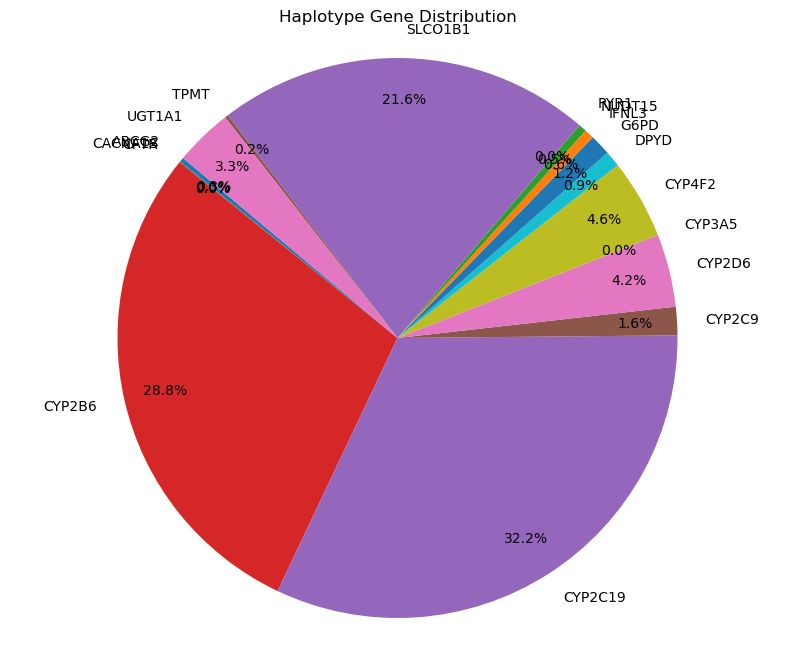

In [45]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a sample DataFrame
data = {'Haplotype_Gene': ['ABCG2', 'CACNA1S', 'CFTR', 'CYP2B6', 'CYP2C19', 'CYP2C9', 'CYP2D6', 'CYP3A5', 'CYP4F2', 'DPYD', 'G6PD', 'IFNL3', 'NUDT15', 'RYR1', 'SLCO1B1', 'TPMT', 'UGT1A1'],
        'Count': [297, 1, 30, 31935, 35731, 1815, 4655, 20, 5100, 1015, 1339, 622, 514, 3, 24001, 213, 3698]}
df = pd.DataFrame(data)

# Create a pie plot with labels outside
plt.figure(figsize=(10, 8))
plt.pie(df['Count'], labels=df['Haplotype_Gene'], autopct='%1.1f%%', startangle=140,
        pctdistance=0.85, labeldistance=1.1)  # Adjust labeldistance and pctdistance
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Haplotype Gene Distribution')
plt.show()

In [48]:
pip install pandas xlsxwriter

     -------------------------------------- 153.0/153.0 kB 1.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


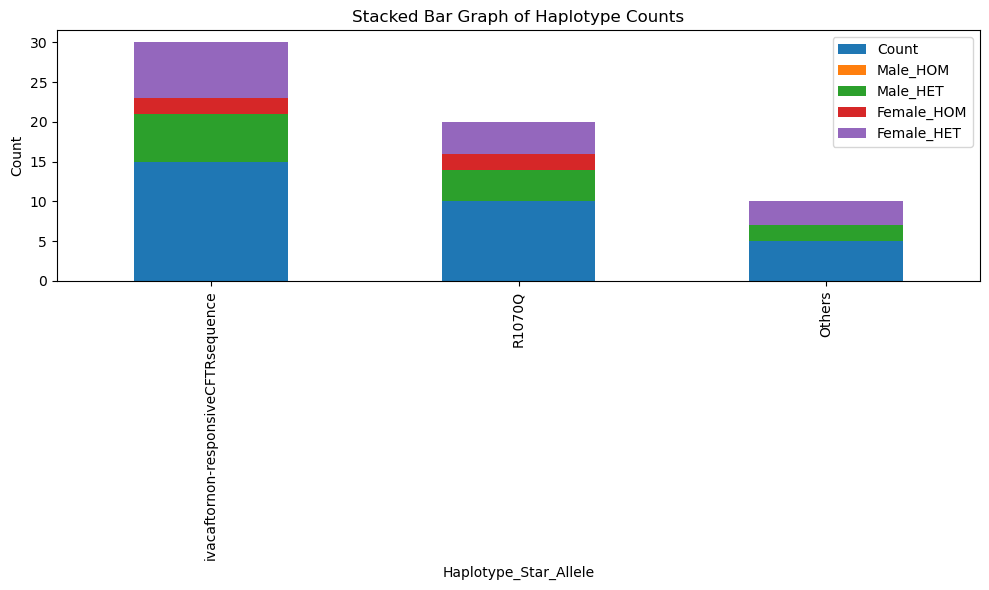

In [50]:
import pandas as pd
import matplotlib.pyplot as plt

# Your data
data = {
    'Haplotype_Star_Allele': ['ivacaftornon-responsiveCFTRsequence', 'R1070Q', 'Others'],
    'Count': [15, 10, 5],
    'Male_HOM': [0, 0, 0],
    'Male_HET': [6, 4, 2],
    'Female_HOM': [2, 2, 0],
    'Female_HET': [7, 4, 3]
}

skd_data = pd.DataFrame(data)

# Set 'Haplotype_Star_Allele' column as index
skd_data.set_index('Haplotype_Star_Allele', inplace=True)

# Plot the stacked bar graph
ax = skd_data.plot(kind='bar', stacked=True, figsize=(10, 6))
ax.set_ylabel('Count')
ax.set_title('Stacked Bar Graph of Haplotype Counts')

# Show the plot
plt.tight_layout()
plt.show()

In [5]:
import pandas as pd

# Assuming your data is stored in a DataFrame called 'df'
# Replace this with your actual data loading method

# Sample data
data = {
    'ID': ['rs3842753', 'rs3842753', 'rs3842753', 'rs1234567', 'rs1234567'],
    'Zygosity': ['HET', 'HET', 'HET', 'HOM', 'HOM'],
    'Matched_Gene': ['INS', 'INS', 'DEL', 'DEL', 'DEL'],
    'Sample_Name': [12652700, 12652700, 12652700, 45678901, 45678901],
    'EXON': ['3/3', '2/3', '1/3', '2/5', '4/5'],
    'IMPACT': ['MODIFIER', 'MODIFIER', 'HIGH', 'MODERATE', 'MODERATE']
}

df = pd.DataFrame(data)
df

,ID,Zygosity,Matched_Gene,Sample_Name,EXON,IMPACT
0,rs3842753,HET,INS,12652700,3/3,MODIFIER
1,rs3842753,HET,INS,12652700,2/3,MODIFIER
2,rs3842753,HET,DEL,12652700,1/3,HIGH
3,rs1234567,HOM,DEL,45678901,2/5,MODERATE
4,rs1234567,HOM,DEL,45678901,4/5,MODERATE


In [6]:
# Convert the denominator part of EXON to integer for comparison
df['EXON_Denominator'] = df['EXON'].apply(lambda x: int(x.split('/')[1]))

# Sort the DataFrame by Sample_Name and EXON_Denominator in descending order
df.sort_values(by=['Sample_Name', 'EXON_Denominator'], ascending=[True, False], inplace=True)

# Drop duplicates based on Sample_Name, keeping the first (highest) EXON value
df.drop_duplicates(subset='Sample_Name', keep='first', inplace=True)

# Drop the temporary EXON_Denominator column
df.drop(columns=['EXON_Denominator'], inplace=True)
df

,ID,Zygosity,Matched_Gene,Sample_Name,EXON,IMPACT
0,rs3842753,HET,INS,12652700,3/3,MODIFIER
3,rs1234567,HOM,DEL,45678901,2/5,MODERATE


In [38]:
import pandas as pd

# Sample data
data = {
    'sample': ['sample1', 'sample1', 'sample2', 'sample2', 'sample2'],
    'rsID': ['rs123', 'rs123', 'rs456', 'rs789', 'rs789'],
    'Gene': ['GeneA', 'GeneA', 'GeneB', 'GeneC', 'GeneC'],
    'IMPACT': ['MODERATE', 'HIGH', 'LOW', 'MODERATE', 'MODIFIER']
}

# Create a DataFrame
df = pd.DataFrame(data)
df

,sample,rsID,Gene,IMPACT
0,sample1,rs123,GeneA,MODERATE
1,sample1,rs123,GeneA,HIGH
2,sample2,rs456,GeneB,LOW
3,sample2,rs789,GeneC,MODERATE
4,sample2,rs789,GeneC,MODIFIER


In [39]:
# Define the priority order
impact_order = ['HIGH', 'MODERATE', 'LOW', 'MODIFIER']

# Sort the DataFrame based on the priority
df['IMPACT'] = pd.Categorical(df['IMPACT'], categories=impact_order, ordered=True)
df.sort_values(['sample', 'rsID', 'Gene', 'IMPACT'], ascending=[True, True, True, True], inplace=True)

# Drop duplicates while keeping the first occurrence
filtered_df = df.drop_duplicates(subset=['sample', 'rsID', 'Gene'], keep='first')

filtered_df

,sample,rsID,Gene,IMPACT
1,sample1,rs123,GeneA,HIGH
2,sample2,rs456,GeneB,LOW
3,sample2,rs789,GeneC,MODERATE


In [37]:
# Define the priority order
impact_order = ['HIGH', 'MODERATE', 'LOW', 'MODIFIER']

# Sort the DataFrame based on the priority
df['IMPACT'] = pd.Categorical(df['IMPACT'], categories=impact_order, ordered=True)
df.sort_values(['sample', 'rsID', 'Gene', 'IMPACT'], ascending=[True, True, True, False], inplace=True)
df
# Drop duplicates while keeping the first occurrence
#filtered_df = df.drop_duplicates(subset=['sample', 'rsID', 'Gene'], keep='first')

#filtered_df

,sample,rsID,Gene,IMPACT
0,sample1,rs123,GeneA,MODERATE
1,sample1,rs123,GeneA,HIGH
2,sample2,rs456,GeneB,LOW
4,sample2,rs789,GeneC,MODIFIER
3,sample2,rs789,GeneC,MODERATE


In [17]:
import pandas as pd

# Create a sample DataFrame
data = {'Column1': ['A', 'D,E', 'F', 'G,H,I,J'],
        'Column2': ['A,B,C', 'X,Y,Z', 'P,Q,R', 'K,L']}
df = pd.DataFrame(data)

# Concatenate the two columns with commas
df['Concatenated'] = df['Column1'] + ',' + df['Column2']

# Split the concatenated values into sets of values in a new column and sort them
df['Concatenated'] = df['Concatenated'].str.split(',').apply(lambda x: ','.join(sorted(set(x))))

# Display the updated DataFrame
df

,Column1,Column2,Concatenated
0,A,"A,B,C","A,B,C"
1,"D,E","X,Y,Z","D,E,X,Y,Z"
2,F,"P,Q,R","F,P,Q,R"
3,"G,H,I,J","K,L","G,H,I,J,K,L"


In [23]:
import pandas as pd

# Create a sample DataFrame
data = {'genes': ['ABCC8,BRCA1', 'INS,BRCA2', ' ,BRCA2', 'ABCD4']}
df = pd.DataFrame(data)

# Replace rows that start with a space with an empty string
df['genes'] = df['genes'].str.replace(r'^\s+,', '', regex=True)

# Display the updated DataFrame
df

,genes
0,"ABCC8,BRCA1"
1,"INS,BRCA2"
2,BRCA2
3,ABCD4


In [34]:
vcf = pd.read_excel(r'C:/Users/GenepoweRx_Madhu/Documents/Processed_vcf_files/Gene_scores_KHGLBS583_depth_vcf_processed.xlsx')
vcf

,Gene Name,Gene,Gene_Score,Condition,Headings,21_Conditions_list,rsID,Literature,CHROM,POS,REF,ALT,Zygosity,Consequence,Consequence_score,IMPACT,IMPACT_score,ClinVar_CLNDN,CLIN_SIG,ClinVar_CLNREVSTAT,ClinVar,HGVSc,HGVSc (Transcript),HGVSp,HGVSp (Transcript),GT,GQ,SDP,DP,RD,AD,FREQ,PVAL,RDF,RDR,ADF,ADR,SIFT,PolyPhen,AF,AFR_AF,AMR_AF,EAS_AF,EUR_AF,SAS_AF,gnomADe_AF,gnomADe_AFR_AF,gnomADe_AMR_AF,gnomADe_ASJ_AF,gnomADe_EAS_AF,gnomADe_FIN_AF,gnomADe_NFE_AF,gnomADe_OTH_AF,gnomADe_SAS_AF,gnomADg_AF,gnomADg_AFR_AF,gnomADg_AMI_AF,gnomADg_AMR_AF,gnomADg_ASJ_AF,gnomADg_EAS_AF,gnomADg_FIN_AF,gnomADg_MID_AF,gnomADg_NFE_AF,gnomADg_OTH_AF,gnomADg_SAS_AF,MAX_AF,MAX_AF_POPS,BIOTYPE,EXON,INTRON,Protein Position and Amino Acid,Codons,STRAND,PUBMED
0,NaN,NaN,No,No,No,No,rs1416222198,No,chr1,65591,C,T,Heterozygous,downstream gene variant,2/10,MODIFIER,1.5,NaN,NaN,NaN,NaN,NaN,None,NaN,None,0/1,30,29,29,20,9,31.03%,9.404800e-04,11,9,7,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.03416,0.02306,0.1667,0.02711,0.03333,0.001639,0.0000,0.0500,0.09167,0.05357,0.02083,0.1667,gnomADg AMI,transcribed unprocessed pseudogene,NaN,NaN,NaN,NaN,1.0,NaN
1,NaN,NaN,No,No,No,No,rs1416222198,No,chr1,65591,C,T,Heterozygous,intron variant,2/10,MODIFIER,1.5,NaN,NaN,NaN,NaN,ENST00000641515.2,c.9+18C>T,NaN,None,0/1,30,29,29,20,9,31.03%,9.404800e-04,11,9,7,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.03416,0.02306,0.1667,0.02711,0.03333,0.001639,0.0000,0.0500,0.09167,0.05357,0.02083,0.1667,gnomADg AMI,protein coding,NaN,2/2,NaN,NaN,1.0,NaN
2,NaN,NaN,No,No,No,No,rs1416222198,No,chr1,65591,C,T,Heterozygous,downstream gene variant,2/10,MODIFIER,1.5,NaN,NaN,NaN,NaN,NaN,None,NaN,None,0/1,30,29,29,20,9,31.03%,9.404800e-04,11,9,7,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.03416,0.02306,0.1667,0.02711,0.03333,0.001639,0.0000,0.0500,0.09167,0.05357,0.02083,0.1667,gnomADg AMI,lncRNA,NaN,NaN,NaN,NaN,1.0,NaN
3,OR4F5,NaN,No,No,No,No,rs201219564,No,chr1,69270,A,G,Heterozygous,synonymous variant,3/10,LOW,2.5,NaN,NaN,NaN,NaN,ENST00000641515.2,c.243A>G,ENSP00000493376.2,p.Ser81%3D,0/1,94,95,95,67,28,29.47%,3.598000e-10,63,4,22,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.838,0.3591,0.7932,0.8482,0.9984,0.8821,0.9146,0.868,0.9005,0.62910,0.35440,0.8158,0.69450,0.80330,0.996100,0.9294,0.7857,0.87980,0.60870,0.88550,0.9984,gnomADe EAS,protein coding,3/3,NaN,S81,tcA/tcG,1.0,NaN
4,OR4F5,NaN,No,No,No,No,rs201219564,No,chr1,69270,A,G,Heterozygous,regulatory region variant,2/10,MODIFIER,1.5,NaN,NaN,NaN,NaN,NaN,None,NaN,None,0/1,94,95,95,67,28,29.47%,3.598000e-10,63,4,22,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.838,0.3591,0.7932,0.8482,0.9984,0.8821,0.9146,0.868,0.9005,0.62910,0.35440,0.8158,0.69450,0.80330,0.996100,0.9294,0.7857,0.87980,0.60870,0.88550,0.9984,gnomADe EAS,TF binding site,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315111,RAB39B,NaN,No,No,No,No,rs3105275,No,chrX,155259147,A,G,Homozygous,3 prime UTR variant,3/10,MODIFIER,1.5,NaN,benign,NaN,NaN,ENST00000369454.4,c.*1656T>C,NaN,None,1/1,255,53,53,0,53,100%,1.594300e-31,0,0,38,15,NaN,NaN,0.5960,0.2383,0.6202,0.7251,0.8029,0.7201,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.61610,0.29760,0.6866,0.63900,0.76200,0.721900,0.7682,0.7881,0.75770,0.62840,0.72010,0.8029,EUR,protein coding,2/2,NaN,NaN,NaN,-1.0,NaN
315112,CLIC2,NaN,No,No,No,No,rs559165,No,chrX,155277884,G,T,Homozygous,downstream gene variant,2/10,MODIFIER,1.5,NaN,benign,NaN,NaN,NaN,None,NaN,None,1/1,123,22,22,0,22,100%,4.752600e-13,0,0,19,3,NaN,NaN,0.6458,0.4108,0.6450,0.7277,0.8055,0.7173,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.66160,0.44990,0.6906,0.66390,0.76190,0.725400,0.7679,0.7778,0.75800,0.67750,0.71760,0.8055,EUR,protein coding,NaN,NaN,NaN

In [40]:
x = vcf[vcf['21_Conditions_list'] != 'No']
x

,Gene Name,Gene,Gene_Score,Condition,Headings,21_Conditions_list,rsID,Literature,CHROM,POS,REF,ALT,Zygosity,Consequence,Consequence_score,IMPACT,IMPACT_score,ClinVar_CLNDN,CLIN_SIG,ClinVar_CLNREVSTAT,ClinVar,HGVSc,HGVSc (Transcript),HGVSp,HGVSp (Transcript),GT,GQ,SDP,DP,RD,AD,FREQ,PVAL,RDF,RDR,ADF,ADR,SIFT,PolyPhen,AF,AFR_AF,AMR_AF,EAS_AF,EUR_AF,SAS_AF,gnomADe_AF,gnomADe_AFR_AF,gnomADe_AMR_AF,gnomADe_ASJ_AF,gnomADe_EAS_AF,gnomADe_FIN_AF,gnomADe_NFE_AF,gnomADe_OTH_AF,gnomADe_SAS_AF,gnomADg_AF,gnomADg_AFR_AF,gnomADg_AMI_AF,gnomADg_AMR_AF,gnomADg_ASJ_AF,gnomADg_EAS_AF,gnomADg_FIN_AF,gnomADg_MID_AF,gnomADg_NFE_AF,gnomADg_OTH_AF,gnomADg_SAS_AF,MAX_AF,MAX_AF_POPS,BIOTYPE,EXON,INTRON,Protein Position and Amino Acid,Codons,STRAND,PUBMED
2303,NPHP4,NPHP4,8,Focal segmental glomerulosclerosis; Tubular In...,Glomerular Diseases; Tubular Interstitial dise...,Glomerular_Diseases; Interstitial_Nephritis,rs555164,No,chr1,5866447,T,C,Homozygous,synonymous variant,3/10,LOW,2.5,"Nephronophthisis,Nephronophthisis 4,Senior-Lok...",benign,"criteria provided, multiple submitters, no con...",95683.0,ENST00000378156.9,c.3570A>G,ENSP00000367398.4,p.Glu1190%3D,1/1,188,33,33,0,33,100%,1.385200e-19,0,0,24,9,NaN,NaN,0.3197,0.1619,0.3790,0.2837,0.4135,0.4315,0.3926,0.20020,0.3706,0.4699,0.2558,0.42560,0.4222,0.4067,0.4302,0.35380,0.20830,0.5493,0.3694,0.4614,0.2711,0.42760,0.3924,0.41970,0.3617,0.4301,0.5493,gnomADg AMI,protein coding,26/30,NaN,E1190,gaA/gaG,-1.0,"25741868,23757202"
2304,NPHP4,NPHP4,8,Focal segmental glomerulosclerosis; Tubular In...,Glomerular Diseases; Tubular Interstitial dise...,Glomerular_Diseases; Interstitial_Nephritis,rs555164,No,chr1,5866447,T,C,Homozygous,non coding transcript exon variant,2/10,MODIFIER,1.5,"Nephronophthisis,Nephronophthisis 4,Senior-Lok...",benign,"criteria provided, multiple submitters, no con...",95683.0,ENST00000378161.5,n.734A>G,NaN,None,1/1,188,33,33,0,33,100%,1.385200e-19,0,0,24,9,NaN,NaN,0.3197,0.1619,0.3790,0.2837,0.4135,0.4315,0.3926,0.20020,0.3706,0.4699,0.2558,0.42560,0.4222,0.4067,0.4302,0.35380,0.20830,0.5493,0.3694,0.4614,0.2711,0.42760,0.3924,0.41970,0.3617,0.4301,0.5493,gnomADg AMI,retained intron,3/3,NaN,NaN,NaN,-1.0,"25741868,23757202"
2305,NPHP4,NPHP4,8,Focal segmental glomerulosclerosis; Tubular In...,Glomerular Diseases; Tubular Interstitial dise...,Glomerular_Diseases; Interstitial_Nephritis,rs555164,No,chr1,5866447,T,C,Homozygous,"3 prime UTR variant,NMD transcript variant",3/10,MODIFIER,1.5,"Nephronophthisis,Nephronophthisis 4,Senior-Lok...",benign,"criteria provided, multiple submitters, no con...",95683.0,ENST00000378169.7,c.*2471A>G,NaN,None,1/1,188,33,33,0,33,100%,1.385200e-19,0,0,24,9,NaN,NaN,0.3197,0.1619,0.3790,0.2837,0.4135,0.4315,0.3926,0.20020,0.3706,0.4699,0.2558,0.42560,0.4222,0.4067,0.4302,0.35380,0.20830,0.5493,0.3694,0.4614,0.2711,0.42760,0.3924,0.41970,0.3617,0.4301,0.5493,gnomADg AMI,nonsense mediated decay,23/27,NaN,NaN,NaN,-1.0,"25741868,23757202"
2306,NPHP4,NPHP4,8,Focal segmental glomerulosclerosis; Tubular In...,Glomerular Diseases; Tubular Interstitial dise...,Glomerular_Diseases; Interstitial_Nephritis,rs555164,No,chr1,5866447,T,C,Homozygous,non coding transcript exon variant,2/10,MODIFIER,1.5,"Nephronophthisis,Nephronophthisis 4,Senior-Lok...",benign,"criteria provided, multiple submitters, no con...",95683.0,ENST00000460696.1,n.635A>G,NaN,None,1/1,188,33,33,0,33,100%,1.385200e-19,0,0,24,9,NaN,NaN,0.3197,0.1619,0.3790,0.2837,0.4135,0.4315,0.3926,0.20020,0.3706,0.4699,0.2558,0.42560,0.4222,0.4067,0.4302,0.35380,0.20830,0.5493,0.3694,0.4614,0.2711,0.42760,0.3924,0.41970,0.3617,0.4301,0.5493,gnomADg AMI,retained intron,2/3,NaN,NaN,NaN,-1.0,"25741868,23757202"
2307,NPHP4,NPHP4,8,Focal segmental glomerulosclerosis; Tubular In...,Glomerular Diseases; Tubular Interstitial dise...,Glomerular_Diseases; Interstitial_Nephritis,rs555164,No,chr1,5866447,T,C,Homozygous,downstream gene variant,2/10,MODIFIER,1.5,"Nephronophthisis,Nephronophthisis 4,Senior-Lok...",benign,"criteria 

In [41]:
cons_x = x[x['Consequence_score'].apply(lambda x: eval(x) >= 6/10)]
cons_x

,Gene Name,Gene,Gene_Score,Condition,Headings,21_Conditions_list,rsID,Literature,CHROM,POS,REF,ALT,Zygosity,Consequence,Consequence_score,IMPACT,IMPACT_score,ClinVar_CLNDN,CLIN_SIG,ClinVar_CLNREVSTAT,ClinVar,HGVSc,HGVSc (Transcript),HGVSp,HGVSp (Transcript),GT,GQ,SDP,DP,RD,AD,FREQ,PVAL,RDF,RDR,ADF,ADR,SIFT,PolyPhen,AF,AFR_AF,AMR_AF,EAS_AF,EUR_AF,SAS_AF,gnomADe_AF,gnomADe_AFR_AF,gnomADe_AMR_AF,gnomADe_ASJ_AF,gnomADe_EAS_AF,gnomADe_FIN_AF,gnomADe_NFE_AF,gnomADe_OTH_AF,gnomADe_SAS_AF,gnomADg_AF,gnomADg_AFR_AF,gnomADg_AMI_AF,gnomADg_AMR_AF,gnomADg_ASJ_AF,gnomADg_EAS_AF,gnomADg_FIN_AF,gnomADg_MID_AF,gnomADg_NFE_AF,gnomADg_OTH_AF,gnomADg_SAS_AF,MAX_AF,MAX_AF_POPS,BIOTYPE,EXON,INTRON,Protein Position and Amino Acid,Codons,STRAND,PUBMED
5222,PADI4,PADI4,No,Rheumatoid Arthritis,Autoimmune Disorder,Arthritis_Degenerative_Joint_Disease,rs11203366,No,chr1,17331039,G,A,Heterozygous,missense variant,7/10,MODERATE,5.0,"Rheumatoid arthritis,Abnormal pulmonary inters...",association,no assertion criteria provided,972892.0,ENST00000375448.4,c.163G>A,ENSP00000364597.4,p.Gly55Ser,0/1,50,47,47,32,15,31.91%,8.086400e-06,29,3,7,8,tolerated(1),benign(0),0.5246,0.4508,0.5432,0.5635,0.5755,0.5184,0.5589,0.4713,0.5003,0.5952,0.5767,0.5898,0.5858,0.5713,0.5220,0.5508,0.4763,0.6490,0.5484,0.6176,0.5931,0.5930,0.5759,0.5840,0.5311,0.5319,0.6490,gnomADg AMI,protein coding,2/16,NaN,G55S,Ggc/Agc,1.0,"23251581,26843965,23164236,18576335,20537173,2..."
5223,PADI4,PADI4,No,Rheumatoid Arthritis,Autoimmune Disorder,Arthritis_Degenerative_Joint_Disease,rs11203366,No,chr1,17331039,G,A,Heterozygous,missense variant,7/10,MODERATE,5.0,"Rheumatoid arthritis,Abnormal pulmonary inters...",association,no assertion criteria provided,972892.0,ENST00000375453.5,c.163G>A,ENSP00000364602.1,p.Gly55Ser,0/1,50,47,47,32,15,31.91%,8.086400e-06,29,3,7,8,tolerated(1),benign(0),0.5246,0.4508,0.5432,0.5635,0.5755,0.5184,0.5589,0.4713,0.5003,0.5952,0.5767,0.5898,0.5858,0.5713,0.5220,0.5508,0.4763,0.6490,0.5484,0.6176,0.5931,0.5930,0.5759,0.5840,0.5311,0.5319,0.6490,gnomADg AMI,protein coding,2/4,NaN,G55S,Ggc/Agc,1.0,"23251581,26843965,23164236,18576335,20537173,2..."
5224,PADI4,PADI4,No,Rheumatoid Arthritis,Autoimmune Disorder,Arthritis_Degenerative_Joint_Disease,rs874881,No,chr1,17334004,G,C,Heterozygous,missense variant,7/10,MODERATE,5.0,"Rheumatoid arthritis,Abnormal pulmonary inters...",association,no assertion criteria provided,972895.0,ENST00000375448.4,c.335G>C,ENSP00000364597.4,p.Gly112Ala,0/1,29,15,15,7,8,53.33%,1.099500e-03,7,0,5,3,tolerated(0.67),benign(0.196),0.5220,0.4607,0.5403,0.5585,0.5537,0.5215,0.5453,0.4790,0.4973,0.5764,0.5781,0.5581,0.5635,0.5577,0.5253,0.5361,0.4791,0.6355,0.5395,0.5988,0.5903,0.5603,0.5759,0.5579,0.5207,0.5347,0.6355,gnomADg AMI,protein coding,3/16,NaN,G112A,gGg/gCg,1.0,"23251581,26843965,21698003,18576335,20537173,2..."
5225,PADI4,PADI4,No,Rheumatoid Arthritis,Autoimmune Disorder,Arthritis_Degenerative_Joint_Disease,rs874881,No,chr1,17334004,G,C,Heterozygous,missense variant,7/10,MODERATE,5.0,"Rheumatoid arthritis,Abnormal pulmonary inters...",association,no assertion criteria provided,972895.0,ENST00000375453.5,c.335G>C,ENSP00000364602.1,p.Gly112Ala,0/1,29,15,15,7,8,53.33%,1.099500e-03,7,0,5,3,tolerated(0.9),benign(0.332),0.5220,0.4607,0.5403,0.5585,0.5537,0.5215,0.5453,0.4790,0.4973,0.5764,0.5781,0.5581,0.5635,0.5577,0.5253,0.5361,0.4791,0.6355,0.5395,0.5988,0.5903,0.5603,0.5759,0.5579,0.5207,0.5347,0.6355,gnomADg AMI,protein coding,3/4,NaN,G112A,gGg/gCg,1.0,"23251581,26843965,21698003,18576335,20537173,2..."
6559,LDLRAP1,LDLRAP1,8,"Polygenic (Familial combined, small dense LDL,...",Cholesterol disorders,Cholesterol_Disorders,rs6687605,No,chr1,25563141,T,C,Heterozygous,missense variant,7/10,MODERATE,5.0,"Cardiovascular phenotype,Hypercholesterolemia,...",benign,"criteria provided, multiple submitters, no con...",296982.0,ENST00000374338.5,c.604T>C,ENSP00000363458.4,p.Ser202Pro,0/1,44,16,16,5,11,68.75%,3.385400e-05,3,2,5,6,deleterious(0.04),benig

In [42]:
dp_x = cons_x[cons_x['DP'] >= 15]
dp_x

,Gene Name,Gene,Gene_Score,Condition,Headings,21_Conditions_list,rsID,Literature,CHROM,POS,REF,ALT,Zygosity,Consequence,Consequence_score,IMPACT,IMPACT_score,ClinVar_CLNDN,CLIN_SIG,ClinVar_CLNREVSTAT,ClinVar,HGVSc,HGVSc (Transcript),HGVSp,HGVSp (Transcript),GT,GQ,SDP,DP,RD,AD,FREQ,PVAL,RDF,RDR,ADF,ADR,SIFT,PolyPhen,AF,AFR_AF,AMR_AF,EAS_AF,EUR_AF,SAS_AF,gnomADe_AF,gnomADe_AFR_AF,gnomADe_AMR_AF,gnomADe_ASJ_AF,gnomADe_EAS_AF,gnomADe_FIN_AF,gnomADe_NFE_AF,gnomADe_OTH_AF,gnomADe_SAS_AF,gnomADg_AF,gnomADg_AFR_AF,gnomADg_AMI_AF,gnomADg_AMR_AF,gnomADg_ASJ_AF,gnomADg_EAS_AF,gnomADg_FIN_AF,gnomADg_MID_AF,gnomADg_NFE_AF,gnomADg_OTH_AF,gnomADg_SAS_AF,MAX_AF,MAX_AF_POPS,BIOTYPE,EXON,INTRON,Protein Position and Amino Acid,Codons,STRAND,PUBMED
5222,PADI4,PADI4,No,Rheumatoid Arthritis,Autoimmune Disorder,Arthritis_Degenerative_Joint_Disease,rs11203366,No,chr1,17331039,G,A,Heterozygous,missense variant,7/10,MODERATE,5.0,"Rheumatoid arthritis,Abnormal pulmonary inters...",association,no assertion criteria provided,972892.0,ENST00000375448.4,c.163G>A,ENSP00000364597.4,p.Gly55Ser,0/1,50,47,47,32,15,31.91%,8.086400e-06,29,3,7,8,tolerated(1),benign(0),0.5246,0.4508,0.5432,0.5635,0.5755,0.5184,0.5589,0.4713,0.5003,0.5952,0.5767,0.5898,0.5858,0.5713,0.5220,0.5508,0.4763,0.6490,0.5484,0.6176,0.5931,0.5930,0.5759,0.5840,0.5311,0.5319,0.6490,gnomADg AMI,protein coding,2/16,NaN,G55S,Ggc/Agc,1.0,"23251581,26843965,23164236,18576335,20537173,2..."
5223,PADI4,PADI4,No,Rheumatoid Arthritis,Autoimmune Disorder,Arthritis_Degenerative_Joint_Disease,rs11203366,No,chr1,17331039,G,A,Heterozygous,missense variant,7/10,MODERATE,5.0,"Rheumatoid arthritis,Abnormal pulmonary inters...",association,no assertion criteria provided,972892.0,ENST00000375453.5,c.163G>A,ENSP00000364602.1,p.Gly55Ser,0/1,50,47,47,32,15,31.91%,8.086400e-06,29,3,7,8,tolerated(1),benign(0),0.5246,0.4508,0.5432,0.5635,0.5755,0.5184,0.5589,0.4713,0.5003,0.5952,0.5767,0.5898,0.5858,0.5713,0.5220,0.5508,0.4763,0.6490,0.5484,0.6176,0.5931,0.5930,0.5759,0.5840,0.5311,0.5319,0.6490,gnomADg AMI,protein coding,2/4,NaN,G55S,Ggc/Agc,1.0,"23251581,26843965,23164236,18576335,20537173,2..."
5224,PADI4,PADI4,No,Rheumatoid Arthritis,Autoimmune Disorder,Arthritis_Degenerative_Joint_Disease,rs874881,No,chr1,17334004,G,C,Heterozygous,missense variant,7/10,MODERATE,5.0,"Rheumatoid arthritis,Abnormal pulmonary inters...",association,no assertion criteria provided,972895.0,ENST00000375448.4,c.335G>C,ENSP00000364597.4,p.Gly112Ala,0/1,29,15,15,7,8,53.33%,1.099500e-03,7,0,5,3,tolerated(0.67),benign(0.196),0.5220,0.4607,0.5403,0.5585,0.5537,0.5215,0.5453,0.4790,0.4973,0.5764,0.5781,0.5581,0.5635,0.5577,0.5253,0.5361,0.4791,0.6355,0.5395,0.5988,0.5903,0.5603,0.5759,0.5579,0.5207,0.5347,0.6355,gnomADg AMI,protein coding,3/16,NaN,G112A,gGg/gCg,1.0,"23251581,26843965,21698003,18576335,20537173,2..."
5225,PADI4,PADI4,No,Rheumatoid Arthritis,Autoimmune Disorder,Arthritis_Degenerative_Joint_Disease,rs874881,No,chr1,17334004,G,C,Heterozygous,missense variant,7/10,MODERATE,5.0,"Rheumatoid arthritis,Abnormal pulmonary inters...",association,no assertion criteria provided,972895.0,ENST00000375453.5,c.335G>C,ENSP00000364602.1,p.Gly112Ala,0/1,29,15,15,7,8,53.33%,1.099500e-03,7,0,5,3,tolerated(0.9),benign(0.332),0.5220,0.4607,0.5403,0.5585,0.5537,0.5215,0.5453,0.4790,0.4973,0.5764,0.5781,0.5581,0.5635,0.5577,0.5253,0.5361,0.4791,0.6355,0.5395,0.5988,0.5903,0.5603,0.5759,0.5579,0.5207,0.5347,0.6355,gnomADg AMI,protein coding,3/4,NaN,G112A,gGg/gCg,1.0,"23251581,26843965,21698003,18576335,20537173,2..."
6559,LDLRAP1,LDLRAP1,8,"Polygenic (Familial combined, small dense LDL,...",Cholesterol disorders,Cholesterol_Disorders,rs6687605,No,chr1,25563141,T,C,Heterozygous,missense variant,7/10,MODERATE,5.0,"Cardiovascular phenotype,Hypercholesterolemia,...",benign,"criteria provided, multiple submitters, no con...",296982.0,ENST00000374338.5,c.604T>C,ENSP00000363458.4,p.Ser202Pro,0/1,44,16,16,5,11,68.75%,3.385400e-05,3,2,5,6,deleterious(0.04),benig

In [43]:
gnomADe_AF_x = dp_x[dp_x['gnomADe_AF'] <= 0.6]
gnomADe_AF_x

,Gene Name,Gene,Gene_Score,Condition,Headings,21_Conditions_list,rsID,Literature,CHROM,POS,REF,ALT,Zygosity,Consequence,Consequence_score,IMPACT,IMPACT_score,ClinVar_CLNDN,CLIN_SIG,ClinVar_CLNREVSTAT,ClinVar,HGVSc,HGVSc (Transcript),HGVSp,HGVSp (Transcript),GT,GQ,SDP,DP,RD,AD,FREQ,PVAL,RDF,RDR,ADF,ADR,SIFT,PolyPhen,AF,AFR_AF,AMR_AF,EAS_AF,EUR_AF,SAS_AF,gnomADe_AF,gnomADe_AFR_AF,gnomADe_AMR_AF,gnomADe_ASJ_AF,gnomADe_EAS_AF,gnomADe_FIN_AF,gnomADe_NFE_AF,gnomADe_OTH_AF,gnomADe_SAS_AF,gnomADg_AF,gnomADg_AFR_AF,gnomADg_AMI_AF,gnomADg_AMR_AF,gnomADg_ASJ_AF,gnomADg_EAS_AF,gnomADg_FIN_AF,gnomADg_MID_AF,gnomADg_NFE_AF,gnomADg_OTH_AF,gnomADg_SAS_AF,MAX_AF,MAX_AF_POPS,BIOTYPE,EXON,INTRON,Protein Position and Amino Acid,Codons,STRAND,PUBMED
5222,PADI4,PADI4,No,Rheumatoid Arthritis,Autoimmune Disorder,Arthritis_Degenerative_Joint_Disease,rs11203366,No,chr1,17331039,G,A,Heterozygous,missense variant,7/10,MODERATE,5.0,"Rheumatoid arthritis,Abnormal pulmonary inters...",association,no assertion criteria provided,972892.0,ENST00000375448.4,c.163G>A,ENSP00000364597.4,p.Gly55Ser,0/1,50,47,47,32,15,31.91%,8.086400e-06,29,3,7,8,tolerated(1),benign(0),0.5246,0.4508,0.5432,0.5635,0.5755,0.5184,0.5589,0.4713,0.5003,0.5952,0.5767,0.5898,0.5858,0.5713,0.5220,0.5508,0.4763,0.6490,0.5484,0.6176,0.5931,0.5930,0.5759,0.5840,0.5311,0.5319,0.6490,gnomADg AMI,protein coding,2/16,NaN,G55S,Ggc/Agc,1.0,"23251581,26843965,23164236,18576335,20537173,2..."
5223,PADI4,PADI4,No,Rheumatoid Arthritis,Autoimmune Disorder,Arthritis_Degenerative_Joint_Disease,rs11203366,No,chr1,17331039,G,A,Heterozygous,missense variant,7/10,MODERATE,5.0,"Rheumatoid arthritis,Abnormal pulmonary inters...",association,no assertion criteria provided,972892.0,ENST00000375453.5,c.163G>A,ENSP00000364602.1,p.Gly55Ser,0/1,50,47,47,32,15,31.91%,8.086400e-06,29,3,7,8,tolerated(1),benign(0),0.5246,0.4508,0.5432,0.5635,0.5755,0.5184,0.5589,0.4713,0.5003,0.5952,0.5767,0.5898,0.5858,0.5713,0.5220,0.5508,0.4763,0.6490,0.5484,0.6176,0.5931,0.5930,0.5759,0.5840,0.5311,0.5319,0.6490,gnomADg AMI,protein coding,2/4,NaN,G55S,Ggc/Agc,1.0,"23251581,26843965,23164236,18576335,20537173,2..."
5224,PADI4,PADI4,No,Rheumatoid Arthritis,Autoimmune Disorder,Arthritis_Degenerative_Joint_Disease,rs874881,No,chr1,17334004,G,C,Heterozygous,missense variant,7/10,MODERATE,5.0,"Rheumatoid arthritis,Abnormal pulmonary inters...",association,no assertion criteria provided,972895.0,ENST00000375448.4,c.335G>C,ENSP00000364597.4,p.Gly112Ala,0/1,29,15,15,7,8,53.33%,1.099500e-03,7,0,5,3,tolerated(0.67),benign(0.196),0.5220,0.4607,0.5403,0.5585,0.5537,0.5215,0.5453,0.4790,0.4973,0.5764,0.5781,0.5581,0.5635,0.5577,0.5253,0.5361,0.4791,0.6355,0.5395,0.5988,0.5903,0.5603,0.5759,0.5579,0.5207,0.5347,0.6355,gnomADg AMI,protein coding,3/16,NaN,G112A,gGg/gCg,1.0,"23251581,26843965,21698003,18576335,20537173,2..."
5225,PADI4,PADI4,No,Rheumatoid Arthritis,Autoimmune Disorder,Arthritis_Degenerative_Joint_Disease,rs874881,No,chr1,17334004,G,C,Heterozygous,missense variant,7/10,MODERATE,5.0,"Rheumatoid arthritis,Abnormal pulmonary inters...",association,no assertion criteria provided,972895.0,ENST00000375453.5,c.335G>C,ENSP00000364602.1,p.Gly112Ala,0/1,29,15,15,7,8,53.33%,1.099500e-03,7,0,5,3,tolerated(0.9),benign(0.332),0.5220,0.4607,0.5403,0.5585,0.5537,0.5215,0.5453,0.4790,0.4973,0.5764,0.5781,0.5581,0.5635,0.5577,0.5253,0.5361,0.4791,0.6355,0.5395,0.5988,0.5903,0.5603,0.5759,0.5579,0.5207,0.5347,0.6355,gnomADg AMI,protein coding,3/4,NaN,G112A,gGg/gCg,1.0,"23251581,26843965,21698003,18576335,20537173,2..."
6559,LDLRAP1,LDLRAP1,8,"Polygenic (Familial combined, small dense LDL,...",Cholesterol disorders,Cholesterol_Disorders,rs6687605,No,chr1,25563141,T,C,Heterozygous,missense variant,7/10,MODERATE,5.0,"Cardiovascular phenotype,Hypercholesterolemia,...",benign,"criteria provided, multiple submitters, no con...",296982.0,ENST00000374338.5,c.604T>C,ENSP00000363458.4,p.Ser202Pro,0/1,44,16,16,5,11,68.75%,3.385400e-05,3,2,5,6,deleterious(0.04),benig

In [44]:
gnomADe_SAS_AF_x = dp_x[dp_x['gnomADe_SAS_AF'] <= 0.6]
gnomADe_SAS_AF_x

,Gene Name,Gene,Gene_Score,Condition,Headings,21_Conditions_list,rsID,Literature,CHROM,POS,REF,ALT,Zygosity,Consequence,Consequence_score,IMPACT,IMPACT_score,ClinVar_CLNDN,CLIN_SIG,ClinVar_CLNREVSTAT,ClinVar,HGVSc,HGVSc (Transcript),HGVSp,HGVSp (Transcript),GT,GQ,SDP,DP,RD,AD,FREQ,PVAL,RDF,RDR,ADF,ADR,SIFT,PolyPhen,AF,AFR_AF,AMR_AF,EAS_AF,EUR_AF,SAS_AF,gnomADe_AF,gnomADe_AFR_AF,gnomADe_AMR_AF,gnomADe_ASJ_AF,gnomADe_EAS_AF,gnomADe_FIN_AF,gnomADe_NFE_AF,gnomADe_OTH_AF,gnomADe_SAS_AF,gnomADg_AF,gnomADg_AFR_AF,gnomADg_AMI_AF,gnomADg_AMR_AF,gnomADg_ASJ_AF,gnomADg_EAS_AF,gnomADg_FIN_AF,gnomADg_MID_AF,gnomADg_NFE_AF,gnomADg_OTH_AF,gnomADg_SAS_AF,MAX_AF,MAX_AF_POPS,BIOTYPE,EXON,INTRON,Protein Position and Amino Acid,Codons,STRAND,PUBMED
5222,PADI4,PADI4,No,Rheumatoid Arthritis,Autoimmune Disorder,Arthritis_Degenerative_Joint_Disease,rs11203366,No,chr1,17331039,G,A,Heterozygous,missense variant,7/10,MODERATE,5.0,"Rheumatoid arthritis,Abnormal pulmonary inters...",association,no assertion criteria provided,972892.0,ENST00000375448.4,c.163G>A,ENSP00000364597.4,p.Gly55Ser,0/1,50,47,47,32,15,31.91%,8.086400e-06,29,3,7,8,tolerated(1),benign(0),0.5246,0.4508,0.5432,0.5635,0.5755,0.5184,0.5589,0.4713,0.5003,0.5952,0.5767,0.5898,0.5858,0.5713,0.5220,0.5508,0.4763,0.6490,0.5484,0.6176,0.5931,0.5930,0.5759,0.5840,0.5311,0.5319,0.6490,gnomADg AMI,protein coding,2/16,NaN,G55S,Ggc/Agc,1.0,"23251581,26843965,23164236,18576335,20537173,2..."
5223,PADI4,PADI4,No,Rheumatoid Arthritis,Autoimmune Disorder,Arthritis_Degenerative_Joint_Disease,rs11203366,No,chr1,17331039,G,A,Heterozygous,missense variant,7/10,MODERATE,5.0,"Rheumatoid arthritis,Abnormal pulmonary inters...",association,no assertion criteria provided,972892.0,ENST00000375453.5,c.163G>A,ENSP00000364602.1,p.Gly55Ser,0/1,50,47,47,32,15,31.91%,8.086400e-06,29,3,7,8,tolerated(1),benign(0),0.5246,0.4508,0.5432,0.5635,0.5755,0.5184,0.5589,0.4713,0.5003,0.5952,0.5767,0.5898,0.5858,0.5713,0.5220,0.5508,0.4763,0.6490,0.5484,0.6176,0.5931,0.5930,0.5759,0.5840,0.5311,0.5319,0.6490,gnomADg AMI,protein coding,2/4,NaN,G55S,Ggc/Agc,1.0,"23251581,26843965,23164236,18576335,20537173,2..."
5224,PADI4,PADI4,No,Rheumatoid Arthritis,Autoimmune Disorder,Arthritis_Degenerative_Joint_Disease,rs874881,No,chr1,17334004,G,C,Heterozygous,missense variant,7/10,MODERATE,5.0,"Rheumatoid arthritis,Abnormal pulmonary inters...",association,no assertion criteria provided,972895.0,ENST00000375448.4,c.335G>C,ENSP00000364597.4,p.Gly112Ala,0/1,29,15,15,7,8,53.33%,1.099500e-03,7,0,5,3,tolerated(0.67),benign(0.196),0.5220,0.4607,0.5403,0.5585,0.5537,0.5215,0.5453,0.4790,0.4973,0.5764,0.5781,0.5581,0.5635,0.5577,0.5253,0.5361,0.4791,0.6355,0.5395,0.5988,0.5903,0.5603,0.5759,0.5579,0.5207,0.5347,0.6355,gnomADg AMI,protein coding,3/16,NaN,G112A,gGg/gCg,1.0,"23251581,26843965,21698003,18576335,20537173,2..."
5225,PADI4,PADI4,No,Rheumatoid Arthritis,Autoimmune Disorder,Arthritis_Degenerative_Joint_Disease,rs874881,No,chr1,17334004,G,C,Heterozygous,missense variant,7/10,MODERATE,5.0,"Rheumatoid arthritis,Abnormal pulmonary inters...",association,no assertion criteria provided,972895.0,ENST00000375453.5,c.335G>C,ENSP00000364602.1,p.Gly112Ala,0/1,29,15,15,7,8,53.33%,1.099500e-03,7,0,5,3,tolerated(0.9),benign(0.332),0.5220,0.4607,0.5403,0.5585,0.5537,0.5215,0.5453,0.4790,0.4973,0.5764,0.5781,0.5581,0.5635,0.5577,0.5253,0.5361,0.4791,0.6355,0.5395,0.5988,0.5903,0.5603,0.5759,0.5579,0.5207,0.5347,0.6355,gnomADg AMI,protein coding,3/4,NaN,G112A,gGg/gCg,1.0,"23251581,26843965,21698003,18576335,20537173,2..."
6559,LDLRAP1,LDLRAP1,8,"Polygenic (Familial combined, small dense LDL,...",Cholesterol disorders,Cholesterol_Disorders,rs6687605,No,chr1,25563141,T,C,Heterozygous,missense variant,7/10,MODERATE,5.0,"Cardiovascular phenotype,Hypercholesterolemia,...",benign,"criteria provided, multiple submitters, no con...",296982.0,ENST00000374338.5,c.604T>C,ENSP00000363458.4,p.Ser202Pro,0/1,44,16,16,5,11,68.75%,3.385400e-05,3,2,5,6,deleterious(0.04),benig

In [69]:
drop_dup = gnomADe_SAS_AF_x.drop_duplicates(subset=['Gene', 'rsID', 'CHROM', 'POS', 'REF', 'ALT'])
df = drop_dup.copy()
df

,Gene Name,Gene,Gene_Score,Condition,Headings,21_Conditions_list,rsID,Literature,CHROM,POS,REF,ALT,Zygosity,Consequence,Consequence_score,IMPACT,IMPACT_score,ClinVar_CLNDN,CLIN_SIG,ClinVar_CLNREVSTAT,ClinVar,HGVSc,HGVSc (Transcript),HGVSp,HGVSp (Transcript),GT,GQ,SDP,DP,RD,AD,FREQ,PVAL,RDF,RDR,ADF,ADR,SIFT,PolyPhen,AF,AFR_AF,AMR_AF,EAS_AF,EUR_AF,SAS_AF,gnomADe_AF,gnomADe_AFR_AF,gnomADe_AMR_AF,gnomADe_ASJ_AF,gnomADe_EAS_AF,gnomADe_FIN_AF,gnomADe_NFE_AF,gnomADe_OTH_AF,gnomADe_SAS_AF,gnomADg_AF,gnomADg_AFR_AF,gnomADg_AMI_AF,gnomADg_AMR_AF,gnomADg_ASJ_AF,gnomADg_EAS_AF,gnomADg_FIN_AF,gnomADg_MID_AF,gnomADg_NFE_AF,gnomADg_OTH_AF,gnomADg_SAS_AF,MAX_AF,MAX_AF_POPS,BIOTYPE,EXON,INTRON,Protein Position and Amino Acid,Codons,STRAND,PUBMED
5222,PADI4,PADI4,No,Rheumatoid Arthritis,Autoimmune Disorder,Arthritis_Degenerative_Joint_Disease,rs11203366,No,chr1,17331039,G,A,Heterozygous,missense variant,7/10,MODERATE,5.0,"Rheumatoid arthritis,Abnormal pulmonary inters...",association,no assertion criteria provided,972892.0,ENST00000375448.4,c.163G>A,ENSP00000364597.4,p.Gly55Ser,0/1,50,47,47,32,15,31.91%,8.086400e-06,29,3,7,8,tolerated(1),benign(0),0.5246,0.4508,0.5432,0.5635,0.5755,0.5184,0.55890,0.471300,0.50030,0.59520,0.57670,0.5898,0.5858,0.57130,0.52200,0.55080,0.476300,0.64900,0.54840,0.61760,0.59310,0.59300,0.575900,0.58400,0.53110,0.53190,0.6490,gnomADg AMI,protein coding,2/16,NaN,G55S,Ggc/Agc,1.0,"23251581,26843965,23164236,18576335,20537173,2..."
5224,PADI4,PADI4,No,Rheumatoid Arthritis,Autoimmune Disorder,Arthritis_Degenerative_Joint_Disease,rs874881,No,chr1,17334004,G,C,Heterozygous,missense variant,7/10,MODERATE,5.0,"Rheumatoid arthritis,Abnormal pulmonary inters...",association,no assertion criteria provided,972895.0,ENST00000375448.4,c.335G>C,ENSP00000364597.4,p.Gly112Ala,0/1,29,15,15,7,8,53.33%,1.099500e-03,7,0,5,3,tolerated(0.67),benign(0.196),0.5220,0.4607,0.5403,0.5585,0.5537,0.5215,0.54530,0.479000,0.49730,0.57640,0.57810,0.5581,0.5635,0.55770,0.52530,0.53610,0.479100,0.63550,0.53950,0.59880,0.59030,0.56030,0.575900,0.55790,0.52070,0.53470,0.6355,gnomADg AMI,protein coding,3/16,NaN,G112A,gGg/gCg,1.0,"23251581,26843965,21698003,18576335,20537173,2..."
6559,LDLRAP1,LDLRAP1,8,"Polygenic (Familial combined, small dense LDL,...",Cholesterol disorders,Cholesterol_Disorders,rs6687605,No,chr1,25563141,T,C,Heterozygous,missense variant,7/10,MODERATE,5.0,"Cardiovascular phenotype,Hypercholesterolemia,...",benign,"criteria provided, multiple submitters, no con...",296982.0,ENST00000374338.5,c.604T>C,ENSP00000363458.4,p.Ser202Pro,0/1,44,16,16,5,11,68.75%,3.385400e-05,3,2,5,6,deleterious(0.04),benign(0.037),0.4349,0.3207,0.5101,0.4425,0.5239,0.4366,0.50540,0.350900,0.55160,0.58110,0.44770,0.5044,0.5345,0.53660,0.43100,0.47910,0.354300,0.49010,0.52020,0.58580,0.47470,0.50000,0.557300,0.53790,0.52490,0.44490,0.5858,gnomADg ASJ,protein coding,6/9,NaN,S202P,Tcc/Ccc,1.0,"31227787,24906453,31397093,26129832,24067191"
7839,"LOC105378642,GJA4",LOC105378642,7,Dry Skin/fragile skin,Skin Health,Skin_Health,rs1764391,No,chr1,34795168,C,T,Heterozygous,missense variant,7/10,MODERATE,5.0,NaN,NaN,NaN,NaN,ENST00000342280.5,c.955C>T,ENSP00000343676.4,p.Pro319Ser,0/1,63,33,33,15,17,51.52%,4.101300e-07,9,6,8,9,tolerated(0.82),benign(0),0.3337,0.5847,0.2723,0.1726,0.3320,0.2055,0.30320,0.539200,0.23980,0.29240,0.17210,0.4258,0.3102,0.30210,0.22030,0.36740,0.539800,0.18500,0.27440,0.29680,0.17750,0.42990,0.382900,0.30580,0.33810,0.21710,0.5847,AFR,protein coding,2/2,NaN,P319S,Ccc/Tcc,1.0,"21894447,17975119,29631604,18182569,22305353,2..."
11032,MYSM1,MYSM1,4,Diabetic Retinopathy,Diabetic Retinopathy,Diabetes,rs12139511,No,chr1,58682254,T,C,Homozygous,missense variant,7/10,MODERATE,5.0,Bone marrow failure syndrome 4,benign,"criteria provided, multiple submitters, no con...",1169781.0,ENST00000472487.6,c.790A>G,ENSP00000418734.1,p.Thr264Ala,1/1,218,38,38,0,38,100%,1.450800e-22,0,0,27,11,tolerated(1),NaN,0.6320,0.6589,0.6643,0.6290,0.5875,0.6217,0.60850,0.633400

In [82]:
df_1 = df.set_index(['Gene Name', 'Gene', 'Gene_Score', 'rsID', 'Literature', 'CHROM', 'POS', 'REF',
       'ALT', 'Zygosity', 'Consequence', 'Consequence_score', 'IMPACT',
       'IMPACT_score', 'ClinVar_CLNDN', 'CLIN_SIG', 'ClinVar_CLNREVSTAT',
       'ClinVar', 'HGVSc', 'HGVSc (Transcript)', 'HGVSp', 'HGVSp (Transcript)',
       'GT', 'GQ', 'SDP', 'DP', 'RD', 'AD', 'FREQ', 'PVAL', 'RDF', 'RDR',
       'ADF', 'ADR', 'SIFT', 'PolyPhen', 'AF', 'AFR_AF', 'AMR_AF', 'EAS_AF',
       'EUR_AF', 'SAS_AF', 'gnomADe_AF', 'gnomADe_AFR_AF', 'gnomADe_AMR_AF',
       'gnomADe_ASJ_AF', 'gnomADe_EAS_AF', 'gnomADe_FIN_AF', 'gnomADe_NFE_AF',
       'gnomADe_OTH_AF', 'gnomADe_SAS_AF', 'gnomADg_AF', 'gnomADg_AFR_AF',
       'gnomADg_AMI_AF', 'gnomADg_AMR_AF', 'gnomADg_ASJ_AF', 'gnomADg_EAS_AF',
       'gnomADg_FIN_AF', 'gnomADg_MID_AF', 'gnomADg_NFE_AF', 'gnomADg_OTH_AF',
       'gnomADg_SAS_AF', 'MAX_AF', 'MAX_AF_POPS', 'BIOTYPE', 'EXON', 'INTRON',
       'Protein Position and Amino Acid', 'Codons', 'STRAND', 'PUBMED']).apply(lambda x: x.str.split('; ').explode()).reset_index()
# Specify the column names to move to the beginning
columns_to_move = ['Condition', 'Headings', '21_Conditions_list']

# Reorder the DataFrame to move specified columns to the beginning
df_1 = df_1[columns_to_move + [col for col in df_1.columns if col not in columns_to_move]]
df_1

,Condition,Headings,21_Conditions_list,Gene Name,Gene,Gene_Score,rsID,Literature,CHROM,POS,REF,ALT,Zygosity,Consequence,Consequence_score,IMPACT,IMPACT_score,ClinVar_CLNDN,CLIN_SIG,ClinVar_CLNREVSTAT,ClinVar,HGVSc,HGVSc (Transcript),HGVSp,HGVSp (Transcript),GT,GQ,SDP,DP,RD,AD,FREQ,PVAL,RDF,RDR,ADF,ADR,SIFT,PolyPhen,AF,AFR_AF,AMR_AF,EAS_AF,EUR_AF,SAS_AF,gnomADe_AF,gnomADe_AFR_AF,gnomADe_AMR_AF,gnomADe_ASJ_AF,gnomADe_EAS_AF,gnomADe_FIN_AF,gnomADe_NFE_AF,gnomADe_OTH_AF,gnomADe_SAS_AF,gnomADg_AF,gnomADg_AFR_AF,gnomADg_AMI_AF,gnomADg_AMR_AF,gnomADg_ASJ_AF,gnomADg_EAS_AF,gnomADg_FIN_AF,gnomADg_MID_AF,gnomADg_NFE_AF,gnomADg_OTH_AF,gnomADg_SAS_AF,MAX_AF,MAX_AF_POPS,BIOTYPE,EXON,INTRON,Protein Position and Amino Acid,Codons,STRAND,PUBMED
0,Rheumatoid Arthritis,Autoimmune Disorder,Arthritis_Degenerative_Joint_Disease,PADI4,PADI4,No,rs11203366,No,chr1,17331039,G,A,Heterozygous,missense variant,7/10,MODERATE,5.0,"Rheumatoid arthritis,Abnormal pulmonary inters...",association,no assertion criteria provided,972892.0,ENST00000375448.4,c.163G>A,ENSP00000364597.4,p.Gly55Ser,0/1,50,47,47,32,15,31.91%,8.086400e-06,29,3,7,8,tolerated(1),benign(0),0.5246,0.4508,0.5432,0.5635,0.5755,0.5184,0.5589,0.4713,0.5003,0.5952,0.5767,0.5898,0.5858,0.5713,0.5220,0.5508,0.4763,0.6490,0.5484,0.6176,0.5931,0.5930,0.5759,0.5840,0.5311,0.5319,0.6490,gnomADg AMI,protein coding,2/16,NaN,G55S,Ggc/Agc,1.0,"23251581,26843965,23164236,18576335,20537173,2..."
1,Rheumatoid Arthritis,Autoimmune Disorder,Arthritis_Degenerative_Joint_Disease,PADI4,PADI4,No,rs874881,No,chr1,17334004,G,C,Heterozygous,missense variant,7/10,MODERATE,5.0,"Rheumatoid arthritis,Abnormal pulmonary inters...",association,no assertion criteria provided,972895.0,ENST00000375448.4,c.335G>C,ENSP00000364597.4,p.Gly112Ala,0/1,29,15,15,7,8,53.33%,1.099500e-03,7,0,5,3,tolerated(0.67),benign(0.196),0.5220,0.4607,0.5403,0.5585,0.5537,0.5215,0.5453,0.4790,0.4973,0.5764,0.5781,0.5581,0.5635,0.5577,0.5253,0.5361,0.4791,0.6355,0.5395,0.5988,0.5903,0.5603,0.5759,0.5579,0.5207,0.5347,0.6355,gnomADg AMI,protein coding,3/16,NaN,G112A,gGg/gCg,1.0,"23251581,26843965,21698003,18576335,20537173,2..."
2,"Polygenic (Familial combined, small dense LDL,...",Cholesterol disorders,Cholesterol_Disorders,LDLRAP1,LDLRAP1,8,rs6687605,No,chr1,25563141,T,C,Heterozygous,missense variant,7/10,MODERATE,5.0,"Cardiovascular phenotype,Hypercholesterolemia,...",benign,"criteria provided, multiple submitters, no con...",296982.0,ENST00000374338.5,c.604T>C,ENSP00000363458.4,p.Ser202Pro,0/1,44,16,16,5,11,68.75%,3.385400e-05,3,2,5,6,deleterious(0.04),benign(0.037),0.4349,0.3207,0.5101,0.4425,0.5239,0.4366,0.5054,0.3509,0.5516,0.5811,0.4477,0.5044,0.5345,0.5366,0.4310,0.4791,0.3543,0.4901,0.5202,0.5858,0.4747,0.5000,0.5573,0.5379,0.5249,0.4449,0.5858,gnomADg ASJ,protein coding,6/9,NaN,S202P,Tcc/Ccc,1.0,"31227787,24906453,31397093,26129832,24067191"
3,Dry Skin/fragile skin,Skin Health,Skin_Health,"LOC105378642,GJA4",LOC105378642,7,rs1764391,No,chr1,34795168,C,T,Heterozygous,missense variant,7/10,MODERATE,5.0,NaN,NaN,NaN,NaN,ENST00000342280.5,c.955C>T,ENSP00000343676.4,p.Pro319Ser,0/1,63,33,33,15,17,51.52%,4.101300e-07,9,6,8,9,tolerated(0.82),benign(0),0.3337,0.5847,0.2723,0.1726,0.3320,0.2055,0.3032,0.5392,0.2398,0.2924,0.1721,0.4258,0.3102,0.3021,0.2203,0.3674,0.5398,0.1850,0.2744,0.2968,0.1775,0.4299,0.3829,0.3058,0.3381,0.2171,0.5847,AFR,protein coding,2/2,NaN,P319S,Ccc/Tcc,1.0,"21894447,17975119,29631604,18182569,22305353,2..."
4,Diabetic Retinopathy,Diabetic Retinopathy,Diabetes,MYSM1,MYSM1,4,rs12139511,No,chr1,58682254,T,C,Homozygous,missense variant,7/10,MODERATE,5.0,Bone marrow failure syndrome 4,benign,"criteria provided, multiple submitters, no con...",1169781.0,ENST00000472487.6,c.790A>G,ENSP00000418734.1,p.Thr264Ala,1/1,218,38,38,0,38,100%,1.450800e-22,0,0,27,11,tolerated(1),NaN,0.6320,0.6589,0.6643,0.6290,0.5875,0.6217,0.6085,0.6334,0.6373,0.5094,0.6530,0.7167,0.5814,0.5854,0.5988,0.6122,0.6356,0.5296,0.6166,0.5185,0.6390,0.7151,0.43

In [20]:
df['21_Conditions_list'] = df['21_Conditions_list'].str.split('; ')
df = df.explode('21_Conditions_list')
df

,Gene Name,Gene,Gene_Score,Condition,Headings,21_Conditions_list,rsID,Literature,CHROM,POS,REF,ALT,Zygosity,Consequence,Consequence_score,IMPACT,IMPACT_score,ClinVar_CLNDN,CLIN_SIG,ClinVar_CLNREVSTAT,ClinVar,HGVSc,HGVSc (Transcript),HGVSp,HGVSp (Transcript),GT,GQ,SDP,DP,RD,AD,FREQ,PVAL,RDF,RDR,ADF,ADR,SIFT,PolyPhen,AF,AFR_AF,AMR_AF,EAS_AF,EUR_AF,SAS_AF,gnomADe_AF,gnomADe_AFR_AF,gnomADe_AMR_AF,gnomADe_ASJ_AF,gnomADe_EAS_AF,gnomADe_FIN_AF,gnomADe_NFE_AF,gnomADe_OTH_AF,gnomADe_SAS_AF,gnomADg_AF,gnomADg_AFR_AF,gnomADg_AMI_AF,gnomADg_AMR_AF,gnomADg_ASJ_AF,gnomADg_EAS_AF,gnomADg_FIN_AF,gnomADg_MID_AF,gnomADg_NFE_AF,gnomADg_OTH_AF,gnomADg_SAS_AF,MAX_AF,MAX_AF_POPS,BIOTYPE,EXON,INTRON,Protein Position and Amino Acid,Codons,STRAND,PUBMED
6559,LDLRAP1,LDLRAP1,8,"Polygenic (Familial combined, small dense LDL,...",Cholesterol disorders,Cholesterol_Disorders,rs6687605,No,chr1,25563141,T,C,Heterozygous,missense variant,7/10,MODERATE,5.0,"Cardiovascular phenotype,Hypercholesterolemia,...",benign,"criteria provided, multiple submitters, no con...",296982.0,ENST00000374338.5,c.604T>C,ENSP00000363458.4,p.Ser202Pro,0/1,44,16,16,5,11,68.75%,3.385400e-05,3,2,5,6,deleterious(0.04),benign(0.037),0.4349,0.3207,0.5101,0.4425,0.5239,0.4366,0.50540,0.35090,0.55160,0.58110,0.4477,0.50440,0.53450,0.53660,0.43100,0.47910,0.35430,0.49010,0.52020,0.58580,0.4747,0.50000,0.5573,0.5379,0.52490,0.44490,0.58580,gnomADg ASJ,protein coding,6/9,NaN,S202P,Tcc/Ccc,1.0,"31227787,24906453,31397093,26129832,24067191"
7839,"LOC105378642,GJA4",LOC105378642,7,Dry Skin/fragile skin,Skin Health,Skin_Health,rs1764391,No,chr1,34795168,C,T,Heterozygous,missense variant,7/10,MODERATE,5.0,NaN,NaN,NaN,NaN,ENST00000342280.5,c.955C>T,ENSP00000343676.4,p.Pro319Ser,0/1,63,33,33,15,17,51.52%,4.101300e-07,9,6,8,9,tolerated(0.82),benign(0),0.3337,0.5847,0.2723,0.1726,0.3320,0.2055,0.30320,0.53920,0.23980,0.29240,0.1721,0.42580,0.31020,0.30210,0.22030,0.36740,0.53980,0.18500,0.27440,0.29680,0.1775,0.42990,0.3829,0.3058,0.33810,0.21710,0.58470,AFR,protein coding,2/2,NaN,P319S,Ccc/Tcc,1.0,"21894447,17975119,29631604,18182569,22305353,2..."
15130,ECM1,ECM1,6,Gut Health,Gut Health,Gut_Health,rs3737240,No,chr1,150510879,C,T,Homozygous,missense variant,7/10,MODERATE,5.0,Lipid proteinosis,benign,"criteria provided, multiple submitters, no con...",1222321.0,ENST00000346569.6,c.389C>T,ENSP00000271630.6,p.Thr130Met,1/1,99,18,18,0,18,100%,1.101900e-10,0,0,13,5,tolerated(0.07),possibly damaging(0.471),0.2238,0.0325,0.2493,0.2371,0.3757,0.2945,0.33920,0.08034,0.21870,0.49530,0.2337,0.41010,0.40110,0.38060,0.33810,0.29750,0.08901,0.42970,0.27530,0.50090,0.2453,0.40510,0.3671,0.4010,0.33240,0.32730,0.50090,gnomADg ASJ,protein coding,6/9,NaN,T130M,aCg/aTg,1.0,"18438406,21049557,31892796,30568945,28699600,1..."
15144,ECM1,ECM1,6,Gut Health,Gut Health,Gut_Health,rs13294,No,chr1,150512511,G,A,Homozygous,missense variant,7/10,MODERATE,5.0,Lipid proteinosis,benign,"criteria provided, single submitter",1255367.0,ENST00000346569.6,c.868G>A,ENSP00000271630.6,p.Gly290Ser,1/1,200,35,35,0,35,100%,8.913700e-21,0,0,23,12,tolerated(1),benign(0.001),0.2666,0.1747,0.2709,0.2371,0.3827,0.2986,0.35210,0.19920,0.22870,0.50560,0.2338,0.41520,0.40580,0.39120,0.34090,0.33360,0.20380,0.43060,0.29310,0.50810,0.2456,0.41030,0.3861,0.4048,0.36130,0.33000,0.50810,gnomADg ASJ,protein coding,7/9,NaN,G290S,Ggt/Agt,1.0,"27417569,18438406,21049557,26738999,31892796,2..."
16357,FLG,FLG,8,Dry Skin/fragile skin,Skin Health,Skin_Health,rs7518080,No,chr1,152304195,C,A,Heterozygous,missense variant,7/10,MODERATE,5.0,not provided,benign,"criteria provided, single submitter",1247942.0,ENST00000368799.2,c.10691G>T,ENSP00000357789.1,p.Arg3564Leu,0/1,255,156,156,77,79,50.64%,2.371700e-30,56,21,54,25,tolerated(0.08),benign(0.389),0.0164,0.0083,0.0202,0.0000,0.0497,0.0072,0.04346,0.01662,0.02979,0.06244,0.0001,0.01551,0.06256,0.04835,0.02078,0.04517,0.02553,0.04348,0.04381,0.05373,0.0000,0.01464,0.0303,0.0617,0.05093,0.01697,0.06256,gnomADe NFE,prot

In [24]:
df[df['21_Conditions_list'] == "nan"]

,Gene Name,Gene,Gene_Score,Condition,Headings,21_Conditions_list,rsID,Literature,CHROM,POS,REF,ALT,Zygosity,Consequence,Consequence_score,IMPACT,IMPACT_score,ClinVar_CLNDN,CLIN_SIG,ClinVar_CLNREVSTAT,ClinVar,HGVSc,HGVSc (Transcript),HGVSp,HGVSp (Transcript),GT,GQ,SDP,DP,RD,AD,FREQ,PVAL,RDF,RDR,ADF,ADR,SIFT,PolyPhen,AF,AFR_AF,AMR_AF,EAS_AF,EUR_AF,SAS_AF,gnomADe_AF,gnomADe_AFR_AF,gnomADe_AMR_AF,gnomADe_ASJ_AF,gnomADe_EAS_AF,gnomADe_FIN_AF,gnomADe_NFE_AF,gnomADe_OTH_AF,gnomADe_SAS_AF,gnomADg_AF,gnomADg_AFR_AF,gnomADg_AMI_AF,gnomADg_AMR_AF,gnomADg_ASJ_AF,gnomADg_EAS_AF,gnomADg_FIN_AF,gnomADg_MID_AF,gnomADg_NFE_AF,gnomADg_OTH_AF,gnomADg_SAS_AF,MAX_AF,MAX_AF_POPS,BIOTYPE,EXON,INTRON,Protein Position and Amino Acid,Codons,STRAND,PUBMED
75779,HNF1A,HNF1A,8,Type 1 Diabetes; Type 2 Diabetes; Maturity ons...,Predisposition for diabetes; Risk factors for ...,nan,rs1169288,No,chr12,120978847,A,C,Homozygous,missense variant,7/10,MODERATE,5.0,"Maturity onset diabetes mellitus in young,Nonp...","risk factor,benign","criteria provided, conflicting interpretations",14937.0,ENST00000257555.11,c.79A>C,ENSP00000257555.5,p.Ile27Leu,1/1,255,57,57,0,57,100%,6.457200e-34,0,0,31,26,tolerated(0.11),benign(0.282),0.2985,0.0832,0.3300,0.3889,0.3390,0.4325,0.35490,0.117900,0.366600,0.46660,0.414700,0.39920,0.33650,0.36130,0.42680,0.28880,0.124800,0.3998,0.34440,0.45790,0.411300,0.40380,0.5222,0.32790,0.31090,0.41680,0.5222,gnomADg MID,protein coding,1/10,NaN,I27L,Atc/Ctc,1.0,"25741868,21094359,21647738,21931794,21937998,2..."
75815,HNF1A,HNF1A,8,Type 1 Diabetes; Type 2 Diabetes; Maturity ons...,Predisposition for diabetes; Risk factors for ...,nan,rs2464196,No,chr12,120997624,G,A,Homozygous,missense variant,7/10,MODERATE,5.0,"Nonpapillary renal cell carcinoma,Maturity ons...",benign,"criteria provided, multiple submitters, no con...",129230.0,ENST00000257555.11,c.1460G>A,ENSP00000257555.5,p.Ser487Asn,1/1,206,36,36,0,36,100%,2.259800e-21,0,0,28,8,tolerated(0.19),benign(0.086),0.3177,0.1120,0.3501,0.4732,0.3161,0.4141,0.33740,0.119400,0.371100,0.46200,0.486200,0.31240,0.30630,0.33760,0.41660,0.27300,0.128100,0.3568,0.34490,0.45940,0.486900,0.32140,0.5158,0.29930,0.30540,0.40360,0.5158,gnomADg MID,protein coding,7/10,NaN,S487N,aGc/aAc,1.0,"25741868,18439548,21647738,24763700,20416077,2..."
193383,CTLA4,CTLA4,8,Type 1 Diabetes; Hyperthyroidism (Graves Disea...,Predisposition for diabetes; Thyroid; Gastriti...,nan,rs231775,Yes,chr2,203867991,A,G,Heterozygous,missense variant,7/10,MODERATE,5.0,"TYPE 1 DIABETES MELLITUS 12, SUSCEPTIBILITY TO...","risk factor,benign","criteria provided, multiple submitters, no con...",16921.0,ENST00000295854.10,c.49A>G,ENSP00000295854.6,p.Thr17Ala,0/1,136,67,67,31,36,53.73%,2.098000e-14,26,5,29,7,tolerated low confidence(0.29),benign(0.015),0.4273,0.3880,0.4625,0.6369,0.3588,0.3098,0.41510,0.373800,0.461900,0.30160,0.666400,0.52790,0.38190,0.38980,0.31930,0.39960,0.374200,0.4286,0.41190,0.30020,0.645000,0.52970,0.2771,0.38560,0.35920,0.31960,0.6664,gnomADe EAS,protein coding,1/3,NaN,T17A,Acc/Gcc,1.0,"19131662,19263529,19330901,19559392,25474356,2..."
216244,C1QTNF6,C1QTNF6,No,Type 1 Diabetes; Gastritis,Predisposition for diabetes; Gastritis,nan,rs229527,No,chr22,37185445,C,A,Homozygous,missense variant,7/10,MODERATE,5.0,NaN,NaN,NaN,NaN,ENST00000337843.7,c.62G>T,ENSP00000338812.2,p.Gly21Val,1/1,152,27,27,0,27,100%,5.136300e-16,0,0,16,11,tolerated low confidence(0.15),possibly damaging(0.455),0.4501,0.3457,0.3934,0.6548,0.4225,0.4489,0.43200,0.339500,0.369300,0.49230,0.661300,0.38950,0.42410,0.43220,0.45200,0.40680,0.343900,0.4031,0.40540,0.50430,0.651600,0.38120,0.5348,0.42080,0.43370,0.45640,0.6613,gnomADe EAS,protein coding,2/3,NaN,G21V,gGg/gTg,-1.0,"20410501,26870082,19474294,20203524,29070082,2..."
268147,"TAGAP,LOC105378083",TAGAP,No,Type 1 Diabetes; Gastritis,Predisposition for diabetes; Gastritis,nan,rs41267765,No,chr6,159041392,C,T,Heterozygous,missense variant,7/10,MODERATE,5.0,NaN,NaN,NaN,NaN,ENST00000338313.5,c.439G>A,EN

In [74]:
# Group the data by the '21_Conditions_list' column
grouped = df_1.groupby('21_Conditions_list')

# Create an Excel writer object
excel_writer = pd.ExcelWriter(r'C:/Users/GenepoweRx_Madhu/Documents/583_output.xlsx', engine='xlsxwriter')

# Iterate through each group and save it as a separate sheet
for name, group in grouped:
    # Modify the name to make it fit within the Excel sheet name limit (31 characters)
    sheet_name = re.sub(r'[\/:*?"<>|]', '_', name)[:31]
    
    # Sort the group based on the "Literature" column
    group_sorted = group.sort_values(by='Condition', ascending=True)
    group_sorted = group.sort_values(by='Literature', ascending=False)
    
    # Write each group to a separate sheet with the modified sheet name
    group_sorted.to_excel(excel_writer, sheet_name=sheet_name, index=False)

# Save the Excel file
excel_writer.save()

In [79]:
# Group the data by the '21_Conditions_list' column
grouped = df_1.groupby('21_Conditions_list')

# Create an Excel writer object
excel_writer = pd.ExcelWriter(r'C:/Users/GenepoweRx_Madhu/Documents/583_output.xlsx', engine='xlsxwriter')

# Iterate through each group and save it as a separate sheet
for name, group in grouped:
    # Modify the name to make it fit within the Excel sheet name limit (31 characters)
    sheet_name = re.sub(r'[\/:*?"<>|]', '_', name)[:31]
    
    # Sort the group first by the "Condition" column and then by the "Literature" column
    group_sorted = group.sort_values(by=['Condition', 'Literature'], ascending=[True, False])
    
    # Delete the '21_Conditions_list' column
    group_sorted = group_sorted.drop(columns=['21_Conditions_list', 'Gene Name'])
    
    columns_to_keep = ['Condition', 'Headings', 'Gene', 'Gene_Score', 'rsID', 'Literature', 'CHROM', 'POS', 'REF', 'ALT', 'Zygosity', 'Consequence', 'Consequence_score', 'IMPACT', 'IMPACT_score']

    # Select only the desired columns
    group_sorted = group_sorted[columns_to_keep]
    
    # Write each group to a separate sheet with the modified sheet name
    group_selected.to_excel(excel_writer, sheet_name=sheet_name, index=False)

# Save the Excel file
excel_writer.save()


In [81]:
import xlsxwriter

# Group the data by the '21_Conditions_list' column
grouped = df_1.groupby('21_Conditions_list')

# Create an Excel writer object
excel_writer = pd.ExcelWriter(r'C:/Users/GenepoweRx_Madhu/Documents/583_output.xlsx', engine='xlsxwriter')

# Define a workbook
workbook = excel_writer.book

# Define the green and pink cell formats
green_format = workbook.add_format({'bg_color': '#00FF00'})  # Green color
pink_format = workbook.add_format({'bg_color': '#FF00FF'})   # Pink color

# Iterate through each group and save it as a separate sheet
for name, group in grouped:
    # Modify the name to make it fit within the Excel sheet name limit (31 characters)
    sheet_name = re.sub(r'[\/:*?"<>|]', '_', name)[:31]
    
    # Sort the group first by the "Condition" column and then by the "Literature" column
    group_sorted = group.sort_values(by=['Condition', 'Literature'], ascending=[True, False])
    
    # Delete the '21_Conditions_list' column
    group_sorted = group_sorted.drop(columns=['21_Conditions_list', 'Gene Name'])
    
    columns_to_keep = ['Condition', 'Headings', 'Gene', 'Gene_Score', 'rsID', 'Literature', 'CHROM', 'POS', 'REF', 'ALT', 'Zygosity', 'Consequence', 'Consequence_score', 'IMPACT', 'IMPACT_score']
    
    # Select only the desired columns
    group_selected = group_sorted[columns_to_keep]
    
    # Write each group to a separate sheet with the modified sheet name
    group_selected.to_excel(excel_writer, sheet_name=sheet_name, index=False)
    
    # Access the worksheet to apply conditional formatting
    worksheet = excel_writer.sheets[sheet_name]
    
    # Apply conditional formatting based on 'Literature' column values
    for i, value in enumerate(group_selected['Literature']):
        if value == 'Yes':
            worksheet.write(i + 1, columns_to_keep.index('Literature'), value, green_format)
        elif value == 'No':
            worksheet.write(i + 1, columns_to_keep.index('Literature'), value, pink_format)

# Save the Excel file
excel_writer.save()

In [46]:
df.to_excel(r'C:/Users/GenepoweRx_Madhu/Documents/Processed_vcf_files/final_583rows.xlsx', index=False)

In [34]:
import pandas as pd

# Define the genes to check
genes_to_check = ["ABCG2", "CACNA1S", "CFTR", "CYP2B6", "CYP2C19", "CYP2C9", "CYP2D6", "CYP3A5", "DPYD", "G6PD", "NUDT15", "RYR1", "SLCO1B1", "TPMT", "UGT1A1", "OR4F5"]

# Initialize an empty list to store data
gene_info_list = []

# Open the VCF file
with open('C:/Users/GenepoweRx_Madhu/Downloads/718_final.vcf', 'r') as vcf_file:
    lines = vcf_file.readlines()

    # Initialize a record flag
    is_in_record = False

    # Initialize a dictionary to store record data
    record_data = {}

    for line in lines:
        line = line.strip()

        if line.startswith('#'):
            continue  # Skip header lines

        if line == "":
            if is_in_record:
                gene_symbols = record_data.get("INFO", {}).get("GENEINFO", "").split('|')
                for gene_symbol in gene_symbols:
                    gene_data = gene_symbol.split(':')
                    gene_name = gene_data[0]

                    if gene_name in genes_to_check:
                        # Extract relevant fields and store them as a dictionary
                        data = {
                            "Gene": gene_name,
                            "#CHROM": record_data.get("#CHROM", ""),
                            "POS": record_data.get("POS", ""),
                            "ID": record_data.get("ID", ""),
                            "REF": record_data.get("REF", ""),
                            "ALT": record_data.get("ALT", ""),
                            "QUAL": record_data.get("QUAL", ""),
                            "FILTER": record_data.get("FILTER", ""),
                            "INFO": record_data.get("INFO", ""),
                            "FORMAT": record_data.get("FORMAT", ""),
                            "Sample1": record_data.get("Sample1", ""),
                            "GT": record_data.get("GT", ""),
                            "GQ": record_data.get("GQ", ""),
                            "SDP": record_data.get("SDP", ""),
                            "DP": record_data.get("DP", ""),
                            "RD": record_data.get("RD", ""),
                            "AD": record_data.get("AD", ""),
                            "FREQ": record_data.get("FREQ", ""),
                            "PVAL": record_data.get("PVAL", ""),
                            "RBQ": record_data.get("RBQ", ""),
                            "ABQ": record_data.get("ABQ", ""),
                            "RDF": record_data.get("RDF", ""),
                            "RDR": record_data.get("RDR", ""),
                            "ADF": record_data.get("ADF", ""),
                            "ADR": record_data.get("ADR", ""),
                        }

                        # Extract CSQ if it's present in INFO
                        if "CSQ" in record_data.get("INFO", {}):
                            csq_values_list = record_data["INFO"]["CSQ"].split(',')
                            csq_values = csq_values_list[0].split('|')  # Corrected this line

                            csq_columns = [
                                # ... (rest of the columns as before)
                            ]

                            csq_data = {column: value if value != '' else 'NA' for column, value in
                                        zip(csq_columns, csq_values)}
                            data.update({"CSQ_" + column: csq_data.get(column, "NA") for column in csq_columns})

                            # Extract the "Biotype" values and concatenate them
                            biotype_values = []
                            for transcript_csq in csq_values_list:
                                transcript_values = transcript_csq.split('|')
                                if len(transcript_values) >= 8:
                                    biotype = transcript_values[7]
                                    biotype_values.append(biotype)

                            # Concatenate the Biotype values with commas
                            data["Biotype"] = ",".join(biotype_values)

                            gene_info_list.append(data)

                # Reset the record_data dictionary and flag
                record_data = {}
                is_in_record = False
        else:
            # Split the line into fields
            fields = line.split('\t')
            if len(fields) >= 10:
                # Store the fields in the record_data dictionary
                record_data["#CHROM"] = fields[0]
                record_data["POS"] = fields[1]
                record_data["ID"] = fields[2]
                record_data["REF"] = fields[3]
                record_data["ALT"] = fields[4]
                record_data["QUAL"] = fields[5]
                record_data["FILTER"] = fields[6]
                record_data["INFO"] = fields[7]
                record_data["FORMAT"] = fields[8]
                record_data["Sample1"] = fields[9]

                # Extract GT, GQ, SDP, DP, RD, AD, FREQ, PVAL, RBQ, ABQ, RDF, RDR, ADF, ADR values
                format_fields = fields[8].split(':')
                sample_fields = fields[9].split(':')
                record_data["GT"] = sample_fields[format_fields.index("GT")]
                record_data["GQ"] = sample_fields[format_fields.index("GQ")]
                record_data["SDP"] = sample_fields[format_fields.index("SDP")]
                record_data["DP"] = sample_fields[format_fields.index("DP")]
                record_data["RD"] = sample_fields[format_fields.index("RD")]
                record_data["AD"] = sample_fields[format_fields.index("AD")]
                record_data["FREQ"] = sample_fields[format_fields.index("FREQ")]
                record_data["PVAL"] = sample_fields[format_fields.index("PVAL")]
                record_data["RBQ"] = sample_fields[format_fields.index("RBQ")]
                record_data["ABQ"] = sample_fields[format_fields.index("ABQ")]
                record_data["RDF"] = sample_fields[format_fields.index("RDF")]
                record_data["RDR"] = sample_fields[format_fields.index("RDR")]
                record_data["ADF"] = sample_fields[format_fields.index("ADF")]
                record_data["ADR"] = sample_fields[format_fields.index("ADR")]

                is_in_record = True

# Create a DataFrame from the list
gene_info = pd.DataFrame(gene_info_list)

# Specify the correct file path for the Excel file
output_file = r'C:/Users/GenepoweRx_Madhu/Downloads/biotype_final_csq_specific_gene.xlsx'
gene_info.to_excel(output_file, sheet_name='Genes', index=False)

print(f"Genes present in VCF file have been saved to {output_file}")

Genes present in VCF file have been saved to C:/Users/GenepoweRx_Madhu/Downloads/biotype_final_csq_specific_gene.xlsx


In [39]:
vcf = pd.read_csv(r'C:/Users/GenepoweRx_Madhu/Downloads/718_final.vcf', comment= '#', sep = '\t', header=None, low_memory=False, skiprows=80)
vcf.columns = ['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'SAMPLE']
vcf

,CHROM,POS,rsID,REF,ALT,QUAL,FILTER,INFO,FORMAT,SAMPLE
0,chr1,14930,rs6682385,A,G,.,PASS,"ADP=51;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.5178,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:92:51:51:26:25:49.02%:5.8079E-10:41:51:10:...
1,chr1,15118,rs11580262,A,G,.,PASS,ADP=20;WT=0;HET=1;HOM=0;NC=0;ASP;GENEINFO=WASH...,GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:23:20:20:13:7:35%:4.158E-3:42:45:8:5:4:3
2,chr1,16495,rs3210724,G,C,.,PASS,ADP=34;WT=0;HET=1;HOM=0;NC=0;ASP;G5;G5A;GENEIN...,GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:107:34:34:9:25:73.53%:1.9819E-11:37:44:8:1...
3,chr1,16949,rs199745162,A,C,.,PASS,"ADP=85;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.986,0.0...",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:55:85:85:68:17:20%:3.1403E-6:52:39:55:13:11:6
4,chr1,24786,rs11266852,G,A,.,PASS,ADP=93;WT=0;HET=1;HOM=0;NC=0;ASP;GENEINFO=WASH...,GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:190:93:93:43:50:53.76%:9.1368E-20:63:55:39...
...,...,...,...,...,...,...,...,...,...,...
71451,chrY,57209899,.,C,T,.,PASS,ADP=21;WT=0;HET=1;HOM=0;NC=0;CSQ=T|non_coding_...,GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:40:21:21:10:11:52.38%:8.2399E-5:62:54:10:0...
71452,chrY,57210016,.,C,T,.,PASS,ADP=16;WT=0;HET=1;HOM=0;NC=0;CSQ=T|intron_vari...,GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:33:16:16:7:9:56.25%:4.0786E-4:74:64:7:0:8:1
71453,chrY,57210723,.,G,A,.,PASS,ADP=37;WT=0;HET=1;HOM=0;NC=0;CSQ=A|non_coding_...,GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:29:37:37:28:9:24.32%:1.1256E-3:68:68:28:0:9:0
71454,chrY,57210771,.,A,C,.,PASS,ADP=30;WT=0;HET=1;HOM=0;NC=0;CSQ=C|non_coding_...,GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:30:30:30:21:9:30%:9.678E-4:59:65:17:4:8:1


In [40]:
vcf = pd.read_csv(r'C:/Users/GenepoweRx_Madhu/Downloads/718_final.vcf', comment= '#', sep = '\t', header=None, low_memory=False, skiprows=80)
vcf.columns = ['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'SAMPLE']

sample_cols = vcf['SAMPLE'].str.split(':', expand=True)
sample_cols.columns = ['GT', 'GQ', 'SDP', 'DP', 'RD', 'AD', 'FREQ', 'PVAL', 'RBQ', 'ABQ', 'RDF', 'RDR', 'ADF', 'ADR']

# Assign the values to the newly created columns
vcf = pd.concat([vcf, sample_cols], axis=1)
vcf = vcf[['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'GT', 'GQ', 'SDP', 'DP', 'RD', 'AD', 'FREQ', 'PVAL','RDF', 'RDR', 'ADF', 'ADR']]
vcf

,CHROM,POS,rsID,REF,ALT,QUAL,FILTER,INFO,GT,GQ,SDP,DP,RD,AD,FREQ,PVAL,RDF,RDR,ADF,ADR
0,chr1,14930,rs6682385,A,G,.,PASS,"ADP=51;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.5178,0....",0/1,92,51,51,26,25,49.02%,5.8079E-10,10,16,17,8
1,chr1,15118,rs11580262,A,G,.,PASS,ADP=20;WT=0;HET=1;HOM=0;NC=0;ASP;GENEINFO=WASH...,0/1,23,20,20,13,7,35%,4.158E-3,8,5,4,3
2,chr1,16495,rs3210724,G,C,.,PASS,ADP=34;WT=0;HET=1;HOM=0;NC=0;ASP;G5;G5A;GENEIN...,0/1,107,34,34,9,25,73.53%,1.9819E-11,8,1,24,1
3,chr1,16949,rs199745162,A,C,.,PASS,"ADP=85;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.986,0.0...",0/1,55,85,85,68,17,20%,3.1403E-6,55,13,11,6
4,chr1,24786,rs11266852,G,A,.,PASS,ADP=93;WT=0;HET=1;HOM=0;NC=0;ASP;GENEINFO=WASH...,0/1,190,93,93,43,50,53.76%,9.1368E-20,39,4,37,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71451,chrY,57209899,.,C,T,.,PASS,ADP=21;WT=0;HET=1;HOM=0;NC=0;CSQ=T|non_coding_...,0/1,40,21,21,10,11,52.38%,8.2399E-5,10,0,9,2
71452,chrY,57210016,.,C,T,.,PASS,ADP=16;WT=0;HET=1;HOM=0;NC=0;CSQ=T|intron_vari...,0/1,33,16,16,7,9,56.25%,4.0786E-4,7,0,8,1
71453,chrY,57210723,.,G,A,.,PASS,ADP=37;WT=0;HET=1;HOM=0;NC=0;CSQ=A|non_coding_...,0/1,29,37,37,28,9,24.32%,1.1256E-3,28,0,9,0
71454,chrY,57210771,.,A,C,.,PASS,ADP=30;WT=0;HET=1;HOM=0;NC=0;CSQ=C|non_coding_...,0/1,30,30,30,21,9,30%,9.678E-4,17,4,8,1


In [45]:
# Initialize variables to store data
vcf_data = []
additional_columns = ['ADP', 'WT', 'HET', 'HOM', 'NC', 'CDA', 'OTH', 'S3D', 'WTD', 'dbSNPBuildID', 'SLO',
                      'NSF', 'R3', 'R5', 'NSN', 'NSM', 'G5A', 'COMMON', 'RS', 'RV', 'TPA', 'CFL', 'GNO',
                      'VLD', 'ASP', 'ASS', 'REF', 'U3', 'U5', 'TOPMED', 'WGT', 'MTP', 'LSD', 'NOC',
                      'DSS', 'SYN', 'KGPhase3', 'CAF', 'VC', 'MUT', 'KGPhase1', 'NOV', 'VP', 'SAO',
                      'GENEINFO', 'INT', 'G5', 'OM', 'PMC', 'SSR', 'RSPOS', 'HD', 'PM', 'ClinVar',
                      'ClinVar_CLNSIG']

# Read the VCF file line by line (skip first 80 lines)
with open(r'C:/Users/GenepoweRx_Madhu/Downloads/718_final.vcf', 'r') as vcf_file:
    lines = vcf_file.readlines()
    lines = lines[80:]  # Skip first 80 lines

    # Initialize variables for sample columns
    sample_columns = ['GT', 'GQ', 'SDP', 'DP', 'RD', 'AD', 'FREQ', 'PVAL', 'RBQ', 'ABQ', 'RDF', 'RDR', 'ADF', 'ADR']

    # Initialize variables for samples data
    sample_data = []

    for line in lines:
        line = line.strip().split('\t')
        chrom, pos, rsid, ref, alt, qual, filt, info, fmt, samples = line

        # Split the 'SAMPLE' column
        sample_values = samples.split(':')

        # Create a dictionary to store the sample data
        sample_dict = {col: value for col, value in zip(sample_columns, sample_values)}

        # Append the sample data to the list
        sample_data.append(sample_dict)

        # Create a dictionary to store the additional columns
        additional_dict = {col: '' for col in additional_columns}

        # Split the 'INFO' field into key-value pairs
        info_fields = info.split(';')
        for field in info_fields:
            key_value = field.split('=')
            key = key_value[0]
            if key in additional_columns:
                if len(key_value) > 1:
                    value = f"{key}={key_value[1]}"
                else:
                    value = key
                additional_dict[key] = value

        # Append all the data to the VCF data list
        vcf_data.append([chrom, pos, rsid, ref, alt, qual, filt, info] +
                         sample_values + list(additional_dict.values()))

# Define column names
columns = ['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO'] + sample_columns + additional_columns

# Print the resulting data
for row in [columns] + vcf_data:
    print('\t'.join(row))


ValueError: not enough values to unpack (expected 10, got 8)

In [41]:
# Create empty columns
columns = ['ADP', 'WT', 'HET', 'HOM', 'NC', 'CDA', 'OTH', 'S3D', 'WTD', 'dbSNPBuildID', 'SLO',
           'NSF', 'R3', 'R5', 'NSN', 'NSM', 'G5A', 'COMMON', 'RS', 'RV', 'TPA', 'CFL', 'GNO',
           'VLD', 'ASP', 'ASS', 'REF', 'U3', 'U5', 'TOPMED', 'WGT', 'MTP', 'LSD', 'NOC',
           'DSS', 'SYN', 'KGPhase3', 'CAF', 'VC', 'MUT', 'KGPhase1', 'NOV', 'VP', 'SAO',
           'GENEINFO', 'INT', 'G5', 'OM', 'PMC', 'SSR', 'RSPOS', 'HD', 'PM', 'ClinVar',
           'ClinVar_CLNSIG']

for col in columns:
    vcf[col] = ''

# Populate columns based on 'info' values
for i, row in vcf.iterrows():
    info = row['New_Column']
    items = info.split(';')
    for item in items:
        key_value = item.split('=')
        key = key_value[0]
        if key in columns:
            if len(key_value) > 1:
                value = key_value[1]
                vcf.at[i, key] = f"{key}={value}"
            else:
                vcf.at[i, key] = key
        else:
            vcf.at[i, key] = 'null'

# Print the resulting DataFrame
vcf

KeyError: 'New_Column'

In [54]:
import pandas as pd

# Read the VCF file into a Pandas DataFrame (skip first 80 rows as shown in a previous answer)
vcf = pd.read_csv(
    r'C:/Users/GenepoweRx_Madhu/Downloads/718_final.vcf',
    comment='#',
    sep='\t',
    header=None,
    low_memory=False,
    skiprows=80
)

# Assign appropriate column names
vcf.columns = ['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'SAMPLE']

sample_cols = vcf['SAMPLE'].str.split(':', expand=True)
sample_cols.columns = ['GT', 'GQ', 'SDP', 'DP', 'RD', 'AD', 'FREQ', 'PVAL', 'RBQ', 'ABQ', 'RDF', 'RDR', 'ADF', 'ADR']

# Assign the values to the newly created columns
vcf = pd.concat([vcf, sample_cols], axis=1)

vcf["Gene"] = vcf["INFO"].str.extract('GENEINFO=(?P<GENEINFO>.+?);')
vcf['Gene'] = vcf['Gene'].apply(lambda x: ','.join(set([segment.split(':')[0] for segment in x.split('|')])) if pd.notnull(x) else '')

# Create empty columns
columns = ['ADP', 'WT', 'HET', 'HOM', 'NC', 'CDA', 'OTH', 'S3D', 'WTD', 'dbSNPBuildID', 'SLO',
           'NSF', 'R3', 'R5', 'NSN', 'NSM', 'G5A', 'COMMON', 'RS', 'RV', 'TPA', 'CFL', 'GNO',
           'VLD', 'ASP', 'ASS', 'REF', 'U3', 'U5', 'TOPMED', 'WGT', 'MTP', 'LSD', 'NOC',
           'DSS', 'SYN', 'KGPhase3', 'CAF', 'VC', 'MUT', 'KGPhase1', 'NOV', 'VP', 'SAO',
           'GENEINFO', 'INT', 'G5', 'OM', 'PMC', 'SSR', 'RSPOS', 'HD', 'PM', 'ClinVar',
           'ClinVar_CLNSIG']

for col in columns:
    vcf[col] = ''

# Populate columns based on 'INFO' values
for i, row in vcf.iterrows():
    info = row['INFO']
    items = info.split(';')
    for item in items:
        key_value = item.split('=')
        key = key_value[0]
        if key in columns:
            if len(key_value) > 1:
                value = key_value[1]
                vcf.at[i, key] = f"{key}={value}"
            else:
                vcf.at[i, key] = key

# Extract the numeric part of the HET column and convert it to an integer
vcf['HET_new'] = vcf['HET'].str.extract('(\d+)').astype(int)

# Create the Zygosity column based on the HET column
vcf['Zygosity'] = vcf['HET_new'].apply(lambda x: 'Heterozygous' if x == 1 else 'Homozygous')
vcf

,CHROM,POS,rsID,REF,ALT,QUAL,FILTER,INFO,FORMAT,SAMPLE,GT,GQ,SDP,DP,RD,AD,FREQ,PVAL,RBQ,ABQ,RDF,RDR,ADF,ADR,Gene,ADP,WT,HET,HOM,NC,CDA,OTH,S3D,WTD,dbSNPBuildID,SLO,NSF,R3,R5,NSN,NSM,G5A,COMMON,RS,RV,TPA,CFL,GNO,VLD,ASP,ASS,U3,U5,TOPMED,WGT,MTP,LSD,NOC,DSS,SYN,KGPhase3,CAF,VC,MUT,KGPhase1,NOV,VP,SAO,GENEINFO,INT,G5,OM,PMC,SSR,RSPOS,HD,PM,ClinVar,ClinVar_CLNSIG,HET_new,Zygosity
0,chr1,14930,rs6682385,,G,.,PASS,"ADP=51;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.5178,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:92:51:51:26:25:49.02%:5.8079E-10:41:51:10:...,0/1,92,51,51,26,25,49.02%,5.8079E-10,41,51,10,16,17,8,WASH7P,ADP=51,WT=0,HET=1,HOM=0,NC=0,,,,,dbSNPBuildID=116,SLO,,,,,,,COMMON=1,RS=6682385,,,,GNO,VLD,ASP,,,,"TOPMED=0.54678739806320081,0.45321260193679918",WGT=1,,,,,,KGPhase3,"CAF=0.5178,0.4822",VC=SNV,,,,VP=0x050100080005140126000100,SAO=0,GENEINFO=WASH7P:653635,INT,,,,SSR=0,RSPOS=14930,,,,,1,Heterozygous
1,chr1,15118,rs11580262,,G,.,PASS,ADP=20;WT=0;HET=1;HOM=0;NC=0;ASP;GENEINFO=WASH...,GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:23:20:20:13:7:35%:4.158E-3:42:45:8:5:4:3,0/1,23,20,20,13,7,35%,4.158E-3,42,45,8,5,4,3,WASH7P,ADP=20,WT=0,HET=1,HOM=0,NC=0,,,,,dbSNPBuildID=120,SLO,,,,,,,,RS=11580262,,,,GNO,VLD,ASP,,,,"TOPMED=0.60931128950050968,0.39068871049949031",WGT=1,,,,,,,,VC=SNV,,,,VP=0x050100080005040102000100,SAO=0,GENEINFO=WASH7P:653635,INT,,,,SSR=0,RSPOS=15118,,,,,1,Heterozygous
2,chr1,16495,rs3210724,,C,.,PASS,ADP=34;WT=0;HET=1;HOM=0;NC=0;ASP;G5;G5A;GENEIN...,GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:107:34:34:9:25:73.53%:1.9819E-11:37:44:8:1...,0/1,107,34,34,9,25,73.53%,1.9819E-11,37,44,8,1,24,1,WASH7P,ADP=34,WT=0,HET=1,HOM=0,NC=0,,,,,dbSNPBuildID=105,SLO,,,,,,G5A,,RS=3210724,RV,,,,VLD,ASP,,,,"TOPMED=0.51763188073394495,0.48230440876656472...",WGT=1,,,,,,,,VC=SNV,,,,VP=0x050100080005070002000100,SAO=0,GENEINFO=WASH7P:653635,INT,G5,,,SSR=0,RSPOS=16495,,,,,1,Heterozygous
3,chr1,16949,rs199745162,,C,.,PASS,"ADP=85;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.986,0.0...",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:55:85:85:68:17:20%:3.1403E-6:52:39:55:13:11:6,0/1,55,85,85,68,17,20%,3.1403E-6,52,39,55,13,11,6,"MIR6859-1,WASH7P",ADP=85,WT=0,HET=1,HOM=0,NC=0,,,,,dbSNPBuildID=137,,,R3,,,,,COMMON=1,RS=199745162,,,,,VLD,ASP,,,,"TOPMED=0.76095024209989806,0.23904975790010193",WGT=1,,,,,,KGPhase3,"CAF=0.986,0.01398",VC=SNV,,,,VP=0x050000040005150026000100,SAO=0,GENEINFO=WASH7P:653635|MIR6859-1:102466751,,G5,,,SSR=0,RSPOS=16949,,,,,1,Heterozygous
4,chr1,24786,rs11266852,,A,.,PASS,ADP=93;WT=0;HET=1;HOM=0;NC=0;ASP;GENEINFO=WASH...,GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:190:93:93:43:50:53.76%:9.1368E-20:63:55:39...,0/1,190,93,93,43,50,53.76%,9.1368E-20,63,55,39,4,37,13,WASH7P,ADP=93,WT=0,HET=1,HOM=0,NC=0,,,,,dbSNPBuildID=120,SLO,,,,,,,,RS=11266852,,,,GNO,,ASP,,,,,WGT=1,,,,,,,,VC=SNV,,,,VP=0x050100000005000102000100,SAO=0,GENEINFO=WASH7P:653635,,,,,SSR=0,RSPOS=24786,,,,,1,Heterozygous
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71451,chrY,57209899,.,,T,.,PASS,ADP=21;WT=0;HET=1;HOM=0;NC=0;CSQ=T|non_coding_...,GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:40:21:21:10:11:52.38%:8.2399E-5:62:54:10:0...,0/1,40,21,21,10,11,52.38%,8.2399E-5,62,54,10,0,9,2,,ADP=21,WT=0,HET=1,HOM=0,NC=0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,1,Heterozygous
71452,chrY,57210016,.,,T,.,PASS,ADP=16;WT=0;HET=1;HOM=0;NC=0;CSQ=T|intron_vari...,GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:33:16:16:7:9:56.25%:4.0786E-4:74:64:7:0:8:1,0/1,33,16,16,7,9,56.25%,4.0786E-4,74,64,7,0,8,1,,ADP=16,WT=0,HET=1,HOM=0,NC=0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,1,Heterozygous
71453,chrY,57210723,.,,A,.,PASS,ADP=37;WT=0;HET=1;HOM=0;

In [53]:
# Extract the numeric part of the HET column and convert it to an integer
vcf['HET_new'] = vcf['HET'].str.extract('(\d+)').astype(int)

# Create the Zygosity column based on the HET column
vcf['Zygosity'] = vcf['HET_new'].apply(lambda x: 'Heterozygous' if x == 1 else 'Homozygous')
vcf

,CHROM,POS,rsID,REF,ALT,QUAL,FILTER,INFO,GT,GQ,SDP,DP,RD,AD,FREQ,PVAL,RDF,RDR,ADF,ADR,ADP,WT,HET,HOM,NC,CDA,OTH,S3D,WTD,dbSNPBuildID,SLO,NSF,R3,R5,NSN,NSM,G5A,COMMON,RS,RV,TPA,CFL,GNO,VLD,ASP,ASS,U3,U5,TOPMED,WGT,MTP,LSD,NOC,DSS,SYN,KGPhase3,CAF,VC,MUT,KGPhase1,NOV,VP,SAO,GENEINFO,INT,G5,OM,PMC,SSR,RSPOS,HD,PM,ClinVar,ClinVar_CLNSIG,HET_new,Zygosity
0,chr1,14930,rs6682385,,G,.,PASS,"ADP=51;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.5178,0....",0/1,92,51,51,26,25,49.02%,5.8079E-10,10,16,17,8,ADP=51,WT=0,HET=1,HOM=0,NC=0,,,,,dbSNPBuildID=116,SLO,,,,,,,COMMON=1,RS=6682385,,,,GNO,VLD,ASP,,,,"TOPMED=0.54678739806320081,0.45321260193679918",WGT=1,,,,,,KGPhase3,"CAF=0.5178,0.4822",VC=SNV,,,,VP=0x050100080005140126000100,SAO=0,GENEINFO=WASH7P:653635,INT,,,,SSR=0,RSPOS=14930,,,,,1,Heterozygous
1,chr1,15118,rs11580262,,G,.,PASS,ADP=20;WT=0;HET=1;HOM=0;NC=0;ASP;GENEINFO=WASH...,0/1,23,20,20,13,7,35%,4.158E-3,8,5,4,3,ADP=20,WT=0,HET=1,HOM=0,NC=0,,,,,dbSNPBuildID=120,SLO,,,,,,,,RS=11580262,,,,GNO,VLD,ASP,,,,"TOPMED=0.60931128950050968,0.39068871049949031",WGT=1,,,,,,,,VC=SNV,,,,VP=0x050100080005040102000100,SAO=0,GENEINFO=WASH7P:653635,INT,,,,SSR=0,RSPOS=15118,,,,,1,Heterozygous
2,chr1,16495,rs3210724,,C,.,PASS,ADP=34;WT=0;HET=1;HOM=0;NC=0;ASP;G5;G5A;GENEIN...,0/1,107,34,34,9,25,73.53%,1.9819E-11,8,1,24,1,ADP=34,WT=0,HET=1,HOM=0,NC=0,,,,,dbSNPBuildID=105,SLO,,,,,,G5A,,RS=3210724,RV,,,,VLD,ASP,,,,"TOPMED=0.51763188073394495,0.48230440876656472...",WGT=1,,,,,,,,VC=SNV,,,,VP=0x050100080005070002000100,SAO=0,GENEINFO=WASH7P:653635,INT,G5,,,SSR=0,RSPOS=16495,,,,,1,Heterozygous
3,chr1,16949,rs199745162,,C,.,PASS,"ADP=85;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.986,0.0...",0/1,55,85,85,68,17,20%,3.1403E-6,55,13,11,6,ADP=85,WT=0,HET=1,HOM=0,NC=0,,,,,dbSNPBuildID=137,,,R3,,,,,COMMON=1,RS=199745162,,,,,VLD,ASP,,,,"TOPMED=0.76095024209989806,0.23904975790010193",WGT=1,,,,,,KGPhase3,"CAF=0.986,0.01398",VC=SNV,,,,VP=0x050000040005150026000100,SAO=0,GENEINFO=WASH7P:653635|MIR6859-1:102466751,,G5,,,SSR=0,RSPOS=16949,,,,,1,Heterozygous
4,chr1,24786,rs11266852,,A,.,PASS,ADP=93;WT=0;HET=1;HOM=0;NC=0;ASP;GENEINFO=WASH...,0/1,190,93,93,43,50,53.76%,9.1368E-20,39,4,37,13,ADP=93,WT=0,HET=1,HOM=0,NC=0,,,,,dbSNPBuildID=120,SLO,,,,,,,,RS=11266852,,,,GNO,,ASP,,,,,WGT=1,,,,,,,,VC=SNV,,,,VP=0x050100000005000102000100,SAO=0,GENEINFO=WASH7P:653635,,,,,SSR=0,RSPOS=24786,,,,,1,Heterozygous
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71451,chrY,57209899,.,,T,.,PASS,ADP=21;WT=0;HET=1;HOM=0;NC=0;CSQ=T|non_coding_...,0/1,40,21,21,10,11,52.38%,8.2399E-5,10,0,9,2,ADP=21,WT=0,HET=1,HOM=0,NC=0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,1,Heterozygous
71452,chrY,57210016,.,,T,.,PASS,ADP=16;WT=0;HET=1;HOM=0;NC=0;CSQ=T|intron_vari...,0/1,33,16,16,7,9,56.25%,4.0786E-4,7,0,8,1,ADP=16,WT=0,HET=1,HOM=0,NC=0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,1,Heterozygous
71453,chrY,57210723,.,,A,.,PASS,ADP=37;WT=0;HET=1;HOM=0;NC=0;CSQ=A|non_coding_...,0/1,29,37,37,28,9,24.32%,1.1256E-3,28,0,9,0,ADP=37,WT=0,HET=1,HOM=0,NC=0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,1,Heterozygous
71454,chrY,57210771,.,,C,.,PASS,ADP=30;WT=0;HET=1;HOM=0;NC=0;CSQ=C|non_coding_...,0/1,30,30,30,21,9,30%,9.678E-4,17,4,8,1,ADP=30,WT=0,HET=1,HOM=0,NC=0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,1,Heterozygous


In [16]:
df = pd.read_excel(r'C:/Users/GenepoweRx_Madhu/Desktop/pcsk9_genes.xlsx')
df

,Gene Name,Gene,Gene_Score,Condition,Headings,21_Conditions_list,rsID,Literature,CHROM,POS,REF,ALT,Zygosity,Consequence,Consequence_score,IMPACT,IMPACT_score,ClinVar_CLNDN,CLIN_SIG,ClinVar_CLNREVSTAT,ClinVar,HGVSc,HGVSc (Transcript),HGVSp,HGVSp (Transcript),GT,GQ,SDP,DP,RD,AD,FREQ,PVAL,RDF,RDR,ADF,ADR,SIFT,PolyPhen,AF,AFR_AF,AMR_AF,EAS_AF,EUR_AF,SAS_AF,gnomADe_AF,gnomADe_AFR_AF,gnomADe_AMR_AF,gnomADe_ASJ_AF,gnomADe_EAS_AF,gnomADe_FIN_AF,gnomADe_NFE_AF,gnomADe_OTH_AF,gnomADe_SAS_AF,gnomADg_AF,gnomADg_AFR_AF,gnomADg_AMI_AF,gnomADg_AMR_AF,gnomADg_ASJ_AF,gnomADg_EAS_AF,gnomADg_FIN_AF,gnomADg_MID_AF,gnomADg_NFE_AF,gnomADg_OTH_AF,gnomADg_SAS_AF,MAX_AF,MAX_AF_POPS,BIOTYPE,EXON,INTRON,Protein Position and Amino Acid,Codons,STRAND,PUBMED
0,MTTP,MTTP,8,"Polygenic (Familial combined, small dense LDL,...",Cholesterol disorders; Gallstones,Cholesterol_Disorders; Gall_stones,rs991811,No,chr4,99589702,T,C,Heterozygous,synonymous variant,3/10,LOW,2.5,Abetalipoproteinaemia,benign,"criteria provided, multiple submitters, no con...",129625,ENST00000265517.10,c.453T>C,ENSP00000265517.5,p.Gly151%3D,0/1,24,18,18,11,7,38.89%,3.812300e-03,11,0,5,2,NaN,NaN,0.5443,0.8238,0.3084,0.6706,0.3141,0.4407,0.3950,0.7687,0.2648,0.5787,0.6482,0.2079,0.3533,0.3900,0.4184,0.4712,0.7535,0.4693,0.3664,0.5739,0.6295,0.2062,0.5190,0.3510,0.4588,0.4163,0.8238,AFR,protein coding,4/18,NaN,G151,ggT/ggC,1,27170061
1,MTTP,MTTP,8,"Polygenic (Familial combined, small dense LDL,...",Cholesterol disorders; Gallstones,Cholesterol_Disorders; Gall_stones,rs991811,No,chr4,99589702,T,C,Heterozygous,synonymous variant,3/10,LOW,2.5,Abetalipoproteinaemia,benign,"criteria provided, multiple submitters, no con...",129625,ENST00000457717.6,c.453T>C,ENSP00000400821.1,p.Gly151%3D,0/1,24,18,18,11,7,38.89%,3.812300e-03,11,0,5,2,NaN,NaN,0.5443,0.8238,0.3084,0.6706,0.3141,0.4407,0.3950,0.7687,0.2648,0.5787,0.6482,0.2079,0.3533,0.3900,0.4184,0.4712,0.7535,0.4693,0.3664,0.5739,0.6295,0.2062,0.5190,0.3510,0.4588,0.4163,0.8238,AFR,protein coding,5/19,NaN,G151,ggT/ggC,1,27170061
2,MTTP,MTTP,8,"Polygenic (Familial combined, small dense LDL,...",Cholesterol disorders; Gallstones,Cholesterol_Disorders; Gall_stones,rs991811,No,chr4,99589702,T,C,Heterozygous,synonymous variant,3/10,LOW,2.5,Abetalipoproteinaemia,benign,"criteria provided, multiple submitters, no con...",129625,ENST00000511045.6,c.204T>C,ENSP00000427679.2,p.Gly68%3D,0/1,24,18,18,11,7,38.89%,3.812300e-03,11,0,5,2,NaN,NaN,0.5443,0.8238,0.3084,0.6706,0.3141,0.4407,0.3950,0.7687,0.2648,0.5787,0.6482,0.2079,0.3533,0.3900,0.4184,0.4712,0.7535,0.4693,0.3664,0.5739,0.6295,0.2062,0.5190,0.3510,0.4588,0.4163,0.8238,AFR,protein coding,4/18,NaN,G68,ggT/ggC,1,27170061
3,MTTP,MTTP,8,"Polygenic (Familial combined, small dense LDL,...",Cholesterol disorders; Gallstones,Cholesterol_Disorders; Gall_stones,rs2306985,Yes,chr4,99594865,C,G,Heterozygous,missense variant,7/10,MODERATE,5.0,Abetalipoproteinaemia,"benign,likely benign","criteria provided, multiple submitters, no con...",129628,ENST00000265517.10,c.891C>G,ENSP00000265517.5,p.His297Gln,0/1,100,39,39,14,25,64.1%,8.832600e-11,11,3,13,12,tolerated(0.54),benign(0),0.5423,0.8169,0.3069,0.6706,0.3151,0.4397,0.3944,0.7585,0.2649,0.5788,0.6480,0.2082,0.3533,0.3901,0.4186,0.4684,0.7444,0.4702,0.3636,0.5747,0.6325,0.2057,0.5190,0.3508,0.4578,0.4164,0.8169,AFR,protein coding,7/18,NaN,H297Q,caC/caG,1,"19878569,24496996,27170061,31321587,31397093,3..."
4,MTTP,MTTP,8,"Polygenic (Familial combined, small dense LDL,...",Cholesterol disorders; Gallstones,Cholesterol_Disorders; Gall_stones,rs2306985,Yes,chr4,99594865,C,G,Heterozygous,missense variant,7/10,MODERATE,5.0,Abetalipoproteinaemia,"benign,likely benign","criteria provided, multiple submitters, no con...",129628,ENST00000457717.6,c.891C>G,ENSP00000400821.1,p.His297Gln,0/1,100,39,39,14,25,64.1%,8.832600e-11,11,3,13,12,tolerated(0.54),benign(0),0.5423,0.8169,0.3069,0.6706,0.3151,0.4397,0.3944,0.7585,0.2649,0.5788,0.6480,0.2082,0.3533,0.3901,0.4186,0.4684,0.7444,

In [17]:
df = df.drop_duplicates(subset='rsID', keep="first")
df

,Gene Name,Gene,Gene_Score,Condition,Headings,21_Conditions_list,rsID,Literature,CHROM,POS,REF,ALT,Zygosity,Consequence,Consequence_score,IMPACT,IMPACT_score,ClinVar_CLNDN,CLIN_SIG,ClinVar_CLNREVSTAT,ClinVar,HGVSc,HGVSc (Transcript),HGVSp,HGVSp (Transcript),GT,GQ,SDP,DP,RD,AD,FREQ,PVAL,RDF,RDR,ADF,ADR,SIFT,PolyPhen,AF,AFR_AF,AMR_AF,EAS_AF,EUR_AF,SAS_AF,gnomADe_AF,gnomADe_AFR_AF,gnomADe_AMR_AF,gnomADe_ASJ_AF,gnomADe_EAS_AF,gnomADe_FIN_AF,gnomADe_NFE_AF,gnomADe_OTH_AF,gnomADe_SAS_AF,gnomADg_AF,gnomADg_AFR_AF,gnomADg_AMI_AF,gnomADg_AMR_AF,gnomADg_ASJ_AF,gnomADg_EAS_AF,gnomADg_FIN_AF,gnomADg_MID_AF,gnomADg_NFE_AF,gnomADg_OTH_AF,gnomADg_SAS_AF,MAX_AF,MAX_AF_POPS,BIOTYPE,EXON,INTRON,Protein Position and Amino Acid,Codons,STRAND,PUBMED
0,MTTP,MTTP,8,"Polygenic (Familial combined, small dense LDL,...",Cholesterol disorders; Gallstones,Cholesterol_Disorders; Gall_stones,rs991811,No,chr4,99589702,T,C,Heterozygous,synonymous variant,3/10,LOW,2.5,Abetalipoproteinaemia,benign,"criteria provided, multiple submitters, no con...",129625,ENST00000265517.10,c.453T>C,ENSP00000265517.5,p.Gly151%3D,0/1,24,18,18,11,7,38.89%,3.812300e-03,11,0,5,2,NaN,NaN,0.5443,0.8238,0.3084,0.6706,0.3141,0.4407,0.3950,0.7687,0.2648,0.5787,0.6482,0.2079,0.3533,0.3900,0.4184,0.4712,0.7535,0.4693,0.3664,0.5739,0.6295,0.2062,0.5190,0.3510,0.4588,0.4163,0.8238,AFR,protein coding,4/18,NaN,G151,ggT/ggC,1,27170061
3,MTTP,MTTP,8,"Polygenic (Familial combined, small dense LDL,...",Cholesterol disorders; Gallstones,Cholesterol_Disorders; Gall_stones,rs2306985,Yes,chr4,99594865,C,G,Heterozygous,missense variant,7/10,MODERATE,5.0,Abetalipoproteinaemia,"benign,likely benign","criteria provided, multiple submitters, no con...",129628,ENST00000265517.10,c.891C>G,ENSP00000265517.5,p.His297Gln,0/1,100,39,39,14,25,64.1%,8.832600e-11,11,3,13,12,tolerated(0.54),benign(0),0.5423,0.8169,0.3069,0.6706,0.3151,0.4397,0.3944,0.7585,0.2649,0.5788,0.6480,0.2082,0.3533,0.3901,0.4186,0.4684,0.7444,0.4702,0.3636,0.5747,0.6325,0.2057,0.5190,0.3508,0.4578,0.4164,0.8169,AFR,protein coding,7/18,NaN,H297Q,caC/caG,1,"19878569,24496996,27170061,31321587,31397093,3..."
7,MTTP,MTTP,8,"Polygenic (Familial combined, small dense LDL,...",Cholesterol disorders; Gallstones,Cholesterol_Disorders; Gall_stones,rs1061271,No,chr4,99623894,C,G,Heterozygous,3 prime UTR variant,3/10,MODIFIER,1.5,Abetalipoproteinaemia,benign,"criteria provided, single submitter",347062,ENST00000265517.10,c.*1046C>G,NaN,None,0/1,85,46,46,23,23,50%,2.928300e-09,23,0,20,3,NaN,NaN,0.6877,0.9675,0.3905,0.7966,0.4384,0.6646,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5941,0.8924,0.6077,0.4730,0.7056,0.7732,0.3049,0.6456,0.4623,0.5984,0.6239,0.9675,AFR,protein coding,18/18,NaN,NaN,NaN,1,NaN


In [18]:
df.to_excel(r'C:/Users/GenepoweRx_Madhu/Desktop/AIGPRX1351_sample_MTTP_gene.xlsx', index = False)

In [ ]:
bed_file_path = 'your_output_file.bed'
df.to_csv(bed_file_path, sep='\t', header=False, index=False, columns=['chromosome', 'start', 'end', 'name', 'score', 'strand'])


In [24]:
df_1 = pd.read_csv(r'C:/Users/GenepoweRx_Madhu/Downloads/covered_bed_variants.tsv', sep = '\t')
df_1

,CHROM,POS,rsID,REF,ALT
0,chr1,55038957,rs1644576644,T,C
1,chr1,55038958,rs1281656568,C,T
2,chr1,55038965,rs915165350,T,C
3,chr1,55038966,rs1160766107,A,G
4,chr1,55038968,rs1644576734,C,A
...,...,...,...,...,...
1687,chr1,55064679,rs1644788787,C,T
1688,chr1,55064681,rs551315846,C,"A,T"
1689,chr1,55064682,rs1644788868,C,G
1690,chr1,55064683,rs2100350182,C,T


In [26]:
df_1.to_excel(r'C:/Users/GenepoweRx_Madhu/Desktop/data_new.xlsx', index=False)

In [23]:
df = pd.read_excel(r'C:/Users/GenepoweRx_Madhu/Desktop/chrom_data.xlsx')
df.head(2)

,CHROM,START,END
0,chr1,55038956,55038997
1,chr1,55039486,55039527


In [29]:
merged_data = df_1[(df_1['POS'] >= df['START']) & (df_1['POS'] <= df['END'])]

# Create a new column in df and fill it with rsID values
df['new_column'] = merged_data['rsID']
df

ValueError: Can only compare identically-labeled Series objects

In [31]:
import pandas as pd

# Sample data
data = {'Genotype/Allele': ['AA', 'AG', 'GG', 'CC', 'GT', 'GT', 'GT', 'CA', 'CA', 'CA'],
        'REF': ['G', 'G', 'G', 'T', 'G', 'G', 'G', 'C', 'C', 'C'],
        'ALT': ['A', 'A', 'A', 'C', 'T', 'T', 'T', 'A', 'A', 'A,T']}

df = pd.DataFrame(data)
df

,Genotype/Allele,REF,ALT
0,AA,G,A
1,AG,G,A
2,GG,G,A
3,CC,T,C
4,GT,G,T
5,GT,G,T
6,GT,G,T
7,CA,C,A
8,CA,C,A
9,CA,C,"A,T"


In [32]:

# Function to determine Zygosity
def determine_zygosity(row):
    if ',' in row['ALT']:
        # If ALT has a comma, take the first part
        alt = row['ALT'].split(',')[0]
    else:
        alt = row['ALT']

    if row['Genotype/Allele'] == row['REF'] + row['REF']:
        return 'Homozygous'
    elif row['Genotype/Allele'] == row['REF'] + alt or row['Genotype/Allele'] == alt + row['REF']:
        return 'Heterozygous'
    elif row['Genotype/Allele'] == alt + alt:
        return 'Homozygous'
    else:
        return 'Unknown'

# Apply the function to create the Zygosity column
df['Zygosity'] = df.apply(determine_zygosity, axis=1)

# Display the resulting DataFrame
df

,Genotype/Allele,REF,ALT,Zygosity
0,AA,G,A,Homozygous
1,AG,G,A,Heterozygous
2,GG,G,A,Homozygous
3,CC,T,C,Homozygous
4,GT,G,T,Heterozygous
5,GT,G,T,Heterozygous
6,GT,G,T,Heterozygous
7,CA,C,A,Heterozygous
8,CA,C,A,Heterozygous
9,CA,C,"A,T",Heterozygous


In [22]:
import pandas as pd
x = pd.read_excel(r'C:/Users/GenepoweRx_Madhu/Downloads/Muscularhealth_final_Lit_Positions_hg38_hg37.xlsx')
x['chrom'] = x['Chrom-pos-Ref-Alt_38'].str.split(',')
x = x.explode('chrom')

x['CHROM'] = x['chrom'].str.split('-').str[0]

# Function to add 'chr' prefix conditionally
def add_chr_prefix(chrom):
    if pd.notnull(chrom) and chrom.strip() != '':
        return 'chr' + str(chrom)
    else:
        return chrom

# Applying the function to the 'chromosome' column

x['CHROM'] = x['CHROM'].apply(add_chr_prefix)
x['CHROM'] = x['CHROM'].str.strip()
x['CHROM'] = x['CHROM'].str.replace(r'\s+', '')
x['POS'] = x['chrom'].str.split('-').str[1]
x['REF'] = x['chrom'].str.split('-').str[2]
x['ALT'] = x['chrom'].str.split('-').str[3]


x.dropna(subset=['CHROM'], inplace=True)
# Drop rows with empty cells after removing leading and trailing whitespaces
x['CHROM'] = x['CHROM'].str.strip()
x['POS'] = x['POS'].str.strip()
# Dropping rows with empty cells and NaN values in both 'chromosome' and 'position' columns
x.dropna(subset=['CHROM', 'POS'], inplace=True)
df_3 = x[['Gene', 'CHROM', 'POS', 'REF', 'ALT']]
df_3['Literature'] = 'Yes'
df_3.drop_duplicates(subset='POS', inplace=True)
df_3['POS'] = df_3['POS'].astype('int64')
df_3 = df_3.reset_index()
df_3 = df_3[['Gene', 'CHROM', 'POS', 'REF', 'ALT', 'Literature']]

df = pd.read_csv(r'C:/Users/GenepoweRx_Madhu/Downloads/KAPA HyperExome_hg38_capture_targets (1).bed', sep = '\t', header = None)
df.columns = ['chromosome', 'Start_pos', 'End_pos', 'INFO']

df['Extended_Start_pos'] = df['Start_pos'] - 20
df['Extended_End_pos'] = df['End_pos'] + 20

df['gene_symbol'] = df['INFO'].str.extract(r'gene_symbol=([^;]+)')
df = df[['chromosome', 'Extended_Start_pos', 'Extended_End_pos', 'INFO', 'gene_symbol']]


# Step 1: Create a dictionary from the df DataFrame
chromosome_dict = {}
for _, row in df.iterrows():
    chromosome = row['chromosome']
    start_pos = row['Extended_Start_pos']
    end_pos = row['Extended_End_pos']
    if chromosome not in chromosome_dict:
        chromosome_dict[chromosome] = []
    chromosome_dict[chromosome].append((start_pos, end_pos))

# Step 2: Define a function to check coverage
def check_coverage(row):
    pos = row['POS']
    chromosome = row['CHROM']
    if chromosome in chromosome_dict:
        ranges = chromosome_dict[chromosome]
        for start, end in ranges:
            if start <= pos <= end:
                return 'Covered'
    return 'Not_Covered'

# Step 3: Apply the function to create the new column in dataset2
df_3['Covered/Not_Covered'] = df_3.apply(check_coverage, axis=1)

df_3 = df_3[df_3['Covered/Not_Covered'] == 'Covered']
df_3

,Gene,CHROM,POS,REF,ALT,Literature,Covered/Not_Covered
0,POMGNT1,chr1,46195898,AA,TT,Yes,Covered
1,POMGNT1,chr1,46194637,C,T,Yes,Covered
2,LMNA,chr1,156134829,C,T,Yes,Covered
3,LMNA,chr1,156130744,C,T,Yes,Covered
4,LMNA,chr1,156135197,C,T,Yes,Covered
...,...,...,...,...,...,...,...
3826,MYH7,chr14,23415801,C,G,Yes,Covered
3827,MYH7,chr14,23415778,TCTC,T,Yes,Covered
3828,MYH7,chr14,23415478,T,TTCT,Yes,Covered
3829,MYH7,chr14,23415153,C,T,Yes,Covered


In [23]:
df_3.to_excel(r'C:/Users/GenepoweRx_Madhu/Downloads/condition_specific/Condition_specific_all_lit_genes/Final_lit/last_conditions/Muscularhealth_lit.xlsx', index=False)

In [3]:
import pandas as pd

# Sample DataFrames
data1 = {'CHROM': ['chr1', 'chr2', 'chr3'],
         'POS': [100, 200, 300],
         'Gene': ['GeneA', 'GeneB', 'GeneC']}

data2 = {'CHROM': ['chr1', 'chr2', 'chr2', 'chr3'],
         'POS': [90, 180, 220, 310],
         'Gene': ['GeneA', 'GeneB', 'GeneB', 'GeneC']}

df1 = pd.DataFrame(data1)
df2 = pd.DataFrame(data2)

# Initialize an empty DataFrame to store the results
result_df = pd.DataFrame(columns=df2.columns)

# Iterate through rows in dataset2
for index2, row2 in df2.iterrows():
    chrom_filter = df1['CHROM'] == row2['CHROM']
    gene_filter = df1['Gene'] == row2['Gene']

    # Filter dataset1 based on CHROM and Gene
    filtered_df1 = df1[chrom_filter & gene_filter]

    # Check if the filtered DataFrame is not empty
    if not filtered_df1.empty:
        # Find the nearest POS in filtered dataset1
        min_pos_index = (filtered_df1['POS'] - row2['POS']).abs().idxmin()
        
        if min_pos_index < len(filtered_df1):
            nearest_row = filtered_df1.iloc[min_pos_index]
            
            # Append the result to the result DataFrame
            result_df = result_df.append({'CHROM': row2['CHROM'], 'POS': nearest_row['POS'], 'Gene': row2['Gene']}, ignore_index=True)
        else:
            print(f"Error: Index {min_pos_index} is out-of-bounds in filtered_df1.")
    else:
        # Handle the case where the filtered DataFrame is empty
        print(f"No matching rows in dataset1 for {row2['Gene']} and {row2['CHROM']} in dataset2")

# Display the result
result_df

Error: Index 1 is out-of-bounds in filtered_df1.
Error: Index 1 is out-of-bounds in filtered_df1.
Error: Index 2 is out-of-bounds in filtered_df1.


C:\Users\GenepoweRx_Madhu\AppData\Local\Temp\ipykernel_6312\427133746.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'CHROM': row2['CHROM'], 'POS': nearest_row['POS'], 'Gene': row2['Gene']}, ignore_index=True)


,CHROM,POS,Gene
0,chr1,100,GeneA


In [9]:
import pandas as pd

# Example DataFrame
data = {'Variant': ['chr4_55074009_novel_C_T', 'chr4_55074009_novel_C_T'],
        'Zygosity': ['Heterozygous', 'Homozygous'],
        'Sample': ['KHHSPTGPONC31', 'KHHSPTGPONC31']}

df = pd.DataFrame(data)
df

,Variant,Zygosity,Sample
0,chr4_55074009_novel_C_T,Heterozygous,KHHSPTGPONC31
1,chr4_55074009_novel_C_T,Homozygous,KHHSPTGPONC31


In [10]:
import pandas as pd

# Example DataFrame
data = {'Variant': ['chr4_55074009_novel_C_T', 'chr4_55074009_novel_C_T'],
        'Zygosity': ['Heterozygous', 'Homozygous'],
        'Sample': ['KHHSPTGPONC31', 'KHHSPTGPONC31']}

df = pd.DataFrame(data)

# Identify and remove rows with the same "Variant" and "Sample" but "Zygosity" is Homozygous
mask = (df.duplicated(subset=['Variant', 'Sample'], keep=False) & (df['Zygosity'] == 'Homozygous'))
filtered_df = df[~mask]

# Resetting the index if needed
filtered_df = filtered_df.reset_index(drop=True)

# Displaying the resulting DataFrame
filtered_df

,Variant,Zygosity,Sample
0,chr4_55074009_novel_C_T,Heterozygous,KHHSPTGPONC31


Loadings of each rsID for the first few principal components:
                 PC1       PC2       PC3
rsID                                    
rs2231142   0.159636  0.287004 -0.479993
rs4961     -0.039098  0.339753 -0.682084
rs1042713  -0.329768 -0.017079 -0.146838
rs7412      0.298918  0.119173 -0.025294
rs4673993  -0.223284  0.440982  0.291636
rs71647871  0.399261  0.056007  0.079850
rs78769542  0.402465  0.049328  0.077809
rs16969968  0.034646  0.377825  0.310084
rs12777823 -0.154137  0.279994 -0.087696
rs3745274  -0.178643  0.162863  0.163454
rs2242480  -0.199838 -0.325096 -0.014796
rs2108622  -0.186463  0.463836  0.209581
rs1801160   0.331703  0.128803  0.060702
rs3918290   0.402546  0.050728  0.079352


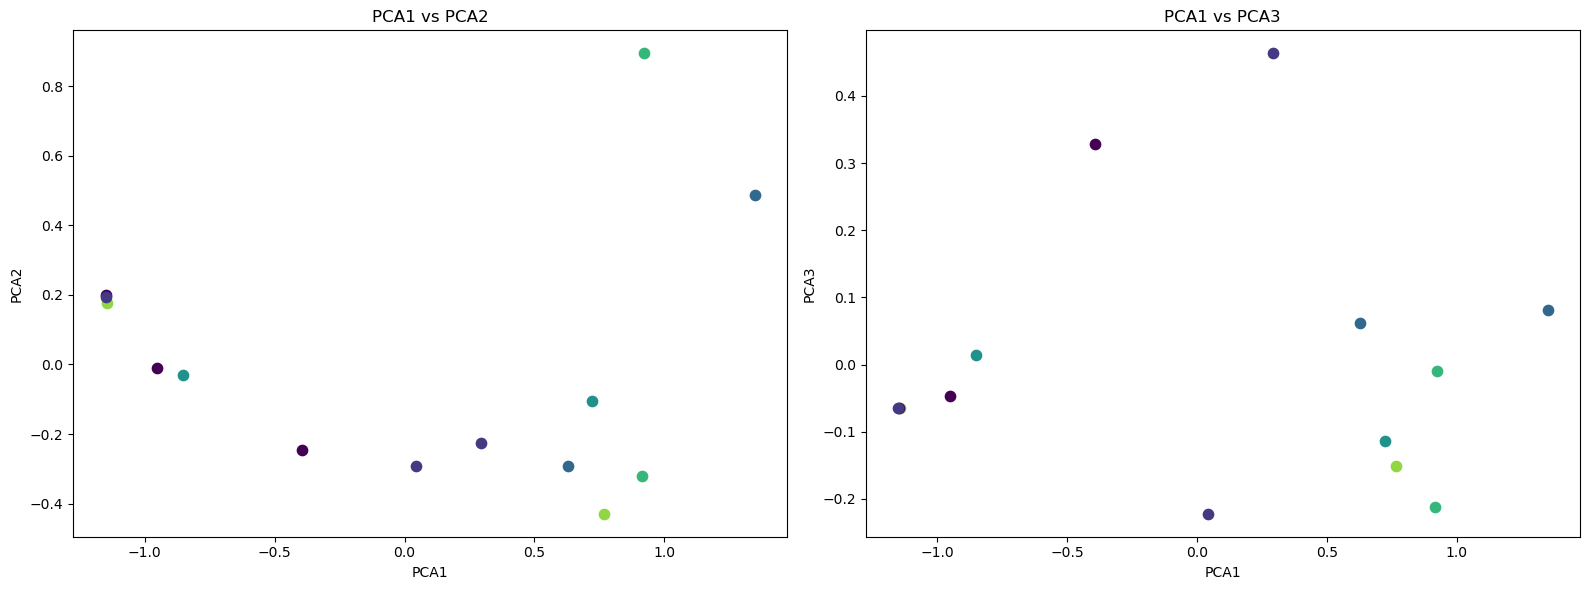

In [145]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances

# Your data
data = {
    'rsID': ['rs2231142', 'rs4961', 'rs1042713', 'rs7412', 'rs4673993', 'rs71647871', 'rs78769542', 'rs16969968', 'rs12777823', 'rs3745274', 'rs2242480', 'rs2108622', 'rs1801160', 'rs3918290'],
    'Alt_Freq_MAF_K&H': [0.102678571, 0.194399351, 0.373782468, 0.034902597, 0.430194805, 0.003652597, 0.003246753, 0.172077922, 0.36525974, 0.27637987, 0.32711039, 0.421266234, 0.043425325, 0.002435065],
    'Global': [0.1119, 0.1984, 0.3883, 0.07424, 0.3195, 0.01176, 0.0003074, 0.3016, 0.1905, 0.2564, 0.1533, 0.2875, 0.04675, 0.005061],
    'East_Asian': [0.2982, 0.508, 0.5276, 0.0605, 0.2617, 0.00006684, 0.0001561, 0.02676, 0.3119, 0.1905, 0.2521, 0.2667, 0.01862, 0],
    'European_non_Finnish': [0.1109, 0.1989, 0.3652, 0.0783, 0.328, 0.01297, 0.00002289, 0.3354, 0.1513, 0.2408, 0.09031, 0.2978, 0.045, 0.004832],
    'South_Asian': [0.09018, 0.175, 0.4483, 0.04164, 0.4725, 0.006593, 0.004678, 0.2376, 0.3345, 0.3869, 0.321, 0.3903, 0.09625, 0.003996],
    'African_African_American': [0.02677, 0.07598, 0.4935, 0.1056, 0.1208, 0.002414, 0.0002002, 0.05608, 0.2496, 0.3771, 0.7415, 0.09773, 0.02498, 0.0004799]
}

df = pd.DataFrame(data)

# Extract rsID and MAF columns
rsIDs = df['rsID']
maf_columns = ['Alt_Freq_MAF_K&H', 'Global', 'East_Asian', 'European_non_Finnish', 'South_Asian', 'African_African_American']
df_maf = df[maf_columns]

# Calculate pairwise genetic distances
genetic_distances = pairwise_distances(df_maf, metric='euclidean')

# Perform PCA on the distance matrix
pca = PCA(n_components=3)
pca_result = pca.fit_transform(genetic_distances)

# Create a DataFrame for visualization
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2', 'PC3'])

# Display the loadings of each rsID for the first few principal components
loadings_df = pd.DataFrame(data=pca.components_.T, columns=['PC1', 'PC2', 'PC3'], index=rsIDs)
print("Loadings of each rsID for the first few principal components:")
print(loadings_df)
# Create a color map for MAF columns
color_map = {column: plt.cm.get_cmap('viridis')(i / len(maf_columns)) for i, column in enumerate(maf_columns)}

# Visualize PCA results
fig = plt.figure(figsize=(16, 6))

# Plot PCA1 against PCA2
ax1 = fig.add_subplot(121)
for i, rsID in enumerate(rsIDs):
    label_color = color_map[maf_columns[i % len(maf_columns)]]  # Corrected color assignment
    ax1.scatter(pca_df.loc[i, 'PC1'], pca_df.loc[i, 'PC2'], s=55, color=label_color)  # Set the size to 50

ax1.set_xlabel('PCA1')
ax1.set_ylabel('PCA2')
ax1.set_title('PCA1 vs PCA2')

# Plot PCA1 against PCA3
ax2 = fig.add_subplot(122)
for i, rsID in enumerate(rsIDs):
    label_color = color_map[maf_columns[i % len(maf_columns)]]  # Corrected color assignment
    ax2.scatter(pca_df.loc[i, 'PC1'], pca_df.loc[i, 'PC3'], s=55, color=label_color)  # Set the size to 50

ax2.set_xlabel('PCA1')
ax2.set_ylabel('PCA3')
ax2.set_title('PCA1 vs PCA3')

plt.tight_layout()
plt.show()

In [19]:
import pandas as pd

data = {
    'bar': ['A', 'A', 'B', 'C', 'D', 'A', 'B', 'E', 'F', 'H'],
    'type': ['cLAD', 'ciLAD', 'cLAD', 'fLAD', 'ciLAD', 'fLAD', 'fLAD', 'cLAD', 'ciLAD', 'fLAD']
}

df = pd.DataFrame(data)
df

,bar,type
0,A,cLAD
1,A,ciLAD
2,B,cLAD
3,C,fLAD
4,D,ciLAD
5,A,fLAD
6,B,fLAD
7,E,cLAD
8,F,ciLAD
9,H,fLAD


In [20]:
def prioritize_types(types):
    if 'ciLAD' in types.values:
        return 'ciLAD'
    elif 'cLAD' in types.values:
        return 'cLAD'
    elif 'fLAD' in types.values:
        return 'fLAD'
    elif 'cLAD' in types.values and 'ciLAD' in types.values:
        return 'ciLAD'
    elif 'ciLAD' in types.values and 'fLAD' in types.values:
        return 'ciLAD'
    elif 'cLAD' in types.values and 'fLAD' in types.values:
        return 'cLAD'
    elif 'cLAD' in types.values and 'ciLAD' in types.values and 'fLAD' in types.values:
        return 'ciLAD'

df = df.groupby('bar')['type'].agg(prioritize_types).reset_index()
df

,bar,type
0,A,ciLAD
1,B,cLAD
2,C,fLAD
3,D,ciLAD
4,E,cLAD
5,F,ciLAD
6,H,fLAD


In [43]:
import pandas as pd

# Your initial DataFrame
data = {'start_df1': [3000000, 3100000, 3200000, 3300000, 3400000, 3600000, 3900000, 4400000, 4600000, 4700000, 4800000, 4900000, 5000000, 5100000, 5200000],
        'end_df1': [3100000, 3200000, 3300000, 3400000, 3500000, 3700000, 4000000, 4500000, 4700000, 4800000, 4900000, 5000000, 5100000, 5200000, 5300000],
        'chrom': ['chr1']*15}

df = pd.DataFrame(data)

# Create a new DataFrame with the missing rows filled in
new_rows = []
for chrom, group in df.groupby('chrom'):
    cumulative_diff = 0
    for i in range(1, len(group)):
        diff = group['start_df1'].iloc[i] - group['end_df1'].iloc[i - 1]
        cumulative_diff += diff
        if cumulative_diff > 100000:
            # Insert missing rows
            num_missing_rows = cumulative_diff // 100000
            for j in range(num_missing_rows):
                new_row = {
                    'start_df1': group['end_df1'].iloc[i - 1] + 100000 * j,
                    'end_df1': group['end_df1'].iloc[i - 1] + 100000 * (j + 1),
                    'chrom': chrom
                }
                new_rows.append(new_row)
            cumulative_diff = 0  # reset cumulative difference after inserting rows

# Append the new rows to the original DataFrame
new_df = df.append(new_rows, ignore_index=True)

# Sort the DataFrame based on 'chrom' and 'start_df1'
new_df.sort_values(by=['chrom', 'start_df1'], inplace=True)

# Reset the index
new_df.reset_index(drop=True, inplace=True)
new_df

C:\Users\GenepoweRx_Madhu\AppData\Local\Temp\ipykernel_5868\1991291127.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = df.append(new_rows, ignore_index=True)


,start_df1,end_df1,chrom
0,3000000,3100000,chr1
1,3100000,3200000,chr1
2,3200000,3300000,chr1
3,3300000,3400000,chr1
4,3400000,3500000,chr1
5,3600000,3700000,chr1
6,3700000,3800000,chr1
7,3800000,3900000,chr1
8,3900000,4000000,chr1
9,3900000,4000000,chr1


In [3]:
import pandas as pd

# Your initial DataFrame
data = {
    'start_df1': [3000000, 3100000, 3200000, 3300000, 3400000, 3600000, 3900000, 4400000, 4600000, 4700000, 4800000, 4900000, 5000000, 5100000, 5200000],
    'end_df1': [3100000, 3200000, 3300000, 3400000, 3500000, 3700000, 4000000, 4500000, 4700000, 4800000, 4900000, 5000000, 5100000, 5200000, 5300000],
    'chrom': ['chr1']*15
}

df = pd.DataFrame(data)

# Function to impute missing rows
def impute_missing_rows(df):
    result = pd.DataFrame(columns=df.columns)
    
    for chrom, group in df.groupby('chrom'):
        start = group['start_df1'].min()
        end = group['end_df1'].max()
        
        # Generate new rows based on 100000 difference
        new_rows = pd.DataFrame({
            'start_df1': range(start, end, 100000),
            'end_df1': range(start + 100000, end + 100000, 100000),
            'chrom': [chrom]*len(range(start, end, 100000))
        })
        
        result = pd.concat([result, new_rows], ignore_index=True)
    
    return result

# Concatenate the original DataFrame with the imputed rows
result_df = pd.concat([df, impute_missing_rows(df)], ignore_index=True)

# Sort the DataFrame based on 'chrom' and 'start_df1'
result_df = result_df.sort_values(by=['chrom', 'start_df1']).reset_index(drop=True)
result_df.drop_duplicates(subset = ['start_df1', 'end_df1', 'chrom'], inplace=True)
result_df

,start_df1,end_df1,chrom
0,3000000,3100000,chr1
2,3100000,3200000,chr1
4,3200000,3300000,chr1
6,3300000,3400000,chr1
8,3400000,3500000,chr1
10,3500000,3600000,chr1
11,3600000,3700000,chr1
13,3700000,3800000,chr1
14,3800000,3900000,chr1
15,3900000,4000000,chr1


In [5]:
import pandas as pd

# Your initial DataFrame
data = {
    'start_df1': [3000000, 3100000, 3200000, 3300000, 3400000, 3600000, 3900000, 4400000, 4600000, 4700000, 4800000, 4900000, 5000000, 5100000, 5200000],
    'end_df1': [3100000, 3200000, 3300000, 3400000, 3500000, 3700000, 4000000, 4500000, 4700000, 4800000, 4900000, 5000000, 5100000, 5200000, 5300000],
    'chrom': ['chr1']*15,
    'col1': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
    'col2': ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O']
}

df = pd.DataFrame(data)

# Function to impute missing rows
def impute_missing_rows(df):
    result = pd.DataFrame(columns=df.columns)
    
    for chrom, group in df.groupby('chrom'):
        start = group['start_df1'].min()
        end = group['end_df1'].max()
        
        # Generate new rows based on 100000 difference
        new_rows = pd.DataFrame({
            'start_df1': range(start, end, 100000),
            'end_df1': range(start + 100000, end + 100000, 100000),
            'chrom': [chrom]*len(range(start, end, 100000)),
            'col1': [group['col1'].iloc[0]]*len(range(start, end, 100000)),  # Assuming col1 doesn't change within a chrom group
            'col2': [group['col2'].iloc[0]]*len(range(start, end, 100000))   # Assuming col2 doesn't change within a chrom group
        })
        
        result = pd.concat([result, new_rows], ignore_index=True)
    
    return result

# Concatenate the original DataFrame with the imputed rows
result_df = pd.concat([df, impute_missing_rows(df)], ignore_index=True)

# Sort the DataFrame based on 'chrom' and 'start_df1'
result_df = result_df.sort_values(by=['chrom', 'start_df1']).reset_index(drop=True)
result_df.drop_duplicates(subset=['start_df1', 'end_df1', 'chrom'], inplace=True)
result_df

,start_df1,end_df1,chrom,col1,col2
0,3000000,3100000,chr1,1,A
2,3100000,3200000,chr1,2,B
4,3200000,3300000,chr1,3,C
6,3300000,3400000,chr1,4,D
8,3400000,3500000,chr1,5,E
10,3500000,3600000,chr1,1,A
11,3600000,3700000,chr1,6,F
13,3700000,3800000,chr1,1,A
14,3800000,3900000,chr1,1,A
15,3900000,4000000,chr1,7,G


In [6]:
import pandas as pd

# Assuming your data is in a DataFrame named 'df'
# Replace 'your_column_name' with the actual column name you want to fill null values for

# Example DataFrame
data = {
    'your_column_name': [1, 2, None, None, 5, 6, None, 8, None, None, 11],
    # add other columns if necessary
}

df = pd.DataFrame(data)

# Fill null rows with the mean of the previous non-null row
df['your_column_name'] = df['your_column_name'].ffill().fillna(df['your_column_name'].mean())

# Print the resulting DataFrame
df

,your_column_name
0,1.0
1,2.0
2,2.0
3,2.0
4,5.0
5,6.0
6,6.0
7,8.0
8,8.0
9,8.0


In [10]:
import pandas as pd

# Sample data
data = {'start1': [4, 4, 9, 9, 9, 9, 18, 18, 18],
        'end1': [8, 8, 21, 21, 21, 21, 26, 26, 26],
        'range_start': [0, 5, 5, 10, 15, 20, 15, 20, 25],
        'range_end': [5, 10, 10, 15, 20, 25, 20, 25, 30],
        'bound': ['A', 'A', 'B', 'B', 'B', 'B', 'C', 'C', 'C']}

df = pd.DataFrame(data)

# Calculate the shared portion and add it to a new 'difference' column
df['difference'] = df.apply(lambda row: len(range(max(row['start1'], row['range_start']), min(row['end1'], row['range_end']) + 1)), axis=1)

# Display the resulting DataFrame
df

,start1,end1,range_start,range_end,bound,difference
0,4,8,0,5,A,2
1,4,8,5,10,A,4
2,9,21,5,10,B,2
3,9,21,10,15,B,6
4,9,21,15,20,B,6
5,9,21,20,25,B,2
6,18,26,15,20,C,3
7,18,26,20,25,C,6
8,18,26,25,30,C,2


In [12]:
import pandas as pd

# Sample DataFrame
data = {'Group': ['A', 'A', 'B', 'B', 'A', 'C'],
        'Value1': [10, 20, 30, 40, 50, 60],
        'Value2': [5, 15, 25, 35, 45, 55],
        'Value3': [1, 2, 3, 4, 5, 6]}

df = pd.DataFrame(data)

# Calculate the sum of unique values in 'Value1', 'Value2', and 'Value3' for each group
grouped_df = df.groupby('Group').agg({
    'Value1': lambda x: pd.Series.unique(x).sum(),
    'Value2': lambda x: pd.Series.unique(x).sum(),
    'Value3': lambda x: pd.Series.unique(x).sum()
}).reset_index()

grouped_df

,Group,Value1,Value2,Value3
0,A,80,65,8
1,B,70,60,7
2,C,60,55,6


In [5]:
import pandas as pd

# Example DataFrame
df = pd.DataFrame({
    'samples': ['Sample1', 'Sample1', 'Sample2', 'Sample2', 'Sample3'],
    'variant': ['A', 'B', 'A', 'C', 'A']
})

# Counting the occurrence of each variant
variant_counts = df['variant'].value_counts()

# Filtering variants that are present in all samples
variants_in_all_samples = variant_counts[variant_counts == df['samples'].nunique()].index.tolist()

# Filtering the DataFrame to include only rows with variants present in all samples
rows_in_all_samples = df[df['variant'].isin(variants_in_all_samples)]
rows_in_all_samples

,samples,variant
0,Sample1,A
2,Sample2,A
4,Sample3,A
